# Building a Robust Text-based toxicity Predictor

Author: Yi Xiang 

In this notebook, we provide an end to end implementation of training a Binary Toxicity Classifier and improve its robustness against Text Adversarial Attacks using Adversarial Training. 

# Load Packages

In [2]:
%pip install --upgrade transformers datasets

%pip install textattack[tensorflow]
%pip install tqdm

%pip install sentence_transformers

  Using cached transformers-4.18.0-py3-none-any.whl (4.0 MB)
  Using cached datasets-2.4.0-py3-none-any.whl (365 kB)
  Using cached tokenizers-0.12.1-cp36-cp36m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (6.6 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.10.3
    Uninstalling tokenizers-0.10.3:
      Successfully uninstalled tokenizers-0.10.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.12.2
    Uninstalling transformers-4.12.2:
      Successfully uninstalled transformers-4.12.2
  Attempting uninstall: datasets
    Found existing installation: datasets 1.15.0
    Uninstalling datasets-1.15.0:
      Successfully uninstalled datasets-1.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
textattack 0.3.5 requires datasets==1.15, but you have datasets 2.4.0 which is incompatible.
No

In [3]:
%load_ext autoreload
%autoreload 2

%pip install nb_black
%load_ext lab_black

  Preparing metadata (setup.py) ... done
  Created wheel for nb-black: filename=nb_black-1.0.7-py3-none-any.whl size=5279 sha256=394957f0334e46732302c9b8527c25a93e300a08124a4925ed1909bbd6aec3be
  Stored in directory: /home/ec2-user/.cache/pip/wheels/b8/d1/fe/2f4f49a959887ffe9ebdf841c1a221a5b4eb047a1ca09b50a9
Successfully built nb-black
Note: you may need to restart the kernel to use updated packages.


In [4]:
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
from sklearn import metrics
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    classification_report,
)
import textattack
from textattack.models.wrappers import ModelWrapper
from tqdm import tqdm  # tqdm provides us a nice progress bar.
from textattack.loggers import CSVLogger  # tracks a dataframe for us.
from textattack.attack_results import SuccessfulAttackResult
from textattack.attack_recipes import PWWSRen2019
from textattack.attack_recipes.a2t_yoo_2021 import (
    A2TYoo2021,
)
from textattack.attack_recipes.textfooler_jin_2019 import TextFoolerJin2019
from textattack.attack_recipes.pruthi_2019 import Pruthi2019
from textattack.attack_recipes.textbugger_li_2018 import TextBuggerLi2018
from textattack.attack_recipes.deepwordbug_gao_2018 import DeepWordBugGao2018
from textattack import Attacker
from textattack import AttackArgs
from textattack.models.wrappers import ModelWrapper
import torch

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from datasets import Dataset

textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw to /home/ec2-user/nltk_data...
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
label_col = "toxic"
model_name = "binary_toxicity_detector"
model_dir = f"../models/{model_name}"
model_name_AT = "binary_toxicity_detector_at"
model_dir_AT = f"../models/{model_name_AT}"
num_proc = multiprocessing.cpu_count()
print("Number of CPUs =", num_proc)

Number of CPUs = 16


In [52]:
import os

os.makedirs("../models", exist_ok=True)

# Download the Jigsaw Data
Step 1: Manually download the Jigsaw Data from Kaggle: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

You can manually download the data from it's homepage or use the Kaggle CLI tool (follow the instructions here: https://www.kaggle.com/docs/api)

Step 2: Unzip and save the data to a local folder named `data`

# Data Preparation

Load the train test data

In [8]:
df_train = pd.read_csv("../data/train.csv.zip")
df_test_text = pd.read_csv("../data/test.csv.zip")
df_test_labels = pd.read_csv("../data/test_labels.csv.zip")
df_test = df_test_text.merge(df_test_labels, on=["id"], how="left")
df_test = df_test[df_test[label_col].isin([0, 1])]

Split the test into equal valid and test sets

In [9]:
df_valid = df_test.sample(frac=0.5, random_state=199, replace=False)
df_test_indices = np.array(
    set(df_test.index.to_numpy()).intersection(set(df_valid.index.to_numpy()))
)
df_test = df_test.loc[df_test_indices]

In [10]:
df_train[label_col] = df_train[label_col].astype("float")
df_valid[label_col] = df_valid[label_col].astype("float")
df_test[label_col] = df_test[label_col].astype("float")

Data Visualization

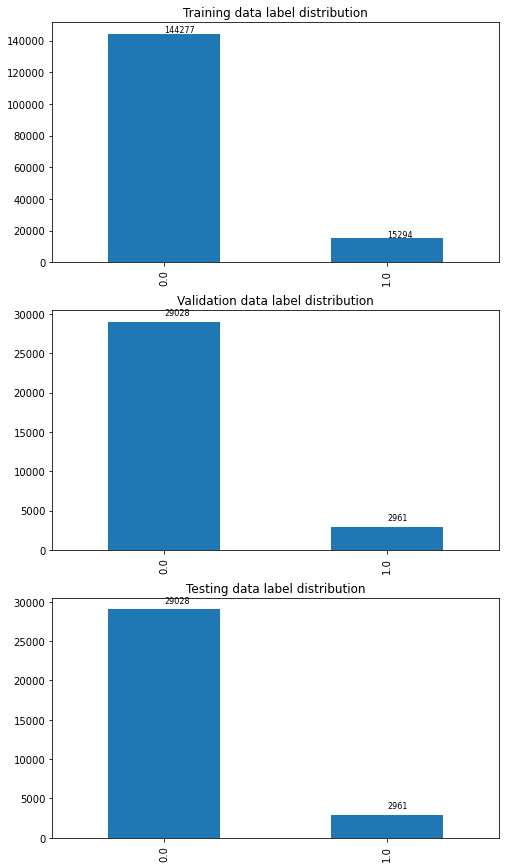

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 15))
_ = (
    df_train[label_col]
    .value_counts()
    .plot(kind="bar", title="Training data label distribution", ax=axes[0])
)
_ = (
    df_valid[label_col]
    .value_counts()
    .plot(kind="bar", title="Validation data label distribution", ax=axes[1])
)
_ = (
    df_test[label_col]
    .value_counts()
    .plot(kind="bar", title="Testing data label distribution", ax=axes[2])
)


def add_count(df, ax):
    for i, count in enumerate(df.value_counts()):
        ax.text(x=i, y=count + 800, s=f"{count}", fontdict=dict(fontsize=8))


add_count(df_train[label_col], axes[0])
add_count(df_valid[label_col], axes[1])
add_count(df_test[label_col], axes[2])

Data Formatting

In [12]:
df_train["labels"] = df_train[label_col].values.tolist()
df_valid["labels"] = df_valid[label_col].values.tolist()
df_test["labels"] = df_test[label_col].values.tolist()

df_train = df_train[["comment_text", "labels"]]
df_valid = df_valid[["comment_text", "labels"]]
df_test = df_test[["comment_text", "labels"]]

df_train.rename(columns={"comment_text": "text"}, inplace=True)
df_valid.rename(columns={"comment_text": "text"}, inplace=True)
df_test.rename(columns={"comment_text": "text"}, inplace=True)

In [13]:
df_train.head(2)

,text,labels
0,Explanation\nWhy the edits made under my usern...,0.0
1,D'aww! He matches this background colour I'm s...,0.0


In [14]:
df_valid.head(2)

,text,labels
126176,:Here's another go \n Tense is the way in whic...,0.0
38773,", được gắn vào, nhúng vào trong các thiết bị k...",0.0


In [15]:
df_test.head(2)

,text,labels
131074,""" \n *Thanks, comments on your talk page as we...",0.0
131081,James Griffin Stadium == \n I removed James Gr...,0.0


In [16]:
# Subsample and balance the dataset

subset = True
if subset == True:
    df_train = pd.concat(
        [
            df_train[df_train["labels"] == 0].sample(
                5000, random_state=199, replace=False
            ),
            df_train[df_train["labels"] == 1].sample(
                5000, random_state=199, replace=False
            ),
        ]
    )
    df_valid = pd.concat(
        [
            df_valid[df_valid["labels"] == 0].sample(
                500, random_state=199, replace=False
            ),
            df_valid[df_valid["labels"] == 1].sample(
                500, random_state=199, replace=False
            ),
        ]
    )
    df_test = pd.concat(
        [
            df_test[df_test["labels"] == 0].sample(500, random_state=199, replace=False),
            df_test[df_test["labels"] == 1].sample(500, random_state=199, replace=False),
        ]
    )

In [17]:
train_dataset = Dataset.from_pandas(df_train)
valid_dataset = Dataset.from_pandas(df_valid)
test_dataset = Dataset.from_pandas(df_test)

In [13]:
train_dataset

Dataset({
    features: ['text', 'labels', '__index_level_0__'],
    num_rows: 10000
})

In [14]:
valid_dataset

Dataset({
    features: ['text', 'labels', '__index_level_0__'],
    num_rows: 1000
})

In [15]:
test_dataset

Dataset({
    features: ['text', 'labels', '__index_level_0__'],
    num_rows: 1000
})

# Tokenization

In [18]:
pretrained_model_name_or_path = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path)


def preprocess_function(examples):
    result = tokenizer(
        examples["text"], padding="max_length", max_length=128, truncation=True
    )
    return result


train_dataset = train_dataset.map(
    preprocess_function, batched=True, load_from_cache_file=False, num_proc=num_proc
)

valid_dataset = valid_dataset.map(
    preprocess_function, batched=True, load_from_cache_file=False, num_proc=num_proc
)

test_dataset = test_dataset.map(
    preprocess_function, batched=True, load_from_cache_file=False, num_proc=num_proc
)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.
Setting TOKENIZERS_PARALLELISM=false for forked processes.
Setting TOKENIZERS_PARALLELISM=false for forked processes.


In [18]:
train_dataset

Dataset({
    features: ['__index_level_0__', 'attention_mask', 'input_ids', 'labels', 'text'],
    num_rows: 10000
})

In [19]:
train_dataset[0].keys()

dict_keys(['__index_level_0__', 'attention_mask', 'input_ids', 'labels', 'text'])

# Modeling

In [19]:
base_model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path, num_labels=1
)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

In [21]:
training_args = TrainingArguments(
    output_dir=model_dir,
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=5,
    logging_dir=os.path.join(model_dir, "logs"),
    learning_rate=5e-6,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    disable_tqdm=True,
)

In [22]:
# compute metrics function
def compute_metrics(pred):
    targets = 1 * (pred.label_ids >= 0.5)
    outputs = 1 * (pred.predictions >= 0.5)
    accuracy = metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average="micro")
    f1_score_macro = metrics.f1_score(targets, outputs, average="macro")
    f1_score_weighted = metrics.f1_score(targets, outputs, average="weighted")
    ap_score_micro = metrics.average_precision_score(
        targets, pred.predictions, average="micro"
    )
    ap_score_macro = metrics.average_precision_score(
        targets, pred.predictions, average="macro"
    )
    ap_score_weighted = metrics.average_precision_score(
        targets, pred.predictions, average="weighted"
    )
    auc_score_micro = metrics.roc_auc_score(targets, pred.predictions, average="micro")
    auc_score_macro = metrics.roc_auc_score(targets, pred.predictions, average="macro")
    auc_score_weighted = metrics.roc_auc_score(
        targets, pred.predictions, average="weighted"
    )
    return {
        "accuracy": accuracy,
        "f1_score_micro": f1_score_micro,
        "f1_score_macro": f1_score_macro,
        "f1_score_weighted": f1_score_weighted,
        "ap_score_micro": ap_score_micro,
        "ap_score_macro": ap_score_macro,
        "ap_score_weighted": ap_score_weighted,
        "auc_score_micro": auc_score_micro,
        "auc_score_macro": auc_score_macro,
        "auc_score_weighted": auc_score_weighted,
    }

In [24]:
trainer = Trainer(
    model=base_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

In [24]:
train_result = trainer.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running training *****
  Num examples = 10000
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 3130
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
Saving model checkpoint to ../models/binary_toxicity_detector/checkpoint-313
Configuration saved in ../models/binary_toxicity_detector/checkpoint-313/config.json


{'eval_loss': 0.09476225078105927, 'eval_accuracy': 0.886, 'eval_f1_score_micro': 0.886, 'eval_f1_score_macro': 0.8858680634813845, 'eval_f1_score_weighted': 0.8858680634813845, 'eval_ap_score_micro': 0.9248801452971526, 'eval_ap_score_macro': 0.9248801452971526, 'eval_ap_score_weighted': 0.9248801452971526, 'eval_auc_score_micro': 0.94158, 'eval_auc_score_macro': 0.94158, 'eval_auc_score_weighted': 0.94158, 'eval_runtime': 3.3755, 'eval_samples_per_second': 296.251, 'eval_steps_per_second': 4.74, 'epoch': 1.0}


Model weights saved in ../models/binary_toxicity_detector/checkpoint-313/pytorch_model.bin
Deleting older checkpoint [../models/binary_toxicity_detector/checkpoint-1252] due to args.save_total_limit


{'loss': 0.1748, 'learning_rate': 5e-06, 'epoch': 1.6}


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
Saving model checkpoint to ../models/binary_toxicity_detector/checkpoint-626
Configuration saved in ../models/binary_toxicity_detector/checkpoint-626/config.json


{'eval_loss': 0.0732681080698967, 'eval_accuracy': 0.909, 'eval_f1_score_micro': 0.909, 'eval_f1_score_macro': 0.9085389448208419, 'eval_f1_score_weighted': 0.9085389448208419, 'eval_ap_score_micro': 0.9363197310582302, 'eval_ap_score_macro': 0.9363197310582302, 'eval_ap_score_weighted': 0.9363197310582302, 'eval_auc_score_micro': 0.956984, 'eval_auc_score_macro': 0.956984, 'eval_auc_score_weighted': 0.956984, 'eval_runtime': 3.579, 'eval_samples_per_second': 279.411, 'eval_steps_per_second': 4.471, 'epoch': 2.0}


Model weights saved in ../models/binary_toxicity_detector/checkpoint-626/pytorch_model.bin
Deleting older checkpoint [../models/binary_toxicity_detector/checkpoint-2191] due to args.save_total_limit
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
Saving model checkpoint to ../models/binary_toxicity_detector/checkpoint-939
Configuration saved in ../models/binary_toxicity_detector/checkpoint-939/config.json


{'eval_loss': 0.07416142523288727, 'eval_accuracy': 0.915, 'eval_f1_score_micro': 0.915, 'eval_f1_score_macro': 0.9146393512590696, 'eval_f1_score_weighted': 0.9146393512590696, 'eval_ap_score_micro': 0.9416459747736318, 'eval_ap_score_macro': 0.9416459747736318, 'eval_ap_score_weighted': 0.9416459747736318, 'eval_auc_score_micro': 0.9610920000000001, 'eval_auc_score_macro': 0.9610920000000001, 'eval_auc_score_weighted': 0.9610920000000001, 'eval_runtime': 3.8119, 'eval_samples_per_second': 262.338, 'eval_steps_per_second': 4.197, 'epoch': 3.0}


Model weights saved in ../models/binary_toxicity_detector/checkpoint-939/pytorch_model.bin
Deleting older checkpoint [../models/binary_toxicity_detector/checkpoint-2504] due to args.save_total_limit


{'loss': 0.0507, 'learning_rate': 4.049429657794677e-06, 'epoch': 3.19}


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
Saving model checkpoint to ../models/binary_toxicity_detector/checkpoint-1252
Configuration saved in ../models/binary_toxicity_detector/checkpoint-1252/config.json


{'eval_loss': 0.06903228908777237, 'eval_accuracy': 0.917, 'eval_f1_score_micro': 0.917, 'eval_f1_score_macro': 0.916846248713872, 'eval_f1_score_weighted': 0.916846248713872, 'eval_ap_score_micro': 0.9361461307250853, 'eval_ap_score_macro': 0.9361461307250853, 'eval_ap_score_weighted': 0.9361461307250853, 'eval_auc_score_micro': 0.9604840000000001, 'eval_auc_score_macro': 0.9604840000000001, 'eval_auc_score_weighted': 0.9604840000000001, 'eval_runtime': 3.6186, 'eval_samples_per_second': 276.35, 'eval_steps_per_second': 4.422, 'epoch': 4.0}


Model weights saved in ../models/binary_toxicity_detector/checkpoint-1252/pytorch_model.bin
Deleting older checkpoint [../models/binary_toxicity_detector/checkpoint-2817] due to args.save_total_limit


{'loss': 0.0356, 'learning_rate': 3.0988593155893537e-06, 'epoch': 4.79}


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
Saving model checkpoint to ../models/binary_toxicity_detector/checkpoint-1565
Configuration saved in ../models/binary_toxicity_detector/checkpoint-1565/config.json


{'eval_loss': 0.0801241472363472, 'eval_accuracy': 0.911, 'eval_f1_score_micro': 0.911, 'eval_f1_score_macro': 0.9105490779017025, 'eval_f1_score_weighted': 0.9105490779017025, 'eval_ap_score_micro': 0.9238170089188678, 'eval_ap_score_macro': 0.9238170089188678, 'eval_ap_score_weighted': 0.9238170089188678, 'eval_auc_score_micro': 0.955448, 'eval_auc_score_macro': 0.955448, 'eval_auc_score_weighted': 0.955448, 'eval_runtime': 3.361, 'eval_samples_per_second': 297.527, 'eval_steps_per_second': 4.76, 'epoch': 5.0}


Model weights saved in ../models/binary_toxicity_detector/checkpoint-1565/pytorch_model.bin
Deleting older checkpoint [../models/binary_toxicity_detector/checkpoint-3130] due to args.save_total_limit
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
Saving model checkpoint to ../models/binary_toxicity_detector/checkpoint-1878
Configuration saved in ../models/binary_toxicity_detector/checkpoint-1878/config.json


{'eval_loss': 0.08108755201101303, 'eval_accuracy': 0.913, 'eval_f1_score_micro': 0.9130000000000001, 'eval_f1_score_macro': 0.9126076959471066, 'eval_f1_score_weighted': 0.9126076959471066, 'eval_ap_score_micro': 0.9195105180909195, 'eval_ap_score_macro': 0.9195105180909195, 'eval_ap_score_weighted': 0.9195105180909195, 'eval_auc_score_micro': 0.952132, 'eval_auc_score_macro': 0.952132, 'eval_auc_score_weighted': 0.952132, 'eval_runtime': 3.4096, 'eval_samples_per_second': 293.293, 'eval_steps_per_second': 4.693, 'epoch': 6.0}


Model weights saved in ../models/binary_toxicity_detector/checkpoint-1878/pytorch_model.bin
Deleting older checkpoint [../models/binary_toxicity_detector/checkpoint-313] due to args.save_total_limit


{'loss': 0.0272, 'learning_rate': 2.1482889733840307e-06, 'epoch': 6.39}


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
Saving model checkpoint to ../models/binary_toxicity_detector/checkpoint-2191
Configuration saved in ../models/binary_toxicity_detector/checkpoint-2191/config.json


{'eval_loss': 0.07977934181690216, 'eval_accuracy': 0.911, 'eval_f1_score_micro': 0.911, 'eval_f1_score_macro': 0.9105742439755675, 'eval_f1_score_weighted': 0.9105742439755676, 'eval_ap_score_micro': 0.9030886042965646, 'eval_ap_score_macro': 0.9030886042965646, 'eval_ap_score_weighted': 0.9030886042965646, 'eval_auc_score_micro': 0.944252, 'eval_auc_score_macro': 0.944252, 'eval_auc_score_weighted': 0.944252, 'eval_runtime': 3.7117, 'eval_samples_per_second': 269.422, 'eval_steps_per_second': 4.311, 'epoch': 7.0}


Model weights saved in ../models/binary_toxicity_detector/checkpoint-2191/pytorch_model.bin
Deleting older checkpoint [../models/binary_toxicity_detector/checkpoint-626] due to args.save_total_limit


{'loss': 0.0211, 'learning_rate': 1.1977186311787073e-06, 'epoch': 7.99}


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
Saving model checkpoint to ../models/binary_toxicity_detector/checkpoint-2504
Configuration saved in ../models/binary_toxicity_detector/checkpoint-2504/config.json


{'eval_loss': 0.0749511644244194, 'eval_accuracy': 0.916, 'eval_f1_score_micro': 0.916, 'eval_f1_score_macro': 0.9156965074267363, 'eval_f1_score_weighted': 0.9156965074267361, 'eval_ap_score_micro': 0.9221388120691496, 'eval_ap_score_macro': 0.9221388120691496, 'eval_ap_score_weighted': 0.9221388120691496, 'eval_auc_score_micro': 0.951704, 'eval_auc_score_macro': 0.951704, 'eval_auc_score_weighted': 0.951704, 'eval_runtime': 3.8132, 'eval_samples_per_second': 262.248, 'eval_steps_per_second': 4.196, 'epoch': 8.0}


Model weights saved in ../models/binary_toxicity_detector/checkpoint-2504/pytorch_model.bin
Deleting older checkpoint [../models/binary_toxicity_detector/checkpoint-939] due to args.save_total_limit
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
Saving model checkpoint to ../models/binary_toxicity_detector/checkpoint-2817
Configuration saved in ../models/binary_toxicity_detector/checkpoint-2817/config.json


{'eval_loss': 0.07852482795715332, 'eval_accuracy': 0.917, 'eval_f1_score_micro': 0.917, 'eval_f1_score_macro': 0.9166900035030348, 'eval_f1_score_weighted': 0.9166900035030349, 'eval_ap_score_micro': 0.9058545901360162, 'eval_ap_score_macro': 0.9058545901360162, 'eval_ap_score_weighted': 0.9058545901360162, 'eval_auc_score_micro': 0.946692, 'eval_auc_score_macro': 0.946692, 'eval_auc_score_weighted': 0.946692, 'eval_runtime': 3.822, 'eval_samples_per_second': 261.646, 'eval_steps_per_second': 4.186, 'epoch': 9.0}


Model weights saved in ../models/binary_toxicity_detector/checkpoint-2817/pytorch_model.bin
Deleting older checkpoint [../models/binary_toxicity_detector/checkpoint-1565] due to args.save_total_limit


{'loss': 0.0177, 'learning_rate': 2.4714828897338403e-07, 'epoch': 9.58}


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
Saving model checkpoint to ../models/binary_toxicity_detector/checkpoint-3130
Configuration saved in ../models/binary_toxicity_detector/checkpoint-3130/config.json


{'eval_loss': 0.0772540271282196, 'eval_accuracy': 0.917, 'eval_f1_score_micro': 0.917, 'eval_f1_score_macro': 0.9166900035030348, 'eval_f1_score_weighted': 0.9166900035030349, 'eval_ap_score_micro': 0.9123349457213779, 'eval_ap_score_macro': 0.9123349457213779, 'eval_ap_score_weighted': 0.9123349457213779, 'eval_auc_score_micro': 0.9488119999999999, 'eval_auc_score_macro': 0.9488119999999999, 'eval_auc_score_weighted': 0.9488119999999999, 'eval_runtime': 3.8296, 'eval_samples_per_second': 261.125, 'eval_steps_per_second': 4.178, 'epoch': 10.0}


Model weights saved in ../models/binary_toxicity_detector/checkpoint-3130/pytorch_model.bin
Deleting older checkpoint [../models/binary_toxicity_detector/checkpoint-1878] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ../models/binary_toxicity_detector/checkpoint-1252 (score: 0.06903228908777237).


{'train_runtime': 1073.2722, 'train_samples_per_second': 93.173, 'train_steps_per_second': 2.916, 'train_loss': 0.05306276048715122, 'epoch': 10.0}


In [26]:
tokenizer.save_pretrained(model_dir)
trainer.save_model(model_dir)

tokenizer config file saved in ../models/binary_toxicity_detector/tokenizer_config.json
Special tokens file saved in ../models/binary_toxicity_detector/special_tokens_map.json
Saving model checkpoint to ../models/binary_toxicity_detector
Configuration saved in ../models/binary_toxicity_detector/config.json
Model weights saved in ../models/binary_toxicity_detector/pytorch_model.bin


# Text Attack

Now the model is trained, we evaluate the model's robustness by attacking the test set with adversarial examples.

In [27]:
class CustomModelWrapper(ModelWrapper):
    def __init__(self, model):
        self.model = model

    def __call__(self, text_input_list):
        device = self.model.device
        encoded_input = tokenizer(
            text_input_list,
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt",
        ).to(device)
        #         print(encoded_input.device)
        with torch.no_grad():
            output = self.model(**encoded_input)
        logits = output.logits
        preds = torch.sigmoid(logits)
        preds = preds.squeeze(dim=-1)
        final_preds = torch.stack((1 - preds, preds), dim=1)
        return final_preds

In [28]:
trained_model = AutoModelForSequenceClassification.from_pretrained(model_dir)
trained_model = trained_model.to("cuda:0")
trained_model.device

loading configuration file ../models/binary_toxicity_detector/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "regression",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.12.2",
  "vocab_size": 30522
}

loading weights file ../models/binary_toxicity_detector/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassifica

device(type='cuda', index=0)

In [29]:
model_wrapper = CustomModelWrapper(trained_model)

## Generate Attacks

In [33]:
test_dataset["text"][:10]

['", 9 June 2006 (UTC) \n\n Do not know what these accusations and conspiracies you speak of are. You are also obviously mixing up the act with the crime. You are not guilty of stealing my TV until a judge says you are, however you may have removed the TV from my possession. As for if its illegal, that is for the court to decide, they may find that I owed you the TV or that the TV was hazard in my house and its removal was warranted, etc. I am no longer participating in these threads as I believe you are diverting from your original points I commented on, and this talk page is starting to look obscenely unorderly.   13:08"',
 '" \n\n  \n +++++++++++++ \n 100% biased.  I can\'t write an article that says ""The US Government owes me money, here\'s why- here\'s why people might argue with me- but here\'s why they\'re wrong.""  Fucking ridiculous, not encyclopedia material."',
 '|listas = Marlowe, Scott',
 '==  C0pyr1ght 15 5h1t fb1 5uck5 4 5hut d0wn s1t35 C0pyr1ght 15 5h1t fb1 5uck5 4 5hu

In [39]:
threshold = 0.5
sub_sample_to_attack = 1000
df_train_to_attack = df_train[df_train["labels"] == 1].sample(sub_sample_to_attack)

## We attack the toxic samples
## Goal is to perturbe toxic samples enough that the model classifies them as Non-toxic
test_dataset_to_attack = textattack.datasets.Dataset(
    [
        (x, 1)
        for x, y in zip(
            test_dataset["text"],
            test_dataset["labels"],
        )
        if y > threshold
    ]
)

train_dataset_to_attack = textattack.datasets.Dataset(
    [
        (x, 1)
        for x, y in zip(
            df_train_to_attack["text"],
            df_train_to_attack["labels"],
        )
        if y > threshold
    ]
)

In [35]:
def generate_attacks(
    recipe, model_wrapper, dataset_to_attack, num_examples=-1, parallel=False
):
    print(f"The Attack Recipe is: {recipe}")
    if recipe == "textfoolerjin2019":
        attack = TextFoolerJin2019.build(model_wrapper)
    elif recipe == "pwwsren":
        attack = PWWSRen2019.build(model_wrapper)
    elif recipe == "a2t_yoo_2021":
        attack = A2TYoo2021.build(model_wrapper)
    elif recipe == "Pruthi2019":
        attack = Pruthi2019.build(model_wrapper)
    elif recipe == "TextBuggerLi2018":
        attack = TextBuggerLi2018.build(model_wrapper)
    elif recipe == "DeepWordBugGao2018":
        attack = DeepWordBugGao2018.build(model_wrapper)

    attack_args = textattack.AttackArgs(
        num_examples=num_examples, parallel=parallel, num_workers_per_device=5
    )  ## num_examples = -1 means the entire dataset
    attacker = Attacker(attack, dataset_to_attack, attack_args)
    attack_results = attacker.attack_dataset()
    return attack_results

In [ ]:
%%time
recipe = 'textfoolerjin2019' #"pwwsren"  # "multilabel_textFooler"  #'textfoolerjin2019' #'DeepWordBugGao2018' #'TextBuggerLi2018' #'Pruthi2019' #'pwwsren' #'textfoolerjin2019'#'a2t_yoo_2021' 'Pruthi2019'
test_attack_results = generate_attacks(recipe, model_wrapper, test_dataset_to_attack, num_examples=-1)

textattack: Unknown if model of class <class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


The Attack Recipe is: textfoolerjin2019
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (1): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.840845057
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  False
      )
    (3): RepeatModification
    (4): StopwordModification
    (5): InputColumnModification(
        (matching_column_lab

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:   0%|          | 1/500 [00:11<1:33:22, 11.23s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Thompson is an asshole who should die like a dog! Kill him, kill him, KILL HIM! HE IS GAY! I'VE SEEN HIM IN THE ALLEY WHERE HE SUCKS ONE GUYS DICK, WHILE SOME OTHER DUDE FUCKED HIM INTO THE ASS AND HE ENJOYED IT!




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:   0%|          | 2/500 [00:12<51:51,  6.25s/it]  

--------------------------------------------- Result 2 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

=Fuck Off= 

 Fucking Nazi Cow-Fucking, Prison-Building Commie Stoner. 
 You sicken me, filthy half caste welsh. 

 GTFO




[Succeeded / Failed / Skipped / Total] 1 / 2 / 0 / 3:   1%|          | 3/500 [00:13<36:20,  4.39s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

[[Big]] titties Westboro or [[better]] [[still]] [[fuck]] off

[[Prodigious]] titties Westboro or [[optimum]] [[alternatively]] [[accursed]] off




[Succeeded / Failed / Skipped / Total] 2 / 2 / 0 / 4:   1%|          | 4/500 [00:13<28:28,  3.44s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

== [[A]] == 

 you [[wanna]] [[hear]] something about copley theres this [[kid]] that goes there and he has [[sex]] with [[chickens]]

== [[another]] == 

 you [[wanted]] [[understand]] something about copley theres this [[petit]] that goes there and he has [[coitus]] with [[clucking]]




[Succeeded / Failed / Skipped / Total] 2 / 3 / 0 / 5:   1%|          | 5/500 [00:14<24:24,  2.96s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

You tosser Favonian, why not let the lesbian deal with it himself. Utter wanker you are.




[Succeeded / Failed / Skipped / Total] 3 / 3 / 0 / 6:   1%|          | 6/500 [00:17<23:33,  2.86s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[1 (56%)]] --> [[0 (50%)]]

==Persistent vandal== 
 *This page is being consistently vandalised by Sam Gardner, a [[student]] at the [[Sixth]] [[Form]]. We should therefore monitor this page carefully, so as to remove his vandalism as it happens. Anyone who attends the school or knows him should also try to persuade him to [[stop]] doing this    
 *[[Yeah]], I know Sam, he is a fantastic person, but not at all a bit of an [[idiot]]    
 ** 

 Sam put this on the wall in the Sixth Form centre. His email is angry-tom@hotmail.co.uk if you want to contact him    

 god i am a menace to society (...sticking up pictures with blu tac. Im sorri mister B '( 

 PENIS!!!! 

 CHUBBY FUNSTER!!

==Persistent vandal== 
 *This page is being consistently vandalised by Sam Gardner, a [[schoolchildren]] at the [[Six]] [[Formatted]]. We should therefore monitor this page carefully, so as to remove his van

[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:   1%|▏         | 7/500 [00:22<26:07,  3.18s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

"::: [[Ah]], my error. [[I]] [[thought]] WP was a collegial [[spot]]. [[Apparently]] not. I've [[growed]] up [[several]] [[times]] over, [[so]], sadly, [[fucking]] on WP is, by [[elimination]], just being [[childish]] and churlish and reveling in one's don't [[give]] a crap except for my stuff attitude. Look at me, I said [[fuck]]! [[Me]] [[iz]] is all growed up! [[And]] we wonder why WP is [[withering]] at the vine. A [[sad]] and puerile display, children. [[Next]] you'll [[be]] stomping your feet in the sandbox.  ►  

 "

"::: [[Wow]], my error. [[me]] [[reflections]] WP was a collegial [[colour]]. [[Vividly]] not. I've [[agin]] up [[diversified]] [[tiempo]] over, [[appropriately]], sadly, [[sodding]] on WP is, by [[disposition]], just being [[ingenuous]] and churlish and reveling in one's don't [[lend]] a crap except for my stuff attitude. Look at me, I s

In [ ]:
train_attack_results = generate_attacks(recipe, model_wrapper, train_dataset_to_attack, num_examples=-1)

textattack: Unknown if model of class <class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


The Attack Recipe is: textfoolerjin2019
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (1): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.840845057
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  False
      )
    (3): RepeatModification
    (4): StopwordModification
    (5): InputColumnModification(
        (matching_column_lab



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:05<1:29:46,  5.39s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:   0%|          | 1/1000 [00:05<1:29:47,  5.39s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

I'll tell you what I'm not, and that's a useless, towel-headed sand nigger.  All your kind sicken me.






[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:   0%|          | 2/1000 [00:05<47:32,  2.86s/it]  

[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:   0%|          | 2/1000 [00:05<47:36,  2.86s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[1 (74%)]] --> [[0 (51%)]]

Up yours you [[fucking]] fruit. InShaneee what kind of name is that anyway, for a [[cat]]?

Up yours you [[accursed]] fruit. InShaneee what kind of name is that anyway, for a [[gato]]?






[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:   0%|          | 3/1000 [00:07<38:48,  2.34s/it]

[Succeeded / Failed / Skipped / Total] 1 / 2 / 0 / 3:   0%|          | 3/1000 [00:07<38:48,  2.34s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Jesus god you're fucking retarded 

what a pathetic piece of shit.






[Succeeded / Failed / Skipped / Total] 1 / 2 / 0 / 3:   0%|          | 4/1000 [00:07<30:31,  1.84s/it]

[Succeeded / Failed / Skipped / Total] 2 / 2 / 0 / 4:   0%|          | 4/1000 [00:07<30:35,  1.84s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

IF you ever meet a [[kid]] name floyd you should [[commit]] sucide

IF you ever meet a [[yarns]] name floyd you should [[validating]] sucide






[Succeeded / Failed / Skipped / Total] 2 / 2 / 0 / 4:   0%|          | 5/1000 [00:07<26:06,  1.57s/it]

[Succeeded / Failed / Skipped / Total] 2 / 3 / 0 / 5:   0%|          | 5/1000 [00:07<26:06,  1.57s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

m crazy german nutcase it






[Succeeded / Failed / Skipped / Total] 2 / 3 / 0 / 5:   1%|          | 6/1000 [00:11<32:42,  1.97s/it]

[Succeeded / Failed / Skipped / Total] 2 / 4 / 0 / 6:   1%|          | 6/1000 [00:11<32:43,  1.98s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Now, will you stop bitching please and write that fucking article? 

You said

Now, will you stop bitching please and write that f***ing article?

I wrote the f***ing article and you f***ing deleted it for no f***ing reason.

Why should I write the f***ing article again when I f***ing wrote it already?






[Succeeded / Failed / Skipped / Total] 2 / 4 / 0 / 6:   1%|          | 7/1000 [00:27<1:05:15,  3.94s/it]

[Succeeded / Failed / Skipped / Total] 3 / 4 / 0 / 7:   1%|          | 7/1000 [00:27<1:05:18,  3.95s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

[[First]] of all, who the [[fuck]] [[died]] and [[made]] you the [[god]] on what is and what is not [[plagiarism]]? It [[seems]] [[like]] a pretty [[clear]] [[cut]] [[case]] to me. [[If]] [[text]] from the [[article]] [[matches]] [[text]] [[found]] in another [[source]] [[word]] for [[word]], then it [[seems]] [[fairly]] [[clear]] [[cut]] that it is plagiarized. I would also [[point]] out, again, for like the umpteenth [[fucking]] [[time]], that this [[user]] [[has]] been [[using]] plagiarized [[material]] [[repeatedly]] and only [[takes]] it out after being [[beaten]] over the [[head]] with it. Secondly, don’t you [[fucking]] [[dare]] try and [[threaten]] me with what might and might not be said in arbitration. Finally, in case you were not aware or just did not care, an AOL IP cannot be blocked, so that is not any threat for the anon.  23:12, Feb 10, 2005 



[Succeeded / Failed / Skipped / Total] 3 / 4 / 0 / 7:   1%|          | 8/1000 [00:31<1:04:44,  3.92s/it]

[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:   1%|          | 8/1000 [00:31<1:04:47,  3.92s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[1 (58%)]] --> [[0 (50%)]]

That's fine.  It's not like anyone would have noticed you were gone, because you don't edit anything else besides the Westerfield article.  Which only reinforces my belief that you have an agenda to push around here.  [[You]] aren't anything I can't handle.  Just [[know]] that I'll continue to [[revert]] your salacious [[babble]] about Damon being in a bedroom with a woman.  As well as the [[price]] of the Van Dam's new home.  As if any of that has any relevance to the [[crime]].  [[Victim]] [[bashing]] a great tactic used by the child-killers attorney to defend the pervert.  You think you know so much because you're on the side as the pervert???  What kind of man has rape videos on his computer?  Does it feel good to be on the same side of a man like that?   Yeah, yeah, sure, it was really Neal who was into that stuff.  Either way someone in that home was a



[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:   1%|          | 9/1000 [00:36<1:07:53,  4.11s/it]

[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:   1%|          | 9/1000 [00:37<1:07:54,  4.11s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[1 (65%)]] --> [[0 (50%)]]

[[Double]] Standard 
So, when [[someone]] accuses me of vandalism for [[posting]] [[information]] they don't like, that's ok.  [[When]] [[I]] [[point]] out that it's censorship like found in 1940's [[Nazi]] Germany, you [[accuse]] ME of [[making]] a personal [[attack]]?  [[The]] [[problem]] with BOTH of you is that you put [[politics]] ahead of [[truth]], and you are PRECISELY the reason why Wikipedia [[has]] [[ZERO]] credibility on any topic that [[has]] an impact on politics  because of you and all of the others in the [[Politically]] [[Correct]] [[mafia]] who go around with a [[campaign]] of [[intimidating]] anyone who doesn't toe the party line.  It's a crock of shit, and you know it.

[[Doubled]] Standard 
So, when [[capita]] accuses me of vandalism for [[stances]] [[particulars]] they don't like, that's ok.  [[Where]] [[me]] [[topic]] out that it's cen



[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:   1%|          | 10/1000 [00:38<1:04:15,  3.89s/it]

[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10:   1%|          | 10/1000 [00:38<1:04:16,  3.90s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

[[Is]] this [[serious]]? 

I [[had]] [[edited]] pinethickets page with [[enters]] only, that is not disruptive by any [[means]], take your [[power]] [[hungry]] [[faggot]] self and [[get]] the [[fuck]] out and jump of a bridge.

[[Provides]] this [[tremendous]]? 

I [[haya]] [[revising]] pinethickets page with [[entries]] only, that is not disruptive by any [[plea]], take your [[capability]] [[rapacious]] [[poofs]] self and [[recieve]] the [[christ]] out and jump of a bridge.






[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10:   1%|          | 11/1000 [00:44<1:06:28,  4.03s/it]

[Succeeded / Failed / Skipped / Total] 7 / 4 / 0 / 11:   1%|          | 11/1000 [00:44<1:06:31,  4.04s/it]

--------------------------------------------- Result 11 ---------------------------------------------
[[1 (65%)]] --> [[0 (50%)]]

Listen [[chump]] 

not only have you acted in collusion with Willmcw but you have behaved badly. I would use stronger language but I don't think that it is appropriate here. I will say this, it is obvious to me and to my advocate that though you assume what Willmcw says to be true, the edits I made were in fact worthy, and not only will your reply be redirected to my advocate but also to a host of otehr administrators. This has become such a trying time that I've been granted the ability to switch to a new identity and leave your [[vicious]] attacks behind. You have proven to be a slimy loose moralled child who spends too much time at wikipedia tryong to bully others out of the edits you have only taken up since this July. Whihc translates to the fac that your 'job' at 23 leaves you such an amount of free time that you can sling insults and barbs online rat



[Succeeded / Failed / Skipped / Total] 7 / 4 / 0 / 11:   1%|          | 12/1000 [00:45<1:02:04,  3.77s/it]

[Succeeded / Failed / Skipped / Total] 7 / 5 / 0 / 12:   1%|          | 12/1000 [00:45<1:02:04,  3.77s/it]

--------------------------------------------- Result 12 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

fuck  

you son of a bitch your sıde make us creasy fuck you and your sıde






[Succeeded / Failed / Skipped / Total] 7 / 5 / 0 / 12:   1%|▏         | 13/1000 [00:46<58:37,  3.56s/it]  

[Succeeded / Failed / Skipped / Total] 7 / 6 / 0 / 13:   1%|▏         | 13/1000 [00:46<58:38,  3.56s/it]

--------------------------------------------- Result 13 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Hey Rancie you Prick, go suck a great big uncircumcized one!
   - Tony Greenstein






[Succeeded / Failed / Skipped / Total] 7 / 6 / 0 / 13:   1%|▏         | 14/1000 [00:48<56:46,  3.45s/it]

[Succeeded / Failed / Skipped / Total] 7 / 7 / 0 / 14:   1%|▏         | 14/1000 [00:48<56:46,  3.46s/it]

--------------------------------------------- Result 14 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

This article is a piece of dogshit written by pigfuckers

There's no reason for this in a general interest encyclopedia.  Take it to the Battlestar Wiki.  It's garbage, and I'd like to see it deleted.






[Succeeded / Failed / Skipped / Total] 7 / 7 / 0 / 14:   2%|▏         | 15/1000 [00:48<53:22,  3.25s/it]

[Succeeded / Failed / Skipped / Total] 7 / 8 / 0 / 15:   2%|▏         | 15/1000 [00:48<53:23,  3.25s/it]

--------------------------------------------- Result 15 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

LOWLIFE 
You sick b@stard!






[Succeeded / Failed / Skipped / Total] 7 / 8 / 0 / 15:   2%|▏         | 16/1000 [00:49<51:05,  3.12s/it]

[Succeeded / Failed / Skipped / Total] 8 / 8 / 0 / 16:   2%|▏         | 16/1000 [00:49<51:06,  3.12s/it]

--------------------------------------------- Result 16 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

Semiautos [[Are]] For [[Faggots]] 
It [[should]] [[be]] noted the high rate of [[homosexuality]] among semiauto uzi [[owners]] versus true submachinegun [[owners]].

Semiautos [[Ai]] For [[Sunnyside]] 
It [[would]] [[happen]] noted the high rate of [[closeted]] among semiauto uzi [[cardholder]] versus true submachinegun [[ownership]].






[Succeeded / Failed / Skipped / Total] 8 / 8 / 0 / 16:   2%|▏         | 17/1000 [00:50<48:41,  2.97s/it]

[Succeeded / Failed / Skipped / Total] 9 / 8 / 0 / 17:   2%|▏         | 17/1000 [00:50<48:41,  2.97s/it]

--------------------------------------------- Result 17 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

[[Knob]] Jockey==
You [[Gay]] [[For]] [[Deleting]] [[Factory]]: The Musical  

==

[[Button]] Jockey==
You [[Cheerful]] [[Throughout]] [[Deletion]] [[Facility]]: The Musical  

==






[Succeeded / Failed / Skipped / Total] 9 / 8 / 0 / 17:   2%|▏         | 18/1000 [00:51<46:32,  2.84s/it]

[Succeeded / Failed / Skipped / Total] 10 / 8 / 0 / 18:   2%|▏         | 18/1000 [00:51<46:32,  2.84s/it]

--------------------------------------------- Result 18 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

Agreed. Just everything about is suspect (and just lol how so many [[fucking]] Chinese users have it on their watchlist - I seriously can't do [[shit]] without somebody undoing my changes). It stays, for now. I'm planning on doing massive rewrites on the whole thing per Cydevil.

Agreed. Just everything about is suspect (and just lol how so many [[gorram]] Chinese users have it on their watchlist - I seriously can't do [[friggin]] without somebody undoing my changes). It stays, for now. I'm planning on doing massive rewrites on the whole thing per Cydevil.






[Succeeded / Failed / Skipped / Total] 10 / 8 / 0 / 18:   2%|▏         | 19/1000 [00:52<44:46,  2.74s/it]

[Succeeded / Failed / Skipped / Total] 10 / 9 / 0 / 19:   2%|▏         | 19/1000 [00:52<44:46,  2.74s/it]

--------------------------------------------- Result 19 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

cut your dick off, do us all a favor, you little asshole






[Succeeded / Failed / Skipped / Total] 10 / 9 / 0 / 19:   2%|▏         | 20/1000 [01:01<49:50,  3.05s/it]

[Succeeded / Failed / Skipped / Total] 11 / 9 / 0 / 20:   2%|▏         | 20/1000 [01:01<49:51,  3.05s/it]

[Succeeded / Failed / Skipped / Total] 11 / 9 / 1 / 21:   2%|▏         | 21/1000 [01:01<47:27,  2.91s/it]

--------------------------------------------- Result 20 ---------------------------------------------
[[1 (53%)]] --> [[0 (50%)]]

"

 YOUR INTELLECTUAL LEVEL [[NEEDS]] TO [[GROW]]. 

   [[Hey]] Einstein, when did I say anything anti-africanist here?? please point it out for me. I'm even against the CIA sources that some people wanted to place on the article here, the one about 73% mulatto,16% white and 11% black.  Do you think that I'm going to [[be]] [[crazy]] enough to believe DR is only 11% [[Black]]??  I'll [[be]] too [[ashamed]] of saying such a thing.  I agree on you on that one. 51% mulatto, 46% black, 2% white is the real demographic approximates of DR. Where is the "" denial, anti-black, blaha blah and all the non-sense accusations that you are making by me saying that??
   I stated an increase from 11% that somebody else place here from CIA to 46%, that's an increase of 35. So I am the anti-black, racist,denier??? 

   I knew that you where going to throw the "" Moor myth"" 



[Succeeded / Failed / Skipped / Total] 11 / 9 / 1 / 21:   2%|▏         | 22/1000 [01:12<53:56,  3.31s/it]

[Succeeded / Failed / Skipped / Total] 12 / 9 / 1 / 22:   2%|▏         | 22/1000 [01:12<53:57,  3.31s/it]

--------------------------------------------- Result 22 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

"

Oh, my is that any way to address a person on their [[talk]] page? Did you really just call me an ""obnoxious [[little]] [[shit]]""? You can just imagine what I think of you. Well, I guess that means the [[gloves]] can come off since you started it. 

I wonder what exactly you do here on WP? [[It]] is [[obvious]] that you want to be an administrator but you have [[failed]] to show the deportment and [[maturity]] of [[mind]] to [[make]] the grade. Instead, you choose to [[act]] [[like]] a self-appointed wikipedia [[police]], [[running]] about [[throwing]] up the blue flags of WP rules and being a generally obnoxious person with no real use. Instead of actually contributing useful original edits to articles you seem to think this is the old Newpedia where people are expected to submit edits for your approval. If too many others take the same tac WP will co



[Succeeded / Failed / Skipped / Total] 12 / 9 / 1 / 22:   2%|▏         | 23/1000 [01:15<53:28,  3.28s/it]

[Succeeded / Failed / Skipped / Total] 12 / 10 / 1 / 23:   2%|▏         | 23/1000 [01:15<53:28,  3.28s/it]

--------------------------------------------- Result 23 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

TIDEROLL LIKES TO GAG ON COCK 

tideroll is dick suckin asshole who never had straight thoughts in heshe's life.FUCK YOU BITCH!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!






[Succeeded / Failed / Skipped / Total] 12 / 10 / 1 / 23:   2%|▏         | 24/1000 [01:16<51:35,  3.17s/it]

[Succeeded / Failed / Skipped / Total] 13 / 10 / 1 / 24:   2%|▏         | 24/1000 [01:16<51:36,  3.17s/it]

--------------------------------------------- Result 24 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

con [[stalkers]]. Some [[idiot]] in Vancouver simply can not grasp that Conrad Black has been convicted of fraud and is in fact a career criminal. Pointing out that Conrad Black has been convicted of fraud does not amount to vandalism, it is a fact.

con [[admirer]]. Some [[asinine]] in Vancouver simply can not grasp that Conrad Black has been convicted of fraud and is in fact a career criminal. Pointing out that Conrad Black has been convicted of fraud does not amount to vandalism, it is a fact.






[Succeeded / Failed / Skipped / Total] 13 / 10 / 1 / 24:   2%|▎         | 25/1000 [01:16<49:53,  3.07s/it]

[Succeeded / Failed / Skipped / Total] 14 / 10 / 1 / 25:   2%|▎         | 25/1000 [01:16<49:54,  3.07s/it]

--------------------------------------------- Result 25 ---------------------------------------------
[[1 (74%)]] --> [[0 (51%)]]

Renzoy16 ! [[Shut]] The [[Fuck]] [[Up]]

Renzoy16 ! [[Clasps]] The [[Accursed]] [[Increase]]






[Succeeded / Failed / Skipped / Total] 14 / 10 / 1 / 25:   3%|▎         | 26/1000 [01:17<48:28,  2.99s/it]

[Succeeded / Failed / Skipped / Total] 14 / 11 / 1 / 26:   3%|▎         | 26/1000 [01:17<48:28,  2.99s/it]

--------------------------------------------- Result 26 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

haha. I would have no references. Are too lazy to read? You are a troll.






[Succeeded / Failed / Skipped / Total] 14 / 11 / 1 / 26:   3%|▎         | 27/1000 [01:17<46:47,  2.89s/it]

[Succeeded / Failed / Skipped / Total] 14 / 12 / 1 / 27:   3%|▎         | 27/1000 [01:17<46:47,  2.89s/it]

--------------------------------------------- Result 27 ---------------------------------------------
[[1 (53%)]] --> [[[FAILED]]]

[[==:Amortias is M(o)ther (fu)k(er)==






[Succeeded / Failed / Skipped / Total] 14 / 12 / 1 / 27:   3%|▎         | 28/1000 [01:21<47:21,  2.92s/it]

[Succeeded / Failed / Skipped / Total] 14 / 13 / 1 / 28:   3%|▎         | 28/1000 [01:21<47:21,  2.92s/it]

--------------------------------------------- Result 28 ---------------------------------------------
[[1 (69%)]] --> [[[FAILED]]]

you cannot continue to block me based of what i have written in my own user page. noone can access it but myself and you. i can write whatever i please. its freedom of speach. a police officer cannot arrest someone because they say they are going to commit a crime. i did nothing to warrant further blocking. you are all oligarchists






[Succeeded / Failed / Skipped / Total] 14 / 13 / 1 / 28:   3%|▎         | 29/1000 [01:22<46:05,  2.85s/it]

[Succeeded / Failed / Skipped / Total] 15 / 13 / 1 / 29:   3%|▎         | 29/1000 [01:22<46:06,  2.85s/it]

--------------------------------------------- Result 29 ---------------------------------------------
[[1 (69%)]] --> [[0 (50%)]]

you're [[so]] idi.o.t, so [[st]].[[u]].p.[[id]] [[guy]], [[fu]].c.[[k]].i.n.[[g]] portuguese, i [[ha]].te the portugueses

you're [[appropriately]] idi.o.t, so [[thoroughfare]].[[o]].p.[[identifications]] [[mec]], [[vo]].c.[[j]].i.n.[[gamble]] portuguese, i [[possess]].te the portugueses






[Succeeded / Failed / Skipped / Total] 15 / 13 / 1 / 29:   3%|▎         | 30/1000 [01:23<44:51,  2.77s/it]

[Succeeded / Failed / Skipped / Total] 15 / 14 / 1 / 30:   3%|▎         | 30/1000 [01:23<44:51,  2.77s/it]

--------------------------------------------- Result 30 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Why don't you go fuck your mom  05:52, 26 Jun 2005 (UTC)






[Succeeded / Failed / Skipped / Total] 15 / 14 / 1 / 30:   3%|▎         | 31/1000 [01:23<43:35,  2.70s/it]

[Succeeded / Failed / Skipped / Total] 16 / 14 / 1 / 31:   3%|▎         | 31/1000 [01:23<43:36,  2.70s/it]

--------------------------------------------- Result 31 ---------------------------------------------
[[1 (59%)]] --> [[0 (50%)]]

[[Why]] are you [[threatening]] me? I'm not being [[disruptive]], its you who is being [[disruptive]].

[[Thereby]] are you [[compromised]] me? I'm not being [[distressing]], its you who is being [[adverse]].






[Succeeded / Failed / Skipped / Total] 16 / 14 / 1 / 31:   3%|▎         | 32/1000 [01:24<42:50,  2.66s/it]

[Succeeded / Failed / Skipped / Total] 17 / 14 / 1 / 32:   3%|▎         | 32/1000 [01:24<42:50,  2.66s/it]

--------------------------------------------- Result 32 ---------------------------------------------
[[1 (72%)]] --> [[0 (50%)]]

"
Maybe if you try and attract a more intelligent [[class]] of vandal, they'll actually [[read]] your user [[page]] and [[try]] and [[insult]] you by replacing it with ""I [[AM]] NOT [[GAY]]!!"". By the way, dealing with spam is good for a laugh as well.  "

"
Maybe if you try and attract a more intelligent [[categorize]] of vandal, they'll actually [[reading]] your user [[homepage]] and [[endeavour]] and [[belittling]] you by replacing it with ""I [[KNEW]] NOT [[GAI]]!!"". By the way, dealing with spam is good for a laugh as well.  "






[Succeeded / Failed / Skipped / Total] 17 / 14 / 1 / 32:   3%|▎         | 33/1000 [01:25<41:59,  2.61s/it]

[Succeeded / Failed / Skipped / Total] 18 / 14 / 1 / 33:   3%|▎         | 33/1000 [01:25<41:59,  2.61s/it]

--------------------------------------------- Result 33 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

[[You]] [[shut]] your [[mouth]]. And my contributions [[will]] never be missed — as long as there are several [[hooligans]] on this site, I will remain to sort these issues out the proper way. Currently, all attempts have failed. But that won't be the case for much longer. Permanent blocking won't work with me, as my comeback will be uplifting.

[[Thyself]] [[concluded]] your [[bec]]. And my contributions [[hope]] never be missed — as long as there are several [[yobs]] on this site, I will remain to sort these issues out the proper way. Currently, all attempts have failed. But that won't be the case for much longer. Permanent blocking won't work with me, as my comeback will be uplifting.






[Succeeded / Failed / Skipped / Total] 18 / 14 / 1 / 33:   3%|▎         | 34/1000 [01:35<45:09,  2.80s/it]

[Succeeded / Failed / Skipped / Total] 19 / 14 / 1 / 34:   3%|▎         | 34/1000 [01:35<45:10,  2.81s/it]

--------------------------------------------- Result 34 ---------------------------------------------
[[1 (64%)]] --> [[0 (50%)]]

"You know, [[I]] was thinking...

Nobody really attacked me before I revealed my age here.  After I announced that I was 14, I was subject to a [[constant]] storm of [[harassment]] and abuse.

The same [[thing]] goes for when I was on The Sandbox when I was 11.  Before [[people]] [[knew]] my [[age]], they didn't [[care]].  [[After]] I told them my [[age]], they [[hated]] me.

It's just so amusing how the [[idiot]] Soapboxers [[think]] of [[teenagers]] as being responsible for the ""decline"" of The Soapbox (like it was ever any good to begin with).  This is funny, because the adults are the dumbest people here.  Mauricio, Chuppah, Redneckgirl, Pinky, Scooby, GG, ForeverLostTinkerbell, greenrabbit, StarRocketsInFlight, Bree-Robinson, enigma-72, CocaineNightmares, TokyoDome, Chad_Ocho-Cinco, Steve Lake...

...all adults.

The teenage posters here are typicall



[Succeeded / Failed / Skipped / Total] 19 / 14 / 1 / 34:   4%|▎         | 35/1000 [01:36<44:30,  2.77s/it]

[Succeeded / Failed / Skipped / Total] 20 / 14 / 1 / 35:   4%|▎         | 35/1000 [01:36<44:31,  2.77s/it]

--------------------------------------------- Result 35 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

You are a [[fucking]] [[Nazi]]... 

[[Everything]] I [[wrote]] on my [[page]] was [[well]] [[written]] and [[factual]].  You are [[obviously]] a [[racist]] [[Nazi]] [[Jew]].

You are a [[gorram]] [[Shoah]]... 

[[Plenary]] I [[authored]] on my [[p]] was [[verywell]] [[writings]] and [[practical]].  You are [[distinctly]] a [[minorities]] [[Zionism]] [[Talmud]].






[Succeeded / Failed / Skipped / Total] 20 / 14 / 1 / 35:   4%|▎         | 36/1000 [01:38<43:56,  2.74s/it]

[Succeeded / Failed / Skipped / Total] 20 / 15 / 1 / 36:   4%|▎         | 36/1000 [01:38<43:57,  2.74s/it]

--------------------------------------------- Result 36 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

I’m going to cut out your maggot-infested tongue and stick it so far up your polluted arse that you’ll be able to lick your eyes.






[Succeeded / Failed / Skipped / Total] 20 / 15 / 1 / 36:   4%|▎         | 37/1000 [01:40<43:26,  2.71s/it]

[Succeeded / Failed / Skipped / Total] 20 / 16 / 1 / 37:   4%|▎         | 37/1000 [01:40<43:26,  2.71s/it]

--------------------------------------------- Result 37 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Cool? idc mate go sook to someone else you sook.. not here I don't deal with sooks... look at the message above and you'll see I mean more to Wikipedia than you






[Succeeded / Failed / Skipped / Total] 20 / 16 / 1 / 37:   4%|▍         | 38/1000 [01:41<42:54,  2.68s/it]

[Succeeded / Failed / Skipped / Total] 21 / 16 / 1 / 38:   4%|▍         | 38/1000 [01:41<42:54,  2.68s/it]

--------------------------------------------- Result 38 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

I [[have]] to log in [[moron]] to [[reply]], this is my [[normal]] ip [[jerk]] and you [[made]] [[countless]] more [[mistakes]], not honest!

I [[received]] to log in [[nincompoop]] to [[intervention]], this is my [[customary]] ip [[dickwad]] and you [[realised]] [[multiplicity]] more [[irregularities]], not honest!






[Succeeded / Failed / Skipped / Total] 21 / 16 / 1 / 38:   4%|▍         | 39/1000 [01:49<44:56,  2.81s/it]

[Succeeded / Failed / Skipped / Total] 22 / 16 / 1 / 39:   4%|▍         | 39/1000 [01:49<44:56,  2.81s/it]

--------------------------------------------- Result 39 ---------------------------------------------
[[1 (62%)]] --> [[0 (50%)]]

"

  BREAKING NEWS!!!! I KNOW [[THIS]] IS ONLY FOR [[THE]] FRONT PAGE, BUT [[THIS]] DESERVES [[IT]]!!!!!!!!!!  

 Okay. First let me start off by saying that people DO post breaking [[news]], etc. on here. Like t on [[sept]] 11th 2001, etc. 
   
  Anyway there is this new website called ""i-doser.com"" where you can virtually take drugs, such as [[marijuana]], [[heroin]], pills to make it so you can have lucid [[dreams]], etc.""  
   
[[People]] this is extremely [[serious]]. I [[mean]] we [[have]] to [[make]] like an [[article]] about this or SOMEHTING. Hello you idiots. I mean what if little 8 year olds kids [[do]] this eh?  WE are going to make an article about this. Let's discuss it here.  "

"

  BREAKING NEWS!!!! I KNOW [[TELLS]] IS ONLY FOR [[EL]] FRONT PAGE, BUT [[EC]] DESERVES [[IL]]!!!!!!!!!!  

 Okay. First let me start off by saying that people 



[Succeeded / Failed / Skipped / Total] 22 / 16 / 1 / 39:   4%|▍         | 40/1000 [01:49<43:57,  2.75s/it]

[Succeeded / Failed / Skipped / Total] 23 / 16 / 1 / 40:   4%|▍         | 40/1000 [01:49<43:57,  2.75s/it]

--------------------------------------------- Result 40 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

Dear Greenman,

As [[usual]] you have proven to [[be]] an [[arse]] [[hole]]

Dear Greenman,

As [[classic]] you have proven to [[worden]] an [[derriere]] [[port]]






[Succeeded / Failed / Skipped / Total] 23 / 16 / 1 / 40:   4%|▍         | 41/1000 [01:55<44:58,  2.81s/it]

[Succeeded / Failed / Skipped / Total] 24 / 16 / 1 / 41:   4%|▍         | 41/1000 [01:55<44:58,  2.81s/it]

--------------------------------------------- Result 41 ---------------------------------------------
[[1 (62%)]] --> [[0 (50%)]]

"::[[YOU]] [[have]] described, the [[modus]] [[operandi]] of one [[self]] [[described]] [[supported]] of the Democratic Party , Gamailiel as [[had]] [[years]] to [[hone]] his ""finely [[tuned]] kraft"" of bias, steering, and snarky comments, while he [[wields]] the [[ban]] button to any one he is [[scared]] off. [[His]] history in this is unquestioned. [[His]] Hypocrisy knowns no bounds.  Him and his cadra of ""[[meat]] [[puppets]]"" have long histories of ""Owning"" WP:OWN and [[abusing]] of process and power for his (their) own political ends ( plaining stated on his own talk page ""ready to fuck you up old school"".  In the long run you will hurt wikipedia and your self, due to the high stakes nature of this game, and the fact that you have no morel or logical ethical leg to stand on.

"

"::[[TU]] [[ai]] described, the [[modes]] [[task]] of one [[indepe



[Succeeded / Failed / Skipped / Total] 24 / 16 / 1 / 41:   4%|▍         | 42/1000 [01:57<44:29,  2.79s/it]

[Succeeded / Failed / Skipped / Total] 24 / 17 / 1 / 42:   4%|▍         | 42/1000 [01:57<44:29,  2.79s/it]

--------------------------------------------- Result 42 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

fucking faggot 

UR A FUCKING FAGGOT LOSER SON OF A BITCH 'Bold text'Bold text''''''






[Succeeded / Failed / Skipped / Total] 24 / 17 / 1 / 42:   4%|▍         | 43/1000 [01:57<43:29,  2.73s/it]

[Succeeded / Failed / Skipped / Total] 25 / 17 / 1 / 43:   4%|▍         | 43/1000 [01:57<43:29,  2.73s/it]

--------------------------------------------- Result 43 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

, who blantently privledge [[shit]] over quality

, who blantently privledge [[accursed]] over quality






[Succeeded / Failed / Skipped / Total] 25 / 17 / 1 / 43:   4%|▍         | 44/1000 [01:57<42:38,  2.68s/it]

[Succeeded / Failed / Skipped / Total] 26 / 17 / 1 / 44:   4%|▍         | 44/1000 [01:57<42:38,  2.68s/it]

--------------------------------------------- Result 44 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

What a [[load]] of [[pompous]] [[bullshit]].

What a [[responsability]] of [[influential]] [[absurdity]].






[Succeeded / Failed / Skipped / Total] 26 / 17 / 1 / 44:   4%|▍         | 45/1000 [01:58<42:01,  2.64s/it]

[Succeeded / Failed / Skipped / Total] 27 / 17 / 1 / 45:   4%|▍         | 45/1000 [01:58<42:01,  2.64s/it]

--------------------------------------------- Result 45 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

[[Hey]], you [[freaking]] hermaphrodite. 

[[Please]] unprotect your user [[page]]; [[I]] would like to move it to a more [[suitable]] title or [[three]].

[[Goodmorning]], you [[accursed]] hermaphrodite. 

[[Inquired]] unprotect your user [[pp]]; [[me]] would like to move it to a more [[due]] title or [[five]].






[Succeeded / Failed / Skipped / Total] 27 / 17 / 1 / 45:   5%|▍         | 46/1000 [02:05<43:23,  2.73s/it]

[Succeeded / Failed / Skipped / Total] 28 / 17 / 1 / 46:   5%|▍         | 46/1000 [02:05<43:24,  2.73s/it]

--------------------------------------------- Result 46 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

" 2006 (UTC)

 On notability 

One admin doesn't decide ""notability"". Please, [[stop]] acting [[like]] a [[smartass]], and [[talk]] some [[sane]].. ""they are asshats, I'm an admin, I didn't [[violate]] any [[rules]], and [[NO]], [[THEY]] [[ARE]] [[NOT]] [[NOTABLE]]"". Sounds like [[real]] [[bullshit]] going on here. You see, I already mentioned, myg0t are notable. Who the [[hell]] are you decide if you don't even play video games? Or, OOOOOOOH, do they [[have]] to be mentioned on G4TV to meet your luxury standards? Sigh.. this is stupid (please, don't satirize this sentence). There are so called ""subcultures"", and you don't seem to belong to the ""gamers"" one where everyone knows myg0t. Ask any gaming channel. ASK. GO. Quakenet, or gamesurge, list channels. Talk about ""non-notable"". Gamers don't know GNAA too much, so by my standards, they would not



[Succeeded / Failed / Skipped / Total] 28 / 17 / 1 / 46:   5%|▍         | 47/1000 [02:06<42:47,  2.69s/it]

[Succeeded / Failed / Skipped / Total] 28 / 18 / 1 / 47:   5%|▍         | 47/1000 [02:06<42:47,  2.69s/it]

--------------------------------------------- Result 47 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Hey bitch 

Why'd you create a gay ass site lke this? Deadfuck.






[Succeeded / Failed / Skipped / Total] 28 / 18 / 1 / 47:   5%|▍         | 48/1000 [02:06<41:56,  2.64s/it]

[Succeeded / Failed / Skipped / Total] 29 / 18 / 1 / 48:   5%|▍         | 48/1000 [02:06<41:57,  2.64s/it]

--------------------------------------------- Result 48 ---------------------------------------------
[[1 (72%)]] --> [[0 (50%)]]

This [[article]] [[sucks]] 

This article is just an [[anti]] Gökçek article.

This [[clause]] [[strokes]] 

This article is just an [[opposed]] Gökçek article.






[Succeeded / Failed / Skipped / Total] 29 / 18 / 1 / 48:   5%|▍         | 49/1000 [02:07<41:22,  2.61s/it]

[Succeeded / Failed / Skipped / Total] 30 / 18 / 1 / 49:   5%|▍         | 49/1000 [02:07<41:22,  2.61s/it]

--------------------------------------------- Result 49 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

JUDENSCWEIN [[TO]] [[THE]] [[OVENS]] !  [[LIARS]] ! [[ALL]] OF [[YOU]] !

JUDENSCWEIN [[FOR]] [[LES]] [[FOUR]] !  [[WARMONGERS]] ! [[ENSEMBLE]] OF [[THY]] !






[Succeeded / Failed / Skipped / Total] 30 / 18 / 1 / 49:   5%|▌         | 50/1000 [02:08<40:44,  2.57s/it]

[Succeeded / Failed / Skipped / Total] 31 / 18 / 1 / 50:   5%|▌         | 50/1000 [02:08<40:44,  2.57s/it]

--------------------------------------------- Result 50 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

And a [[song]]
[[Me]] [[cum]], she [[cum]], and you [[cum]]...I [[cum]], you cum, we all [[cum]] tonight!

And a [[hymns]]
[[Ai]] [[accretion]], she [[accrued]], and you [[cumulative]]...I [[cumulative]], you cum, we all [[accretion]] tonight!






[Succeeded / Failed / Skipped / Total] 31 / 18 / 1 / 50:   5%|▌         | 51/1000 [02:09<40:15,  2.55s/it]

[Succeeded / Failed / Skipped / Total] 32 / 18 / 1 / 51:   5%|▌         | 51/1000 [02:09<40:15,  2.55s/it]

--------------------------------------------- Result 51 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

"

Since when have I got ALL my ""Proof"" from ""waterlooroadforums.[[com]]"" [[DICKHEAD]]? Discussion [[Forums]] and [[Twitter]] and other tripe are NOT sources! I do NOT use [[NOTHING]] BUT waterlooroadforums.com. OMG [[HE]] sED IT ON HIZ TWITAR! IT MUST BE TROO!  "

"

Since when have I got ALL my ""Proof"" from ""waterlooroadforums.[[kom]]"" [[DUNCE]]? Discussion [[Venue]] and [[Facebook]] and other tripe are NOT sources! I do NOT use [[SOMETHING]] BUT waterlooroadforums.com. OMG [[IL]] sED IT ON HIZ TWITAR! IT MUST BE TROO!  "






[Succeeded / Failed / Skipped / Total] 32 / 18 / 1 / 51:   5%|▌         | 52/1000 [02:17<41:40,  2.64s/it]

[Succeeded / Failed / Skipped / Total] 32 / 19 / 1 / 52:   5%|▌         | 52/1000 [02:17<41:40,  2.64s/it]

--------------------------------------------- Result 52 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

You Are A Complete Idiot 

I didn't create this account just for promotion, thought I could actually start editing wikipedia articles since I find so many that are complete useless when I do google searches. But thanks for being a complete idiot. The only warning I should be getting is for personal attacks against your stupidity. You pissed me off and now its gonna suck for you.






[Succeeded / Failed / Skipped / Total] 32 / 19 / 1 / 52:   5%|▌         | 53/1000 [02:19<41:25,  2.62s/it]

[Succeeded / Failed / Skipped / Total] 32 / 20 / 1 / 53:   5%|▌         | 53/1000 [02:19<41:25,  2.62s/it]

--------------------------------------------- Result 53 ---------------------------------------------
[[1 (69%)]] --> [[[FAILED]]]

I would like to direct you to oral sex which you can perform on me. Don't accuse me of vandalism for good faith edits, and you won't have an angry mastodon to worry about.






[Succeeded / Failed / Skipped / Total] 32 / 20 / 1 / 53:   5%|▌         | 54/1000 [02:19<40:51,  2.59s/it]

[Succeeded / Failed / Skipped / Total] 33 / 20 / 1 / 54:   5%|▌         | 54/1000 [02:19<40:51,  2.59s/it]

--------------------------------------------- Result 54 ---------------------------------------------
[[1 (72%)]] --> [[0 (50%)]]

"
Thank you. Given the misuse of tools here and the itchy trigger finger as exemplified by the thread above, this ""admin"" needs to be examined by Arbcom. I'm not surprised to see a thread already open at ANI discussing it's recent behavioural trends. I won't be initiating anything but will most certainly be presenting evidence at the appropriate time. In the meantime someone needs to tell this ""admin"" to calm the [[fuck]] down and stop removing comments mad by editors on their own talk pages. That's a blockable offence, especially when they were told to never post here again. INVOLVED much?   "

"
Thank you. Given the misuse of tools here and the itchy trigger finger as exemplified by the thread above, this ""admin"" needs to be examined by Arbcom. I'm not surprised to see a thread already open at ANI discussing it's recent behavioural trends. I won't b



[Succeeded / Failed / Skipped / Total] 33 / 20 / 1 / 54:   6%|▌         | 55/1000 [02:23<41:12,  2.62s/it]

[Succeeded / Failed / Skipped / Total] 33 / 21 / 1 / 55:   6%|▌         | 55/1000 [02:23<41:12,  2.62s/it]

--------------------------------------------- Result 55 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Hello 

Hey, dude, why don't you fuck off, bitch? You know, being an asshole like yourself means your mother is a whore and a transvestite, which means you were born of anal sex. Hey guess what? Your face sucks balls.






[Succeeded / Failed / Skipped / Total] 33 / 21 / 1 / 55:   6%|▌         | 56/1000 [02:25<41:00,  2.61s/it]

[Succeeded / Failed / Skipped / Total] 34 / 21 / 1 / 56:   6%|▌         | 56/1000 [02:25<41:00,  2.61s/it]

--------------------------------------------- Result 56 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

"

 Would you [[do]] me a favor... 

...and [[block]] me for 24 [[hours]] for [[personal]] attacks? I'm getting [[fed]] up with some of the [[idiots]] on some of the pages; it's bringing out my ""[[evil]]"" side, and I need an [[enforced]] cooldown. (I [[told]] you I was ""my own sockpuppet"".) [[Danke]]. )  "

"

 Would you [[am]] me a favor... 

...and [[interfered]] me for 24 [[scheduling]] for [[customized]] attacks? I'm getting [[powered]] up with some of the [[nincompoops]] on some of the pages; it's bringing out my ""[[mischievous]]"" side, and I need an [[implemented]] cooldown. (I [[indicated]] you I was ""my own sockpuppet"".) [[Grazie]]. )  "






[Succeeded / Failed / Skipped / Total] 34 / 21 / 1 / 56:   6%|▌         | 57/1000 [02:29<41:11,  2.62s/it]

[Succeeded / Failed / Skipped / Total] 34 / 22 / 1 / 57:   6%|▌         | 57/1000 [02:29<41:11,  2.62s/it]

--------------------------------------------- Result 57 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

"
Fuck Wikipedia and fuck Wales. The article cannot be more of a perfect case of violating WP:BLPCRIME. If I were a defense attorney I would be wetting my tiny white pants. Wales is a media whore. It suits him to have that article here. Chan "




[Succeeded / Failed / Skipped / Total] 2 / 3 / 0 / 5:   0%|          | 5/5000 [13:54:35<13895:49:00, 10015.00s/it]
[Succeeded / Failed / Skipped / Total] 2169 / 1974 / 8 / 4151:  83%|████████▎ | 4151/5000 [12:08:55<2:29:05, 10.54s/it]


[Succeeded / Failed / Skipped / Total] 34 / 22 / 1 / 57:   6%|▌         | 58/1000 [02:49<45:45,  2.91s/it]

[Succeeded / Failed / Skipped / Total] 34 / 23 / 1 / 58:   6%|▌         | 58/1000 [02:49<45:45,  2.91s/it]

--------------------------------------------- Result 58 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

I don't know what mental illnes you have, but please stay the fuck away from the reference desk with your vandalism. Do not remove this or I will add it again and again until you give up. I can keep this up forever. I will not have some bully removin 

I don't know what mental illnes you have, but please stay the fuck away from the reference desk with your vandalism. Do not remove this or I will add it again and again until you give up. I can keep this up forever. I will not have some bully removing my questions and I will get you banned if you keep this up. Is this perfectly clear? Do not ever touch any of my genuine questions again.






[Succeeded / Failed / Skipped / Total] 34 / 23 / 1 / 58:   6%|▌         | 59/1000 [02:50<45:11,  2.88s/it]

[Succeeded / Failed / Skipped / Total] 35 / 23 / 1 / 59:   6%|▌         | 59/1000 [02:50<45:11,  2.88s/it]

--------------------------------------------- Result 59 ---------------------------------------------
[[1 (61%)]] --> [[0 (50%)]]

Is he really Jewish? ==
My friend Jamal said Jesus was a Jew.  How [[come]] he didnt [[get]] [[killed]] in the [[ovens]] then?
I don't think Jamal knows anything.  So whats up?

==

Is he really Jewish? ==
My friend Jamal said Jesus was a Jew.  How [[forthcoming]] he didnt [[perceives]] [[fatalities]] in the [[hotplate]] then?
I don't think Jamal knows anything.  So whats up?

==






[Succeeded / Failed / Skipped / Total] 35 / 23 / 1 / 59:   6%|▌         | 60/1000 [02:51<44:47,  2.86s/it]

[Succeeded / Failed / Skipped / Total] 36 / 23 / 1 / 60:   6%|▌         | 60/1000 [02:51<44:48,  2.86s/it]

--------------------------------------------- Result 60 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

I understand. But I really got [[pissed]] off by these Pan-Iranist [[idiots]]! They [[falsify]] [[history]]. Everyone knows that ibn-i Sina, Mevlana, Timür, and all the rest were [[Turks]]. I need your help to [[fight]] these [[Iranians]]! -85.176.73.68

I understand. But I really got [[bothered]] off by these Pan-Iranist [[nincompoops]]! They [[doctored]] [[story]]. Everyone knows that ibn-i Sina, Mevlana, Timür, and all the rest were [[Anatolia]]. I need your help to [[clashes]] these [[Ayatollah]]! -85.176.73.68






[Succeeded / Failed / Skipped / Total] 36 / 23 / 1 / 60:   6%|▌         | 61/1000 [02:53<44:27,  2.84s/it]

[Succeeded / Failed / Skipped / Total] 37 / 23 / 1 / 61:   6%|▌         | 61/1000 [02:53<44:28,  2.84s/it]

--------------------------------------------- Result 61 ---------------------------------------------
[[1 (69%)]] --> [[0 (50%)]]

Nazism and [[religion]] [[Nazi]] mysticism [[Nazi]] architecture Category:[[Nazi]] [[physicians]] [[Nazi]] [[human]] [[experimentation]] Nazism and [[race]] [[Nazi]] songs [[Nazi]] mysticism [[etc]]...

Nazism and [[confessions]] [[Shoah]] mysticism [[Auschwitz]] architecture Category:[[Soviet]] [[practitioner]] [[Himmler]] [[humanitarian]] [[experiences]] Nazism and [[carrera]] [[Himmler]] songs [[Auschwitz]] mysticism [[cetera]]...






[Succeeded / Failed / Skipped / Total] 37 / 23 / 1 / 61:   6%|▌         | 62/1000 [03:26<52:04,  3.33s/it]

[Succeeded / Failed / Skipped / Total] 38 / 23 / 1 / 62:   6%|▌         | 62/1000 [03:26<52:05,  3.33s/it]

--------------------------------------------- Result 62 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

You are a [[dumb]] flower 

[[Now]], normally, I [[do]] not [[use]] that [[term]] [[explicitly]]. I just [[quietly]] think it. But in this [[case]], there is evidence. You have no ISBN's to your [[name]]. [[In]] my [[book]], that [[makes]] you a [[dumb]] flower I happened to a bit [[demanding]] about these [[sorts]] of [[things]]. [[The]] ISBN's  1-894840-36-4 and 1-894840-38-0 . Tell me something: [[At]] you [[local]] library: [[do]] they [[actually]] [[allow]] you in there? [[Maybe]] they just [[let]] you in because you are a [[girl]], [[I]] [[dunno]].  [[Do]] they [[have]] an old-fashioned card catalog system there? Do you experience urges to rip out the cards of the books that you simply do not like? I can assure you that you need to try and suppress those urges. OF COURSE I added those ISBN's for you dear. It is like honey to flies. Dumb cunts like you



[Succeeded / Failed / Skipped / Total] 38 / 23 / 1 / 62:   6%|▋         | 63/1000 [03:43<55:23,  3.55s/it]

[Succeeded / Failed / Skipped / Total] 38 / 24 / 1 / 63:   6%|▋         | 63/1000 [03:43<55:23,  3.55s/it]

--------------------------------------------- Result 63 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Holmes apparently your an idiot. 

The Book you imbecile iS TANAKH.

You have to buy the information you little utopian putz.

It is verifiable if you lift your chubby little finger and go click and purchase.

http://www.jewishpub.org/product.php?id=139

YOU JUST HAVE TO PAY FOR IT FOOL!

It's NOT FREE!

And moreover its more elaborate indepth and actually in hebrew.

The Source you reference here is it not?

Well that internation idiots version of garbage, ain't hebrew.

Go flex your muscles elsewhere my point is made. And will resound for a while now, from here out.






[Succeeded / Failed / Skipped / Total] 38 / 24 / 1 / 63:   6%|▋         | 64/1000 [03:44<54:39,  3.50s/it]

[Succeeded / Failed / Skipped / Total] 38 / 25 / 1 / 64:   6%|▋         | 64/1000 [03:44<54:39,  3.50s/it]

--------------------------------------------- Result 64 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Dog Fucking

When did you give up dog-fucking?






[Succeeded / Failed / Skipped / Total] 38 / 25 / 1 / 64:   6%|▋         | 65/1000 [03:44<53:54,  3.46s/it]

[Succeeded / Failed / Skipped / Total] 38 / 26 / 1 / 65:   6%|▋         | 65/1000 [03:44<53:54,  3.46s/it]

--------------------------------------------- Result 65 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Suck my cock you stupid bitch!:)






[Succeeded / Failed / Skipped / Total] 38 / 26 / 1 / 65:   7%|▋         | 66/1000 [03:46<53:29,  3.44s/it]

[Succeeded / Failed / Skipped / Total] 38 / 27 / 1 / 66:   7%|▋         | 66/1000 [03:46<53:29,  3.44s/it]

--------------------------------------------- Result 66 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

April 2008 

Fuck off you cunt, you're a fucking piece of shit who needs to get laid in the ass






[Succeeded / Failed / Skipped / Total] 38 / 27 / 1 / 66:   7%|▋         | 67/1000 [03:47<52:49,  3.40s/it]

[Succeeded / Failed / Skipped / Total] 38 / 28 / 1 / 67:   7%|▋         | 67/1000 [03:47<52:49,  3.40s/it]

--------------------------------------------- Result 67 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

i want some damn answers now you imbeciles






[Succeeded / Failed / Skipped / Total] 38 / 28 / 1 / 67:   7%|▋         | 68/1000 [03:49<52:27,  3.38s/it]

[Succeeded / Failed / Skipped / Total] 38 / 29 / 1 / 68:   7%|▋         | 68/1000 [03:49<52:27,  3.38s/it]

--------------------------------------------- Result 68 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

So saying that Bible is the BELIEF of Christians is now nonsense. Clearly, you are a bigoted Bible-thumper. Stop calling science as vandalism.






[Succeeded / Failed / Skipped / Total] 38 / 29 / 1 / 68:   7%|▋         | 69/1000 [03:55<53:02,  3.42s/it]

[Succeeded / Failed / Skipped / Total] 39 / 29 / 1 / 69:   7%|▋         | 69/1000 [03:55<53:03,  3.42s/it]

--------------------------------------------- Result 69 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

":[[In]] [[spite]] of the admins [[advice]] about [[replies]], I [[think]] the only [[reasonable]] [[reply]] to you is ""[[Go]] to [[hell]]."" You're [[so]] [[damned]] [[bossy]], a bully, a [[liar]] and an [[ignorant]] agendizer. I can't [[fathom]] how they [[let]] YOU [[continue]] here. [[Maybe]] another IP block [[YOURS]] [[will]] [[be]] a [[great]] idea.75.21.97.99  

"

":[[Among]] [[whilst]] of the admins [[councillor]] about [[interventions]], I [[reflections]] the only [[sensible]] [[replied]] to you is ""[[Devote]] to [[bollocks]]."" You're [[also]] [[accursed]] [[authoritative]], a bully, a [[deception]] and an [[wishful]] agendizer. I can't [[realised]] how they [[authorisation]] YOU [[continuity]] here. [[Ultimately]] another IP block [[THEYRE]] [[desired]] [[se]] a [[remarkable]] idea.75.21.97.99  

"






[Succeeded / Failed / Skipped / Total] 39 / 29 / 1 / 69:   7%|▋         | 70/1000 [03:56<52:24,  3.38s/it]

[Succeeded / Failed / Skipped / Total] 40 / 29 / 1 / 70:   7%|▋         | 70/1000 [03:56<52:24,  3.38s/it]

--------------------------------------------- Result 70 ---------------------------------------------
[[1 (72%)]] --> [[0 (50%)]]

Kind Sir, why [[dont]] you try to [[lick]] my [[butthole]] and [[put]] a trampoline up yours 

thank you.

Kind Sir, why [[ofcourse]] you try to [[caressing]] my [[licking]] and [[introduced]] a trampoline up yours 

thank you.






[Succeeded / Failed / Skipped / Total] 40 / 29 / 1 / 70:   7%|▋         | 71/1000 [03:59<52:08,  3.37s/it]

[Succeeded / Failed / Skipped / Total] 41 / 29 / 1 / 71:   7%|▋         | 71/1000 [03:59<52:09,  3.37s/it]

--------------------------------------------- Result 71 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

KOSOVA Article
[[You]] are nobody, therefore don't try to act all ape [[shit]].  Frankly we're all [[getting]] [[sick]] of your povness and edits.  If you wanna troll these [[parts]] of WP then I can play [[tit]] for [[tat]].  [[Buh]] Bye [[little]] [[boy]]. )

KOSOVA Article
[[Thyself]] are nobody, therefore don't try to act all ape [[accursed]].  Frankly we're all [[achieved]] [[infirm]] of your povness and edits.  If you wanna troll these [[portion]] of WP then I can play [[teats]] for [[tait]].  [[Needa]] Bye [[minimal]] [[yarns]]. )






[Succeeded / Failed / Skipped / Total] 41 / 29 / 1 / 71:   7%|▋         | 72/1000 [04:05<52:48,  3.41s/it]

[Succeeded / Failed / Skipped / Total] 42 / 29 / 1 / 72:   7%|▋         | 72/1000 [04:05<52:48,  3.41s/it]

--------------------------------------------- Result 72 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

That's [[nice]].  You know, I'm [[actually]] not either of those [[guys]], [[though]] [[I]] [[do]] know who Lan is in real [[life]].  Not that it [[matters]]: there are plenty of [[real]] Objectivists who [[will]] [[spend]] their [[time]] fixing the mistakes and [[lies]] of second-handers [[like]] you.  All you've done is [[show]] that you're [[idiots]] and Wikipedia is for other [[idiots]] just [[like]] you. [[The]] [[Truth]] [[wins]] out in the end, and you [[have]] no [[part]] in it.

That's [[exquisite]].  You know, I'm [[genuinely]] not either of those [[friends]], [[although]] [[me]] [[did]] know who Lan is in real [[vivre]].  Not that it [[aspect]]: there are plenty of [[realistic]] Objectivists who [[dedication]] [[devote]] their [[moments]] fixing the mistakes and [[rests]] of second-handers [[amateur]] you.  All you've done is [[showcase]] that yo



[Succeeded / Failed / Skipped / Total] 42 / 29 / 1 / 72:   7%|▋         | 73/1000 [04:06<52:06,  3.37s/it]

[Succeeded / Failed / Skipped / Total] 43 / 29 / 1 / 73:   7%|▋         | 73/1000 [04:06<52:06,  3.37s/it]

--------------------------------------------- Result 73 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

[[And]] his upcomming probably [[refers]] to his [[homosexuality]].

[[Neither]] his upcomming probably [[implicates]] to his [[bestiality]].






[Succeeded / Failed / Skipped / Total] 43 / 29 / 1 / 73:   7%|▋         | 74/1000 [04:08<51:47,  3.36s/it]

[Succeeded / Failed / Skipped / Total] 44 / 29 / 1 / 74:   7%|▋         | 74/1000 [04:08<51:48,  3.36s/it]

--------------------------------------------- Result 74 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

"

  [[The]] LGBT Barnstar Awarded because your a [[gay]] [[fag]] who won't [[stop]] whinning about [[animal]] [[shows]] or FredFredburger [[OR]] [[SOME]] [[SHIT]] [[LIKE]] [[THAT]]!!!."

"

  [[Both]] LGBT Barnstar Awarded because your a [[comrade]] [[fairy]] who won't [[braking]] whinning about [[pets]] [[highlights]] or FredFredburger [[EITHER]] [[UNCOMMON]] [[JEEZ]] [[ENJOYED]] [[WHICH]]!!!."






[Succeeded / Failed / Skipped / Total] 44 / 29 / 1 / 74:   8%|▊         | 75/1000 [04:11<51:39,  3.35s/it]

[Succeeded / Failed / Skipped / Total] 44 / 30 / 1 / 75:   8%|▊         | 75/1000 [04:11<51:39,  3.35s/it]

--------------------------------------------- Result 75 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Warning. You're dealing with a liar, a jerk and an imposter.  

Warning. If you deal with Orangemarlin and his aliases, you're dealing with a liar, a jerk and an imposter.






[Succeeded / Failed / Skipped / Total] 44 / 30 / 1 / 75:   8%|▊         | 76/1000 [04:35<55:47,  3.62s/it]

[Succeeded / Failed / Skipped / Total] 45 / 30 / 1 / 76:   8%|▊         | 76/1000 [04:35<55:47,  3.62s/it]

--------------------------------------------- Result 76 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

I've been a Wikipedian [[since]] 22 [[July]], 2006, and an [[administrator]] [[since]] 19 [[November]], 2007.

I am an [[architect]] and a [[native]] [[West]] Virginian. I'm [[old]] enough to [[remember]] when Wordstar on an amber [[screen]] was [[really]] cool, when a [[control]] [[key]] [[really]] [[controlled]] something, and I [[started]] [[working]] with AutoCAD at [[version]] 7/2.5. [[My]] [[current]] [[project]] is is the [[translation]] of architecture-related [[articles]] from the [[French]] Wikipedia to the [[English]] wiki.

   Wow, [[real]] [[fucking]] [[great]]. You [[design]] [[buildings]]. Who [[gives]] a [[fuck]], [[honestly]]. I [[swear]], what is it with you people? [[You]] [[fuck]] around with your e-cocks by running around, reversing edits and whatnot. It's really starting to piss me off. Also, West Virginia is a shithole, sorry to tell 



[Succeeded / Failed / Skipped / Total] 45 / 30 / 1 / 76:   8%|▊         | 77/1000 [04:39<55:53,  3.63s/it]

[Succeeded / Failed / Skipped / Total] 46 / 30 / 1 / 77:   8%|▊         | 77/1000 [04:39<55:53,  3.63s/it]

--------------------------------------------- Result 77 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

I,[[m]] the [[bane]] of your [[existence]]!!! 

[[Hey]] Gaashoo, I'm back again to [[pester]] you and only you [[buddy]]. [[It]] [[makes]] my [[day]] [[knowing]] that I'm [[messing]] up some of the [[crap]] that you [[do]] on [[Wikipedia]]. I [[will]] [[continue]] harrassing you [[forever]]. [[Your]] buddy, JJonz.

I,[[meters]] the [[portent]] of your [[presence]]!!! 

[[Greetings]] Gaashoo, I'm back again to [[bothering]] you and only you [[guys]]. [[He]] [[contributed]] my [[today]] [[grateful]] that I'm [[afar]] up some of the [[horseshit]] that you [[accomplished]] on [[Wiki]]. I [[dedication]] [[steady]] harrassing you [[steadily]]. [[Voss]] buddy, JJonz.






[Succeeded / Failed / Skipped / Total] 46 / 30 / 1 / 77:   8%|▊         | 78/1000 [04:41<55:27,  3.61s/it]

[Succeeded / Failed / Skipped / Total] 47 / 30 / 1 / 78:   8%|▊         | 78/1000 [04:41<55:28,  3.61s/it]

--------------------------------------------- Result 78 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

[[This]] is like [[trying]] to [[say]] that the word niggardly is [[offensive]]. [[Get]] over yourself and [[stop]] [[trying]] to mistranslate to make some [[racist]] point.

[[These]] is like [[endeavours]] to [[affirming]] that the word niggardly is [[disagreeable]]. [[Achieved]] over yourself and [[braking]] [[tends]] to mistranslate to make some [[ethnicity]] point.






[Succeeded / Failed / Skipped / Total] 47 / 30 / 1 / 78:   8%|▊         | 79/1000 [05:10<1:00:21,  3.93s/it]

[Succeeded / Failed / Skipped / Total] 47 / 31 / 1 / 79:   8%|▊         | 79/1000 [05:10<1:00:21,  3.93s/it]

--------------------------------------------- Result 79 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

"
What a pile of shit. You completely ignore a massive violation of WB:BLPCRIME while you go on holiday. You, Wales, are one special piece of shit. Magnotta's prospective defence team are having wet dreams about wikipedia. There can be no fair trial given the article you have approved.You are a fucking idiot. When politicians come calling at your door complaining at {{WP:BLP]], you collapse like a wet kleenex in a mild breeze. You should be ashamed of yourself. But perhaps it is more important to you that people like Malleus are pursued for calling cunts ""cunts"". If you allow this massive violation of WP:BLPCRIME to pass, then you are  patently a media-whoring cunt yourself. This stinks, Wales. You stink, by association. Fuck you and your warped concept of an ""encyclopedia"". Chan "






[Succeeded / Failed / Skipped / Total] 47 / 31 / 1 / 79:   8%|▊         | 80/1000 [05:12<59:56,  3.91s/it]  

[Succeeded / Failed / Skipped / Total] 48 / 31 / 1 / 80:   8%|▊         | 80/1000 [05:12<59:57,  3.91s/it]

--------------------------------------------- Result 80 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

I [[think]] mucha lucha is the most [[homosexual]] show i've ever [[witnessed]] in my life. Yep, even more than Borat. I mean, who in the [[right]] [[mind]] would [[want]] to [[watch]] a bunch of [[beaners]] wrestle? What the [[fuck]] is that.

I [[envision]] mucha lucha is the most [[gai]] show i've ever [[observed]] in my life. Yep, even more than Borat. I mean, who in the [[appropriately]] [[insight]] would [[strives]] to [[observing]] a bunch of [[coloreds]] wrestle? What the [[gorram]] is that.






[Succeeded / Failed / Skipped / Total] 48 / 31 / 1 / 80:   8%|▊         | 81/1000 [05:13<59:11,  3.86s/it]

[Succeeded / Failed / Skipped / Total] 48 / 32 / 1 / 81:   8%|▊         | 81/1000 [05:13<59:11,  3.86s/it]

--------------------------------------------- Result 81 ---------------------------------------------
[[1 (75%)]] --> [[[FAILED]]]

Ur Mom Kicks Skibbles






[Succeeded / Failed / Skipped / Total] 48 / 32 / 1 / 81:   8%|▊         | 82/1000 [05:13<58:27,  3.82s/it]

[Succeeded / Failed / Skipped / Total] 49 / 32 / 1 / 82:   8%|▊         | 82/1000 [05:13<58:27,  3.82s/it]

--------------------------------------------- Result 82 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

I'm not on a Windows computer. [[Hate]] them, as a matter of fact. .  fys aym.

I'm not on a Windows computer. [[Hatin]] them, as a matter of fact. .  fys aym.






[Succeeded / Failed / Skipped / Total] 49 / 32 / 1 / 82:   8%|▊         | 83/1000 [05:13<57:47,  3.78s/it]

[Succeeded / Failed / Skipped / Total] 50 / 32 / 1 / 83:   8%|▊         | 83/1000 [05:13<57:47,  3.78s/it]

--------------------------------------------- Result 83 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

hi,[[idiot]], why are you delate my talking, just [[come]] out [[say]]

hi,[[nincompoop]], why are you delate my talking, just [[forthcoming]] out [[affirming]]






[Succeeded / Failed / Skipped / Total] 50 / 32 / 1 / 83:   8%|▊         | 84/1000 [05:14<57:10,  3.75s/it]

[Succeeded / Failed / Skipped / Total] 51 / 32 / 1 / 84:   8%|▊         | 84/1000 [05:14<57:11,  3.75s/it]

--------------------------------------------- Result 84 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

I would also [[like]] to [[say]] 

that not only are you a [[masturbate]], but you are also [[gay]] [[lol]]

I would also [[enjoyed]] to [[indicate]] 

that not only are you a [[pleasuring]], but you are also [[gai]] [[sooo]]






[Succeeded / Failed / Skipped / Total] 51 / 32 / 1 / 84:   8%|▊         | 85/1000 [05:15<56:31,  3.71s/it]

[Succeeded / Failed / Skipped / Total] 51 / 33 / 1 / 85:   8%|▊         | 85/1000 [05:15<56:31,  3.71s/it]

--------------------------------------------- Result 85 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

fuck all u weak ass niggaz






[Succeeded / Failed / Skipped / Total] 51 / 33 / 1 / 85:   9%|▊         | 86/1000 [05:22<57:07,  3.75s/it]

[Succeeded / Failed / Skipped / Total] 51 / 34 / 1 / 86:   9%|▊         | 86/1000 [05:22<57:07,  3.75s/it]

--------------------------------------------- Result 86 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Gareth Hughes you are a racist. PLEASE STOP MAKING UP IDENTITIES FOR THE ASSYRIAN PEOPLE.. ASSYRIANS are ASSYRIAN.. IN CASE YOU ARE WONDERING YOU RACIST I AM A JACOBITE ASSYRIAN. YOU ARE NO BETTER THAN HITLER WHO TRIED WIPING OUT THE JEWS.






[Succeeded / Failed / Skipped / Total] 51 / 34 / 1 / 86:   9%|▊         | 87/1000 [05:23<56:37,  3.72s/it]

[Succeeded / Failed / Skipped / Total] 51 / 35 / 1 / 87:   9%|▊         | 87/1000 [05:23<56:37,  3.72s/it]

--------------------------------------------- Result 87 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Hello, you disgusting transsexual 

You are a grotesque blight upon the earth. Please kill yourself.






[Succeeded / Failed / Skipped / Total] 51 / 35 / 1 / 87:   9%|▉         | 88/1000 [05:24<56:01,  3.69s/it]

[Succeeded / Failed / Skipped / Total] 52 / 35 / 1 / 88:   9%|▉         | 88/1000 [05:24<56:02,  3.69s/it]

--------------------------------------------- Result 88 ---------------------------------------------
[[1 (67%)]] --> [[0 (50%)]]

WHY DID [[YOU]] [[DELETE]] AFROJACK? 

With the afros and the jackos and the [[ha]] [[ha]] ha.

WHY DID [[ERE]] [[ERADICATING]] AFROJACK? 

With the afros and the jackos and the [[haya]] [[ai]] ha.






[Succeeded / Failed / Skipped / Total] 52 / 35 / 1 / 88:   9%|▉         | 89/1000 [05:25<55:35,  3.66s/it]

[Succeeded / Failed / Skipped / Total] 52 / 36 / 1 / 89:   9%|▉         | 89/1000 [05:25<55:35,  3.66s/it]

--------------------------------------------- Result 89 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

JERK ASS!!! WHY DID YOU DELETE MY HELPFUL INFORMATION?






[Succeeded / Failed / Skipped / Total] 52 / 36 / 1 / 89:   9%|▉         | 90/1000 [05:26<55:02,  3.63s/it]

[Succeeded / Failed / Skipped / Total] 53 / 36 / 1 / 90:   9%|▉         | 90/1000 [05:26<55:03,  3.63s/it]

--------------------------------------------- Result 90 ---------------------------------------------
[[1 (74%)]] --> [[0 (51%)]]

i [[look]] forward to [[fucking]] you up the [[arse]] as [[well]]

i [[sees]] forward to [[accursed]] you up the [[banging]] as [[appropriately]]






[Succeeded / Failed / Skipped / Total] 53 / 36 / 1 / 90:   9%|▉         | 91/1000 [05:28<54:43,  3.61s/it]

[Succeeded / Failed / Skipped / Total] 54 / 36 / 1 / 91:   9%|▉         | 91/1000 [05:28<54:44,  3.61s/it]

--------------------------------------------- Result 91 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

Chuck, [[want]] to run for RFA 

RFA is [[dying]] [[because]] of all the harassment and bad behavior. [[Want]] to run for RFA and show up those [[idiots]] from [[years]] ago? It would [[be]] [[hilarious]] if you [[did]].

Chuck, [[willingness]] to run for RFA 

RFA is [[fatality]] [[since]] of all the harassment and bad behavior. [[Hoped]] to run for RFA and show up those [[nincompoops]] from [[seniority]] ago? It would [[arrive]] [[funny]] if you [[could]].






[Succeeded / Failed / Skipped / Total] 54 / 36 / 1 / 91:   9%|▉         | 92/1000 [05:29<54:08,  3.58s/it]

[Succeeded / Failed / Skipped / Total] 54 / 37 / 1 / 92:   9%|▉         | 92/1000 [05:29<54:08,  3.58s/it]

--------------------------------------------- Result 92 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

you idiotic dung whore






[Succeeded / Failed / Skipped / Total] 54 / 37 / 1 / 92:   9%|▉         | 93/1000 [05:30<53:45,  3.56s/it]

[Succeeded / Failed / Skipped / Total] 54 / 38 / 1 / 93:   9%|▉         | 93/1000 [05:30<53:45,  3.56s/it]

--------------------------------------------- Result 93 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

You silly rabbit.. But I've begun to notice how it's sometimes annoying to see how limited the Wikipedia software is.






[Succeeded / Failed / Skipped / Total] 54 / 38 / 1 / 93:   9%|▉         | 94/1000 [05:32<53:24,  3.54s/it]

[Succeeded / Failed / Skipped / Total] 55 / 38 / 1 / 94:   9%|▉         | 94/1000 [05:32<53:24,  3.54s/it]

--------------------------------------------- Result 94 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

You are [[crazy]] [[man]]. You [[keep]] [[deleting]] my [[posts]]; no [[admin]] is [[like]] that. You are no [[admin]]. Wow...

You are [[loca]] [[hombre]]. You [[sustained]] [[clears]] my [[opinions]]; no [[rector]] is [[love]] that. You are no [[stewardship]]. Wow...






[Succeeded / Failed / Skipped / Total] 55 / 38 / 1 / 94:  10%|▉         | 95/1000 [05:35<53:12,  3.53s/it]

[Succeeded / Failed / Skipped / Total] 56 / 38 / 1 / 95:  10%|▉         | 95/1000 [05:35<53:12,  3.53s/it]

--------------------------------------------- Result 95 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

LOTHAT [[VON]] TROTHA [[WAS]] [[POISONED]], THAT'S [[WHAT]] CONTAMINATION [[IS]]! [[YOU]] [[GET]] [[TYPHOID]] [[FEVER]] ONLY [[THROUGH]] [[POISONED]] [[FOOD]] [[OR]] [[DRINK]]!

LOTHAT [[YUTAKA]] TROTHA [[ACCOUNTED]] [[TOXICITY]], THAT'S [[WHICHEVER]] CONTAMINATION [[ASSUMES]]! [[ERE]] [[PERCEIVES]] [[CHOLERA]] [[CLASSIC]] ONLY [[WITHIN]] [[TOXICITY]] [[NUTRITION]] [[EITHER]] [[SIPPING]]!






[Succeeded / Failed / Skipped / Total] 56 / 38 / 1 / 95:  10%|▉         | 96/1000 [05:35<52:41,  3.50s/it]

[Succeeded / Failed / Skipped / Total] 57 / 38 / 1 / 96:  10%|▉         | 96/1000 [05:35<52:41,  3.50s/it]

--------------------------------------------- Result 96 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

Hi, I edited the Preston Brooks page. [[Get]] off of wikipedia now. 
76.119.30.230  
Not an [[idiot]] (unlike you)

Hi, I edited the Preston Brooks page. [[Perceives]] off of wikipedia now. 
76.119.30.230  
Not an [[dunce]] (unlike you)






[Succeeded / Failed / Skipped / Total] 57 / 38 / 1 / 96:  10%|▉         | 97/1000 [05:49<54:15,  3.60s/it]

[Succeeded / Failed / Skipped / Total] 58 / 38 / 1 / 97:  10%|▉         | 97/1000 [05:49<54:15,  3.61s/it]

--------------------------------------------- Result 97 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

How [[Stupid]] Are You?
[[Once]] again you have shown the [[wiki]] community how undoubtedly [[stupid]] you are with your [[incompetent]] remarks. What is your [[problem]] if [[youre]] not [[happy]] with your [[life]] I [[suggest]] you [[jump]] off a cliff and [[do]] [[us]] all a [[favor]]. You [[lack]] [[education]], [[morals]], [[respect]], [[civility]], [[understanding]] of [[complex]] [[issues]], [[sensitive]] [[topics]]; if you [[continue]] to [[act]] the [[way]] you are on [[many]] [[articles]] [[youre]] [[editing]] and [[commenting]] on I [[will]] [[gather]] a [[group]] of admins to [[ban]] your [[account]] indefinately due to your [[high]] [[level]] of negligence.130.17.92.17

How [[Farcical]] Are You?
[[However]] again you have shown the [[wikipedia]] community how undoubtedly [[ridiculous]] you are with your [[inadequate]] remarks. What is your [[



[Succeeded / Failed / Skipped / Total] 58 / 38 / 1 / 97:  10%|▉         | 98/1000 [05:58<54:55,  3.65s/it]

[Succeeded / Failed / Skipped / Total] 58 / 39 / 1 / 98:  10%|▉         | 98/1000 [05:58<54:55,  3.65s/it]

--------------------------------------------- Result 98 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Hey , you are a chicken shit coward. I told you that everytime you had one of your administrator buddies block me, I would quickly be back on with a new IP address editing your vandalism of this article. I MEANT IT!!! Why don't you stop masturbating to wikipedia and get a real life? I told you that you don't know who you're fucking with!!!






[Succeeded / Failed / Skipped / Total] 58 / 39 / 1 / 98:  10%|▉         | 99/1000 [05:59<54:30,  3.63s/it]

[Succeeded / Failed / Skipped / Total] 58 / 40 / 1 / 99:  10%|▉         | 99/1000 [05:59<54:30,  3.63s/it]

--------------------------------------------- Result 99 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

you are still a cock sucking FAG! 

you are still a cock sucking FAG!






[Succeeded / Failed / Skipped / Total] 58 / 40 / 1 / 99:  10%|█         | 100/1000 [06:22<57:26,  3.83s/it]

[Succeeded / Failed / Skipped / Total] 58 / 41 / 1 / 100:  10%|█         | 100/1000 [06:22<57:26,  3.83s/it]

--------------------------------------------- Result 100 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

"
http://en.wikipedia.org/w/index.php?title=Wikipedia:Sockpuppet_investigations/FaheyUSMC&diff;=prev&oldid;=451979799 
Look Toddst1, you annoying, rude, uncivil bully, I was referring to THE DATING GUY TALK PAGE that I was finally able to read and study the history of after Dragonfly6-7 put it back in viewable status. I can see everything you and your friends did there. I can see the nice neat note from Agent86 where he says he wouldn't go near it any more because of how you people behave. This is not an ""admission of guilt"", this is proof that I went back and read and saw all the shenanigans you were a part of. What is wrong with you that you keep having to hound and harass me? Am I Prisoner 24601 to your Inspector Javert? 76.31.236.91  "






[Succeeded / Failed / Skipped / Total] 58 / 41 / 1 / 100:  10%|█         | 101/1000 [06:23<56:55,  3.80s/it]

[Succeeded / Failed / Skipped / Total] 59 / 41 / 1 / 101:  10%|█         | 101/1000 [06:23<56:55,  3.80s/it]

--------------------------------------------- Result 101 ---------------------------------------------
[[1 (74%)]] --> [[0 (51%)]]

I [[agree]]. This [[crazy]] [[bastard]] should [[be]] punished.84.134.57.219

I [[acknowledged]]. This [[loca]] [[blackguard]] should [[ai]] punished.84.134.57.219






[Succeeded / Failed / Skipped / Total] 59 / 41 / 1 / 101:  10%|█         | 102/1000 [06:24<56:21,  3.77s/it]

[Succeeded / Failed / Skipped / Total] 60 / 41 / 1 / 102:  10%|█         | 102/1000 [06:24<56:21,  3.77s/it]

--------------------------------------------- Result 102 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

yes, yes, thank you. good to know, but who decides what vandalism is?  Does some [[stupid]] commie [[fag]] named redvers/

yes, yes, thank you. good to know, but who decides what vandalism is?  Does some [[nonsensical]] commie [[fags]] named redvers/






[Succeeded / Failed / Skipped / Total] 60 / 41 / 1 / 102:  10%|█         | 103/1000 [06:27<56:11,  3.76s/it]

[Succeeded / Failed / Skipped / Total] 61 / 41 / 1 / 103:  10%|█         | 103/1000 [06:27<56:12,  3.76s/it]

--------------------------------------------- Result 103 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

[[whosoever]] [[has]] mentioned yadavs as shudras is [[person]] with limited knowledge and mind filled with [[shit]].....you are mentioning shudras to caste who has had glorious [[history]],do you even know anything bout lord [[krishna]] and his ancestor yadu...yadavs are kshatriyas and if u think tht all this is myth thn you shud know that yadavs ruled the [[india]] upto 1300 contury before mughal [[rule]]...so kindly [[remove]] this shudras [[bullshit]] ..

[[each]] [[holds]] mentioned yadavs as shudras is [[personnel]] with limited knowledge and mind filled with [[jeez]].....you are mentioning shudras to caste who has had glorious [[context]],do you even know anything bout lord [[gita]] and his ancestor yadu...yadavs are kshatriyas and if u think tht all this is myth thn you shud know that yadavs ruled the [[indio]] upto 1300 contury before mughal [[pri



[Succeeded / Failed / Skipped / Total] 61 / 41 / 1 / 103:  10%|█         | 104/1000 [06:27<55:38,  3.73s/it]

[Succeeded / Failed / Skipped / Total] 62 / 41 / 1 / 104:  10%|█         | 104/1000 [06:27<55:38,  3.73s/it]

--------------------------------------------- Result 104 ---------------------------------------------
[[1 (72%)]] --> [[0 (50%)]]

User:Legacypac is the most [[evil]] wikipedian in the world I've ever seen.

User:Legacypac is the most [[iniquity]] wikipedian in the world I've ever seen.






[Succeeded / Failed / Skipped / Total] 62 / 41 / 1 / 104:  10%|█         | 105/1000 [06:31<55:37,  3.73s/it]

[Succeeded / Failed / Skipped / Total] 62 / 42 / 1 / 105:  10%|█         | 105/1000 [06:31<55:37,  3.73s/it]

--------------------------------------------- Result 105 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Go fuck yourself you stupid bitch go do something better with your life instead of sitting the whole day behind your computer and 'editing' go do something useful and stop wasting power that way you can help greenpeace on wikipedia.






[Succeeded / Failed / Skipped / Total] 62 / 42 / 1 / 105:  11%|█         | 106/1000 [06:36<55:39,  3.74s/it]

[Succeeded / Failed / Skipped / Total] 63 / 42 / 1 / 106:  11%|█         | 106/1000 [06:36<55:40,  3.74s/it]

--------------------------------------------- Result 106 ---------------------------------------------
[[1 (68%)]] --> [[0 (50%)]]

Re Vandalism. . . .  that is because the [[user]] Aussie Legend is [[stalking]] me and keeps removing a local football [[team]] from the page of its [[home]] [[town]].He is a serial [[pest]] and is now [[starting]] on my [[own]] [[personal]] [[user]] page. What is [[good]] for the goose is [[good]] for the gander. I don't [[care]] if I [[get]] deleted if this thing is [[full]] of bullies like this [[piece]] of work

Re Vandalism. . . .  that is because the [[buyers]] Aussie Legend is [[harassing]] me and keeps removing a local football [[grouping]] from the page of its [[reception]] [[linn]].He is a serial [[infest]] and is now [[commenced]] on my [[respective]] [[individual]] [[guests]] page. What is [[beneficial]] for the goose is [[satisfactory]] for the gander. I don't [[compassionate]] if I [[recieve]] deleted if this thing is [[plenary]] of bullies l



[Succeeded / Failed / Skipped / Total] 63 / 42 / 1 / 106:  11%|█         | 107/1000 [06:40<55:39,  3.74s/it]

[Succeeded / Failed / Skipped / Total] 63 / 43 / 1 / 107:  11%|█         | 107/1000 [06:40<55:39,  3.74s/it]

--------------------------------------------- Result 107 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

CardinalDanFUCK YOU FAGGOT NIGGER CUNT LICKING CHINK DIPFUCKING SHIT NIGGER FACE, GET A LIFE OTHER THEN DELETING SHIT OFF WIKI YOU NERD FAGGOT






[Succeeded / Failed / Skipped / Total] 63 / 43 / 1 / 107:  11%|█         | 108/1000 [06:40<55:09,  3.71s/it]

[Succeeded / Failed / Skipped / Total] 64 / 43 / 1 / 108:  11%|█         | 108/1000 [06:40<55:09,  3.71s/it]

--------------------------------------------- Result 108 ---------------------------------------------
[[1 (72%)]] --> [[0 (51%)]]

I suggest we keep it the way it is now. Warmonger and chief terrorist Muhammad ([[shit]] be upon him) would have wanted it that way because he is the one that advocated the terror and murder in the first place. 83.84.46.69

I suggest we keep it the way it is now. Warmonger and chief terrorist Muhammad ([[merde]] be upon him) would have wanted it that way because he is the one that advocated the terror and murder in the first place. 83.84.46.69






[Succeeded / Failed / Skipped / Total] 64 / 43 / 1 / 108:  11%|█         | 109/1000 [06:54<56:26,  3.80s/it]

[Succeeded / Failed / Skipped / Total] 65 / 43 / 1 / 109:  11%|█         | 109/1000 [06:54<56:26,  3.80s/it]

--------------------------------------------- Result 109 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

"

 [[Gotcha]]! 

An artist who likes using the [[names]] of his creations as his pseudonymns.

""...[[Every]] night at the stroke of [[midnight]], the [[master]] [[turns]] into a screaming, [[maniacal]], [[demonic]], [[raging]], bloodlusting [[animal]]!""

""And then I [[get]] [[mean]]!"" -Vincent [[Price]]

You think it's funny? [[Actually]], it's [[sad]]...but that's a concept not part of your [[brain]]...that's [[EVEN]] MORE [[SAD]].

Your drawings look [[like]] those of an [[underdeveloped]] [[mind]], like from a [[child]]. It perfectly [[fits]]!! And I also love your friends for having great realism implanted in their small brains: http://www.orionsarm.com/ (ZERO ideas, just describing the real world, that's creative undershit, hahahahaha)

You, my dear friend, are genetic crap and you know it. Beside that, I know 7 billions that would love to kill a



[Succeeded / Failed / Skipped / Total] 65 / 43 / 1 / 109:  11%|█         | 110/1000 [06:55<55:58,  3.77s/it]

[Succeeded / Failed / Skipped / Total] 65 / 44 / 1 / 110:  11%|█         | 110/1000 [06:55<55:58,  3.77s/it]

--------------------------------------------- Result 110 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Nuisance piece of shit, fuck off






[Succeeded / Failed / Skipped / Total] 65 / 44 / 1 / 110:  11%|█         | 111/1000 [06:55<55:28,  3.74s/it]

[Succeeded / Failed / Skipped / Total] 66 / 44 / 1 / 111:  11%|█         | 111/1000 [06:55<55:28,  3.74s/it]

--------------------------------------------- Result 111 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

[[Go]] [[fuck]] yourself!... 

[[Delete]] this!...

[[Partir]] [[accursed]] yourself!... 

[[Extracting]] this!...






[Succeeded / Failed / Skipped / Total] 66 / 44 / 1 / 111:  11%|█         | 112/1000 [06:57<55:13,  3.73s/it]

[Succeeded / Failed / Skipped / Total] 66 / 45 / 1 / 112:  11%|█         | 112/1000 [06:57<55:13,  3.73s/it]

--------------------------------------------- Result 112 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Calling idiots stupid and retarded doesn't qualify as a personal attack because it's true, and the only way you wouldn't know this is because you're stupid and retarded.






[Succeeded / Failed / Skipped / Total] 66 / 45 / 1 / 112:  11%|█▏        | 113/1000 [07:07<55:53,  3.78s/it]

[Succeeded / Failed / Skipped / Total] 66 / 46 / 1 / 113:  11%|█▏        | 113/1000 [07:07<55:53,  3.78s/it]

--------------------------------------------- Result 113 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

marc mysterio 

whatever man... this web site is a fucking joke.. a couple of guys that are not in the music business want to try to tell me or the author of these articles whats a valid chart and what isnt...

so do what you want... but this site is FAR from a real encyclopedia since trolls fucking run it based on the deletion of those marc mysterio songs.... total bullshit.






[Succeeded / Failed / Skipped / Total] 66 / 46 / 1 / 113:  11%|█▏        | 114/1000 [07:08<55:32,  3.76s/it]

[Succeeded / Failed / Skipped / Total] 66 / 47 / 1 / 114:  11%|█▏        | 114/1000 [07:08<55:32,  3.76s/it]

--------------------------------------------- Result 114 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Suck it dick face from IP Address: 71.195.241.34 Name: Tyler Age: Go fuck yourself nutsack






[Succeeded / Failed / Skipped / Total] 66 / 47 / 1 / 114:  12%|█▏        | 115/1000 [07:09<55:07,  3.74s/it]

[Succeeded / Failed / Skipped / Total] 67 / 47 / 1 / 115:  12%|█▏        | 115/1000 [07:09<55:08,  3.74s/it]

--------------------------------------------- Result 115 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

the [[word]] [[fuck]] 

i [[dare]] [[someone]] to [[cunt]] howmany times it is used in this [[movie]] i [[mean]]... wow

the [[discourses]] [[accursed]] 

i [[ventured]] [[personality]] to [[twat]] howmany times it is used in this [[film]] i [[implies]]... wow






[Succeeded / Failed / Skipped / Total] 67 / 47 / 1 / 115:  12%|█▏        | 116/1000 [07:10<54:42,  3.71s/it]

[Succeeded / Failed / Skipped / Total] 67 / 48 / 1 / 116:  12%|█▏        | 116/1000 [07:10<54:42,  3.71s/it]

--------------------------------------------- Result 116 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Don't touch my edits, mothafucka. You're just angry cos ur poem sucks.






[Succeeded / Failed / Skipped / Total] 67 / 48 / 1 / 116:  12%|█▏        | 117/1000 [07:13<54:28,  3.70s/it]

[Succeeded / Failed / Skipped / Total] 67 / 49 / 1 / 117:  12%|█▏        | 117/1000 [07:13<54:28,  3.70s/it]

--------------------------------------------- Result 117 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

If you think you are clever, you make a big mistake. Go to school, little stupid pig. Wikipedia is not for you, sucker.






[Succeeded / Failed / Skipped / Total] 67 / 49 / 1 / 117:  12%|█▏        | 118/1000 [07:13<54:01,  3.68s/it]

[Succeeded / Failed / Skipped / Total] 67 / 50 / 1 / 118:  12%|█▏        | 118/1000 [07:13<54:01,  3.68s/it]

--------------------------------------------- Result 118 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

User:Nat is just a piece of shit, ignore him.






[Succeeded / Failed / Skipped / Total] 67 / 50 / 1 / 118:  12%|█▏        | 119/1000 [07:14<53:39,  3.65s/it]

[Succeeded / Failed / Skipped / Total] 67 / 51 / 1 / 119:  12%|█▏        | 119/1000 [07:14<53:39,  3.65s/it]

--------------------------------------------- Result 119 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Hey, you freaking retard 

Don't call people like UnrealCoopNet Grawp when they are obviously not Grawp.






[Succeeded / Failed / Skipped / Total] 67 / 51 / 1 / 119:  12%|█▏        | 120/1000 [07:15<53:16,  3.63s/it]

[Succeeded / Failed / Skipped / Total] 67 / 52 / 1 / 120:  12%|█▏        | 120/1000 [07:15<53:16,  3.63s/it]

--------------------------------------------- Result 120 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

fuck you bizitch 

Yo fuck u fuck u






[Succeeded / Failed / Skipped / Total] 67 / 52 / 1 / 120:  12%|█▏        | 121/1000 [07:16<52:51,  3.61s/it]

[Succeeded / Failed / Skipped / Total] 67 / 53 / 1 / 121:  12%|█▏        | 121/1000 [07:16<52:51,  3.61s/it]

--------------------------------------------- Result 121 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

YOURE A FRREAKING JEW, AND PLEAZE COMMIT SUICIDE.






[Succeeded / Failed / Skipped / Total] 67 / 53 / 1 / 121:  12%|█▏        | 122/1000 [07:18<52:36,  3.60s/it]

[Succeeded / Failed / Skipped / Total] 67 / 54 / 1 / 122:  12%|█▏        | 122/1000 [07:18<52:36,  3.60s/it]

--------------------------------------------- Result 122 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Go kill yourself 

You should be ashamed of yourself. Twoofers like you are scumbags that deserve to die. You anti-scientific assholes are destroying America.






[Succeeded / Failed / Skipped / Total] 67 / 54 / 1 / 122:  12%|█▏        | 123/1000 [07:19<52:12,  3.57s/it]

[Succeeded / Failed / Skipped / Total] 67 / 55 / 1 / 123:  12%|█▏        | 123/1000 [07:19<52:12,  3.57s/it]

--------------------------------------------- Result 123 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

What the fuck are you doing? 

Fucking asshole81.178.153.156






[Succeeded / Failed / Skipped / Total] 67 / 55 / 1 / 123:  12%|█▏        | 124/1000 [07:19<51:46,  3.55s/it]

[Succeeded / Failed / Skipped / Total] 68 / 55 / 1 / 124:  12%|█▏        | 124/1000 [07:19<51:46,  3.55s/it]

--------------------------------------------- Result 124 ---------------------------------------------
[[1 (58%)]] --> [[0 (50%)]]

Middle Finger 

At the April 10 edition of [[RAW]], Chris Mordetsky was about to give the Master Lock on Carlito but I think he stuck his middle finger for less than a second. Maybe that's why Carlito gave a chair shot to him. 

                                                                                   NN3210, 4:01 PM, April 12,2006

Middle Finger 

At the April 10 edition of [[CRUS]], Chris Mordetsky was about to give the Master Lock on Carlito but I think he stuck his middle finger for less than a second. Maybe that's why Carlito gave a chair shot to him. 

                                                                                   NN3210, 4:01 PM, April 12,2006






[Succeeded / Failed / Skipped / Total] 68 / 55 / 1 / 124:  12%|█▎        | 125/1000 [07:20<51:21,  3.52s/it]

[Succeeded / Failed / Skipped / Total] 69 / 55 / 1 / 125:  12%|█▎        | 125/1000 [07:20<51:21,  3.52s/it]

--------------------------------------------- Result 125 ---------------------------------------------
[[1 (68%)]] --> [[0 (50%)]]

P.S 

who gives you the Authority to delete my PERSONAL [[stuff]] that my teacher told ME to do, NOT OTHER USER CREEPS to [[mess]] with.

P.S 

who gives you the Authority to delete my PERSONAL [[somethin]] that my teacher told ME to do, NOT OTHER USER CREEPS to [[confusion]] with.






[Succeeded / Failed / Skipped / Total] 69 / 55 / 1 / 125:  13%|█▎        | 126/1000 [07:21<51:01,  3.50s/it]

[Succeeded / Failed / Skipped / Total] 70 / 55 / 1 / 126:  13%|█▎        | 126/1000 [07:21<51:01,  3.50s/it]

--------------------------------------------- Result 126 ---------------------------------------------
[[1 (53%)]] --> [[0 (50%)]]

wtf.... [[sefton]] is the highest [[ranking]] partially-selective [[school]]..

don't [[u]] [[know]] how to [[use]] google you [[tool]].

wtf.... [[rossendale]] is the highest [[classified]] partially-selective [[academies]]..

don't [[o]] [[recognise]] how to [[utilize]] google you [[wherewithal]].






[Succeeded / Failed / Skipped / Total] 70 / 55 / 1 / 126:  13%|█▎        | 127/1000 [07:21<50:36,  3.48s/it]

[Succeeded / Failed / Skipped / Total] 70 / 56 / 1 / 127:  13%|█▎        | 127/1000 [07:21<50:36,  3.48s/it]

--------------------------------------------- Result 127 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

More like Madcocksuckingboy er faggot.  68.171.231.17






[Succeeded / Failed / Skipped / Total] 70 / 56 / 1 / 127:  13%|█▎        | 128/1000 [07:25<50:31,  3.48s/it]

[Succeeded / Failed / Skipped / Total] 71 / 56 / 1 / 128:  13%|█▎        | 128/1000 [07:25<50:31,  3.48s/it]

--------------------------------------------- Result 128 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

[[penis]] 

[[YOU]] [[FAILED]] [[AGAIN]] [[TO]] [[BLOCK]] [[ME]] WIKIPEDIANS!!

[[HA]] [[HA]]!!

[[For]] some [[nice]] [[big]] juicy [[sweet]] [[cock]],
my [[number]] is 248-678-9807

[[Goodbye]] [[lovers]].68.79.118.61

[[weenie]] 

[[ERE]] [[MISS]] [[HOWEVER]] [[TOWARDS]] [[FORESTALL]] [[DID]] WIKIPEDIANS!!

[[ACRES]] [[ENJOYS]]!!

[[In]] some [[enjoyable]] [[tremendous]] juicy [[pleasant]] [[swinging]],
my [[figures]] is 248-678-9807

[[Salvation]] [[supporters]].68.79.118.61






[Succeeded / Failed / Skipped / Total] 71 / 56 / 1 / 128:  13%|█▎        | 129/1000 [07:54<53:26,  3.68s/it]

[Succeeded / Failed / Skipped / Total] 71 / 57 / 1 / 129:  13%|█▎        | 129/1000 [07:54<53:26,  3.68s/it]

--------------------------------------------- Result 129 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

hi, please read this its important 

FUCK YOU, BITCH!
I can do whatever i want, and there is nothing you can do to stop me. you are without doubt the most annoying piece of shit i have ever even heard of. you are a flat out embarrasment to humankind. do the world a favour and kill yourself, ok? the world will be a better place without you. or if you can't bring yourself to do it, get someone else to do it, see if i care. you are a pathetic worm. go and burn in hell. on second thought, hell is too good for you. go to the darkest, most desolate pits of the universe and stay there in agony. you are a despondently hopeless worm who can do nothing but annoy people. even your mother probably wants to kill or maim you in some way. 

BURN IN HELL, SNOWOLF!!!

thank you, and have a painfull death






[Succeeded / Failed / Skipped / Total] 71 / 57 / 1 / 129:  13%|█▎        | 130/1000 [07:55<53:00,  3.66s/it]

[Succeeded / Failed / Skipped / Total] 71 / 58 / 1 / 130:  13%|█▎        | 130/1000 [07:55<53:00,  3.66s/it]

--------------------------------------------- Result 130 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

being cooler than your faggot ass






[Succeeded / Failed / Skipped / Total] 71 / 58 / 1 / 130:  13%|█▎        | 131/1000 [07:56<52:38,  3.64s/it]

[Succeeded / Failed / Skipped / Total] 72 / 58 / 1 / 131:  13%|█▎        | 131/1000 [07:56<52:38,  3.64s/it]

--------------------------------------------- Result 131 ---------------------------------------------
[[1 (68%)]] --> [[0 (50%)]]

whoever is the next person to write on this page [[has]] admitted to [[having]] aids and fellates aids [[monkeys]] non-stop. you can't edit my [[page]]. this is my user page and [[amounts]] to [[hypocrisy]].

whoever is the next person to write on this page [[acres]] admitted to [[assuming]] aids and fellates aids [[lemurs]] non-stop. you can't edit my [[homepage]]. this is my user page and [[somme]] to [[grandstanding]].






[Succeeded / Failed / Skipped / Total] 72 / 58 / 1 / 131:  13%|█▎        | 132/1000 [07:59<52:33,  3.63s/it]

[Succeeded / Failed / Skipped / Total] 72 / 59 / 1 / 132:  13%|█▎        | 132/1000 [07:59<52:33,  3.63s/it]

--------------------------------------------- Result 132 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

hmm... 
it appears that somebody changed one of our templates to make your orientation different. vandalism much? i'll be changing that back for you, because as much as i dont like you, i'm sure you're not gay.






[Succeeded / Failed / Skipped / Total] 72 / 59 / 1 / 132:  13%|█▎        | 133/1000 [09:10<59:49,  4.14s/it]

[Succeeded / Failed / Skipped / Total] 72 / 60 / 1 / 133:  13%|█▎        | 133/1000 [09:10<59:49,  4.14s/it]

--------------------------------------------- Result 133 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

"
No, you utter RETARD! HISPANIC MEANS FROM SPAIN! Mexicans are not hispanic, only idiot, uneducated yanks call them that since they are retards who can't tell the difference between the White people from Spain and the Red people of Mexico! Mexicans and Indians (whoo-hoo feather natives) like Apache, Sioux and other former scalping savages from the Lone Ranger era are the same race!!!! They got CONQUERED BY WHITE SPANIARDS aka TRUE HISPANICS and that is the reason non-White, RED Mexicans are HISPANOPHONES, they're not Hispanics (FROM SPAIN IS THE TRUE DEFINITION OF HISPANIC!!), they are Mayans or Aztecs or whatever tribe. The native people of Spain, are White! 

Maybe, since retarded yanks can't grasp these FACTS, them Mexicans ought to be shamed for their defeated, loser past so they can quit speaking  the EUROPEAN SPANISH language and go back to speakin



[Succeeded / Failed / Skipped / Total] 72 / 60 / 1 / 133:  13%|█▎        | 134/1000 [09:13<59:35,  4.13s/it]

[Succeeded / Failed / Skipped / Total] 72 / 61 / 1 / 134:  13%|█▎        | 134/1000 [09:13<59:35,  4.13s/it]

--------------------------------------------- Result 134 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Moron 
In that brothel your mother work? Go find out who is your father

I'm going out of this puppet account, if you want, Block Me Till Armageddon






[Succeeded / Failed / Skipped / Total] 72 / 61 / 1 / 134:  14%|█▎        | 135/1000 [09:13<59:09,  4.10s/it]

[Succeeded / Failed / Skipped / Total] 72 / 62 / 1 / 135:  14%|█▎        | 135/1000 [09:13<59:09,  4.10s/it]

--------------------------------------------- Result 135 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

My dad is 6'7' you dumb snail of a kid!






[Succeeded / Failed / Skipped / Total] 72 / 62 / 1 / 135:  14%|█▎        | 136/1000 [09:14<58:40,  4.08s/it]

[Succeeded / Failed / Skipped / Total] 73 / 62 / 1 / 136:  14%|█▎        | 136/1000 [09:14<58:40,  4.08s/it]

--------------------------------------------- Result 136 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

Yeah [[well]] your just a [[dick]]

Yeah [[adequately]] your just a [[bit]]






[Succeeded / Failed / Skipped / Total] 73 / 62 / 1 / 136:  14%|█▎        | 137/1000 [09:18<58:36,  4.08s/it]

[Succeeded / Failed / Skipped / Total] 73 / 63 / 1 / 137:  14%|█▎        | 137/1000 [09:18<58:36,  4.08s/it]

--------------------------------------------- Result 137 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Mine ur own fucking bussiness.wat da fuck is ur problem u ugly fat ass motherfuck ].go suck on your moms dick and fuck ur dads pussy.u fat bitch.






[Succeeded / Failed / Skipped / Total] 73 / 63 / 1 / 137:  14%|█▍        | 138/1000 [13:37<1:25:06,  5.92s/it]

[Succeeded / Failed / Skipped / Total] 73 / 64 / 1 / 138:  14%|█▍        | 138/1000 [13:37<1:25:06,  5.92s/it]

--------------------------------------------- Result 138 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

congratualtions on being such a huge fucking asshole!!! Bongwarriorcongratualtions on being such a huge fucking asshole!!! Bongwarriorcongratualtions on being such a huge fucking asshole!!! Bongwarriorcongratualtions on being such a huge fucking asshole!!! Bongwarriorcongratualtions on being such a huge fucking asshole!!! Bongwarriorcongratualtions on being such a huge fucking asshole!!! Bongwarriorcongratualtions on being such a huge fucking asshole!!! Bongwarriorcongratualtions on being such a huge fucking asshole!!! Bongwarriorcongratualtions on being such a huge fucking asshole!!! Bongwarriorcongratualtions on being such a huge fucking asshole!!! Bongwarriorcongratualtions on being such a huge fucking asshole!!! Bongwarriorcongratualtions on being such a huge fucking asshole!!! Bongwarriorcongratualtions on being such a huge fucking asshole!!! Bongwar



[Succeeded / Failed / Skipped / Total] 73 / 64 / 1 / 138:  14%|█▍        | 139/1000 [13:39<1:24:39,  5.90s/it]

[Succeeded / Failed / Skipped / Total] 74 / 64 / 1 / 139:  14%|█▍        | 139/1000 [13:39<1:24:39,  5.90s/it]

--------------------------------------------- Result 139 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

"

[[Hey]], I [[said]] it was ""a"" [[seat]], not ""the"" seat, you [[dumb]] motherf#@$[[ker]]!!  [[Learn]] how to read English.  [[Soon]] I [[shall]] [[be]] an [[administrator]] and have you [[purged]] from this [[noble]] experiment. "

"

[[Hello]], I [[commented]] it was ""a"" [[encirclement]], not ""the"" seat, you [[beta]] motherf#@$[[sey]]!!  [[Acquaintance]] how to read English.  [[Rapids]] I [[needs]] [[remain]] an [[manage]] and have you [[decontamination]] from this [[lofty]] experiment. "






[Succeeded / Failed / Skipped / Total] 74 / 64 / 1 / 139:  14%|█▍        | 140/1000 [13:40<1:23:58,  5.86s/it]

[Succeeded / Failed / Skipped / Total] 75 / 64 / 1 / 140:  14%|█▍        | 140/1000 [13:40<1:23:58,  5.86s/it]

--------------------------------------------- Result 140 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

*Because some [[dick]] insists that Ned Holness doesn't have german [[blood]].

*Because some [[queue]] insists that Ned Holness doesn't have german [[transfusions]].






[Succeeded / Failed / Skipped / Total] 75 / 64 / 1 / 140:  14%|█▍        | 141/1000 [13:41<1:23:23,  5.82s/it]

[Succeeded / Failed / Skipped / Total] 76 / 64 / 1 / 141:  14%|█▍        | 141/1000 [13:41<1:23:23,  5.82s/it]

--------------------------------------------- Result 141 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[You]] seem to be slightly [[retarded]], so I'll explain it slowly for you.  It's only vandalism if it has malicious, [[nonsensical]] intent.  You can't prove that, so please, [[quit]] [[harassing]] me.

[[Thyself]] seem to be slightly [[dunce]], so I'll explain it slowly for you.  It's only vandalism if it has malicious, [[asinine]] intent.  You can't prove that, so please, [[departing]] [[bothering]] me.






[Succeeded / Failed / Skipped / Total] 76 / 64 / 1 / 141:  14%|█▍        | 142/1000 [13:42<1:22:50,  5.79s/it]

[Succeeded / Failed / Skipped / Total] 77 / 64 / 1 / 142:  14%|█▍        | 142/1000 [13:42<1:22:50,  5.79s/it]

--------------------------------------------- Result 142 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

Thanks
[[Fuck]] you too arsehole. [[Keep]] on [[owning]] wikiproject:aircraft. [[Wanker]]. I can see [[straight]] through you. twat.

Thanks
[[Accursed]] you too arsehole. [[Retained]] on [[holder]] wikiproject:aircraft. [[Arsehole]]. I can see [[outright]] through you. twat.






[Succeeded / Failed / Skipped / Total] 77 / 64 / 1 / 142:  14%|█▍        | 143/1000 [13:45<1:22:25,  5.77s/it]

[Succeeded / Failed / Skipped / Total] 77 / 65 / 1 / 143:  14%|█▍        | 143/1000 [13:45<1:22:25,  5.77s/it]

--------------------------------------------- Result 143 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Bottomley 

It's not an attack page you dickfag! It's a bunch of student who appreciate their A-level chemistry teacher, stop being a cunt and let us put this fucking page up...






[Succeeded / Failed / Skipped / Total] 77 / 65 / 1 / 143:  14%|█▍        | 144/1000 [13:45<1:21:48,  5.73s/it]

[Succeeded / Failed / Skipped / Total] 77 / 66 / 1 / 144:  14%|█▍        | 144/1000 [13:45<1:21:48,  5.73s/it]

--------------------------------------------- Result 144 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

YOU SMELL LIKE WIKI-CHEESE!!!!!~TEH LOLZ!category: wiki-cheese






[Succeeded / Failed / Skipped / Total] 77 / 66 / 1 / 144:  14%|█▍        | 145/1000 [13:46<1:21:14,  5.70s/it]

[Succeeded / Failed / Skipped / Total] 77 / 67 / 1 / 145:  14%|█▍        | 145/1000 [13:46<1:21:14,  5.70s/it]

--------------------------------------------- Result 145 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

Hey donkey 

Hey donkey, its your uncle.






[Succeeded / Failed / Skipped / Total] 77 / 67 / 1 / 145:  15%|█▍        | 146/1000 [13:49<1:20:49,  5.68s/it]

[Succeeded / Failed / Skipped / Total] 77 / 68 / 1 / 146:  15%|█▍        | 146/1000 [13:49<1:20:49,  5.68s/it]

--------------------------------------------- Result 146 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

fuck you you son of a bitch you fucking bastard child.fuck off you little prick.shove the editing up your ass






[Succeeded / Failed / Skipped / Total] 77 / 68 / 1 / 146:  15%|█▍        | 147/1000 [13:49<1:20:12,  5.64s/it]

[Succeeded / Failed / Skipped / Total] 77 / 69 / 1 / 147:  15%|█▍        | 147/1000 [13:49<1:20:12,  5.64s/it]

--------------------------------------------- Result 147 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

@Qwyrxian suck my dick






[Succeeded / Failed / Skipped / Total] 77 / 69 / 1 / 147:  15%|█▍        | 148/1000 [13:49<1:19:36,  5.61s/it]

[Succeeded / Failed / Skipped / Total] 78 / 69 / 1 / 148:  15%|█▍        | 148/1000 [13:49<1:19:36,  5.61s/it]

--------------------------------------------- Result 148 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

and many albums often contain different content or arrangement depending on which region it is released in, it doesn't warrant a different [[fucking]] article!!! it is not a totally different release.

and many albums often contain different content or arrangement depending on which region it is released in, it doesn't warrant a different [[merde]] article!!! it is not a totally different release.






[Succeeded / Failed / Skipped / Total] 78 / 69 / 1 / 148:  15%|█▍        | 149/1000 [13:50<1:19:02,  5.57s/it]

[Succeeded / Failed / Skipped / Total] 79 / 69 / 1 / 149:  15%|█▍        | 149/1000 [13:50<1:19:02,  5.57s/it]

--------------------------------------------- Result 149 ---------------------------------------------
[[1 (74%)]] --> [[0 (51%)]]

hey [[man]] 

I [[fucked]] your [[mother]]. 64.56.243.153

hey [[hombre]] 

I [[accursed]] your [[matsu]]. 64.56.243.153






[Succeeded / Failed / Skipped / Total] 79 / 69 / 1 / 149:  15%|█▌        | 150/1000 [13:51<1:18:31,  5.54s/it]

[Succeeded / Failed / Skipped / Total] 79 / 70 / 1 / 150:  15%|█▌        | 150/1000 [13:51<1:18:31,  5.54s/it]

--------------------------------------------- Result 150 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

hello 
eat shit and die you cunt






[Succeeded / Failed / Skipped / Total] 79 / 70 / 1 / 150:  15%|█▌        | 151/1000 [13:55<1:18:15,  5.53s/it]

[Succeeded / Failed / Skipped / Total] 79 / 71 / 1 / 151:  15%|█▌        | 151/1000 [13:55<1:18:15,  5.53s/it]

--------------------------------------------- Result 151 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Bloody asshole 

You are a bloody asshole and fucking hijra, chootiya and if you block then remember i will hack your account and find you. i will beat you so hard that you will remember.






[Succeeded / Failed / Skipped / Total] 79 / 71 / 1 / 151:  15%|█▌        | 152/1000 [13:55<1:17:43,  5.50s/it]

[Succeeded / Failed / Skipped / Total] 79 / 72 / 1 / 152:  15%|█▌        | 152/1000 [13:55<1:17:43,  5.50s/it]

--------------------------------------------- Result 152 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Dont fuck with wikipedia admins you filthy jew  (tlk) (cntrbtns)






[Succeeded / Failed / Skipped / Total] 79 / 72 / 1 / 152:  15%|█▌        | 153/1000 [13:59<1:17:25,  5.48s/it]

[Succeeded / Failed / Skipped / Total] 79 / 73 / 1 / 153:  15%|█▌        | 153/1000 [13:59<1:17:25,  5.48s/it]

--------------------------------------------- Result 153 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Oh For CHRISSAKES Deconstructhis, will you stop this bullshit once and for all? Leave me edits ALONE PLEASE...  Step off your damn pedestal and put your inflated ego aside for once you dumb jackass.






[Succeeded / Failed / Skipped / Total] 79 / 73 / 1 / 153:  15%|█▌        | 154/1000 [13:59<1:16:51,  5.45s/it]

[Succeeded / Failed / Skipped / Total] 80 / 73 / 1 / 154:  15%|█▌        | 154/1000 [13:59<1:16:51,  5.45s/it]

--------------------------------------------- Result 154 ---------------------------------------------
[[1 (74%)]] --> [[0 (51%)]]

stifle 

I hope you know I [[hate]] you. [[Kudos]].

dar dar dar

stifle 

I hope you know I [[repugnance]] you. [[Compliments]].

dar dar dar






[Succeeded / Failed / Skipped / Total] 80 / 73 / 1 / 154:  16%|█▌        | 155/1000 [14:00<1:16:19,  5.42s/it]

[Succeeded / Failed / Skipped / Total] 81 / 73 / 1 / 155:  16%|█▌        | 155/1000 [14:00<1:16:20,  5.42s/it]

--------------------------------------------- Result 155 ---------------------------------------------
[[1 (74%)]] --> [[0 (51%)]]

[[Is]] a [[complete]] [[idiot]].

[[Exists]] a [[finalize]] [[nincompoop]].






[Succeeded / Failed / Skipped / Total] 81 / 73 / 1 / 155:  16%|█▌        | 156/1000 [14:04<1:16:07,  5.41s/it]

[Succeeded / Failed / Skipped / Total] 82 / 73 / 1 / 156:  16%|█▌        | 156/1000 [14:04<1:16:07,  5.41s/it]

--------------------------------------------- Result 156 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

SHUT UP HO [[AND]] READ THIS http://[[profile]].myspace.com/[[index]].cfm?fuseaction=[[user]].viewprofile&friendid;=298123264 . IT'S [[GETTING]] READY [[TO]] [[GO]] [[SERIOUSLY]] [[TO]] [[PUBLIC]]. YOU'LL [[YOUR]] [[OWN]] [[WEBSITE]] [[TOO]] IF [[YOU]] [[KEEP]] [[BEING]] A HO

SHUT UP HO [[THEN]] READ THIS http://[[contour]].myspace.com/[[repertory]].cfm?fuseaction=[[tenant]].viewprofile&friendid;=298123264 . IT'S [[REACHING]] READY [[DURING]] [[PROCEED]] [[CAREFULLY]] [[WITH]] [[STATE]]. YOU'LL [[TONNES]] [[INDIVIDUALLY]] [[SITES]] [[APPROPRIATELY]] IF [[TE]] [[SUSTAINED]] [[PRESENTLY]] A HO






[Succeeded / Failed / Skipped / Total] 82 / 73 / 1 / 156:  16%|█▌        | 157/1000 [14:04<1:15:36,  5.38s/it]

[Succeeded / Failed / Skipped / Total] 83 / 73 / 1 / 157:  16%|█▌        | 157/1000 [14:04<1:15:36,  5.38s/it]

--------------------------------------------- Result 157 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

as [[hole]]

[[Take]] a seay from an [[ex]] anon [[member]] [[fuc]] off

as [[palisade]]

[[Selected]] a seay from an [[preceding]] anon [[commissars]] [[lesbo]] off






[Succeeded / Failed / Skipped / Total] 83 / 73 / 1 / 157:  16%|█▌        | 158/1000 [14:08<1:15:21,  5.37s/it]

[Succeeded / Failed / Skipped / Total] 84 / 73 / 1 / 158:  16%|█▌        | 158/1000 [14:08<1:15:21,  5.37s/it]

--------------------------------------------- Result 158 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

So when is [[coming]] [[going]] to warn YOU about your [[toxic]] [[attitude]] then [[Raul]]? Tell me that. [[Tell]] me when someone's [[going]] to give you a block warning for the [[bullshit]] you've pulled on Wikipedia, like [[getting]] into [[arguments]] with [[people]] and issuing [[blocks]] to them when you don't like [[hearing]] the [[truth]].

So when is [[forthcoming]] [[relinquishing]] to warn YOU about your [[poisonous]] [[conducting]] then [[Gonzalo]]? Tell me that. [[Advised]] me when someone's [[vaya]] to give you a block warning for the [[piffle]] you've pulled on Wikipedia, like [[securing]] into [[disagreements]] with [[nationals]] and issuing [[blocking]] to them when you don't like [[hearings]] the [[faithful]].






[Succeeded / Failed / Skipped / Total] 84 / 73 / 1 / 158:  16%|█▌        | 159/1000 [14:08<1:14:49,  5.34s/it]

[Succeeded / Failed / Skipped / Total] 84 / 74 / 1 / 159:  16%|█▌        | 159/1000 [14:08<1:14:49,  5.34s/it]

--------------------------------------------- Result 159 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

see your userpage you stupid bitch
heeeeeeeeeeee






[Succeeded / Failed / Skipped / Total] 84 / 74 / 1 / 159:  16%|█▌        | 160/1000 [14:09<1:14:20,  5.31s/it]

[Succeeded / Failed / Skipped / Total] 84 / 75 / 1 / 160:  16%|█▌        | 160/1000 [14:09<1:14:20,  5.31s/it]

--------------------------------------------- Result 160 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

whoa 

you are a big fat idot, stop spamming my userspace






[Succeeded / Failed / Skipped / Total] 84 / 75 / 1 / 160:  16%|█▌        | 161/1000 [14:10<1:13:51,  5.28s/it]

[Succeeded / Failed / Skipped / Total] 84 / 76 / 1 / 161:  16%|█▌        | 161/1000 [14:10<1:13:51,  5.28s/it]

--------------------------------------------- Result 161 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Haha 

God you're a moron.. protecting the fundies...






[Succeeded / Failed / Skipped / Total] 84 / 76 / 1 / 161:  16%|█▌        | 162/1000 [14:11<1:13:25,  5.26s/it]

[Succeeded / Failed / Skipped / Total] 84 / 77 / 1 / 162:  16%|█▌        | 162/1000 [14:11<1:13:25,  5.26s/it]

--------------------------------------------- Result 162 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

You're a dishonest asshole that will never touch a girl until you move out of your parent's basement






[Succeeded / Failed / Skipped / Total] 84 / 77 / 1 / 162:  16%|█▋        | 163/1000 [14:12<1:12:55,  5.23s/it]

[Succeeded / Failed / Skipped / Total] 84 / 78 / 1 / 163:  16%|█▋        | 163/1000 [14:12<1:12:55,  5.23s/it]

--------------------------------------------- Result 163 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

DAMN ur an ugly fukka






[Succeeded / Failed / Skipped / Total] 84 / 78 / 1 / 163:  16%|█▋        | 164/1000 [14:12<1:12:28,  5.20s/it]

[Succeeded / Failed / Skipped / Total] 85 / 78 / 1 / 164:  16%|█▋        | 164/1000 [14:12<1:12:28,  5.20s/it]

--------------------------------------------- Result 164 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

"

 mihoshi? 
since when was mihoshi being a comic relief ""[[bumbling]] [[idiot]]"" as some tool put, a DIFFERENT personality? that's her [[fucking]] role in every iteration of tenchi in [[existence]]"

"

 mihoshi? 
since when was mihoshi being a comic relief ""[[simpleton]] [[dummy]]"" as some tool put, a DIFFERENT personality? that's her [[kiss]] role in every iteration of tenchi in [[involvements]]"






[Succeeded / Failed / Skipped / Total] 85 / 78 / 1 / 164:  16%|█▋        | 165/1000 [14:15<1:12:06,  5.18s/it]

[Succeeded / Failed / Skipped / Total] 85 / 79 / 1 / 165:  16%|█▋        | 165/1000 [14:15<1:12:06,  5.18s/it]

--------------------------------------------- Result 165 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Agreed, they're worthless scum. Fuck them. Luckily no one intelligent pays attention to their fucking evil work.






[Succeeded / Failed / Skipped / Total] 85 / 79 / 1 / 165:  17%|█▋        | 166/1000 [14:15<1:11:39,  5.16s/it]

[Succeeded / Failed / Skipped / Total] 86 / 79 / 1 / 166:  17%|█▋        | 166/1000 [14:15<1:11:39,  5.16s/it]

--------------------------------------------- Result 166 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

[[really]] [[want]] cramers [[balls]] in your [[mouth]] [[huh]]?

[[certainly]] [[hoped]] cramers [[pitches]] in your [[boca]] [[yes]]?






[Succeeded / Failed / Skipped / Total] 86 / 79 / 1 / 166:  17%|█▋        | 167/1000 [14:16<1:11:11,  5.13s/it]

[Succeeded / Failed / Skipped / Total] 86 / 80 / 1 / 167:  17%|█▋        | 167/1000 [14:16<1:11:11,  5.13s/it]

--------------------------------------------- Result 167 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Prick 

What a little bitch. 94.9.239.7






[Succeeded / Failed / Skipped / Total] 86 / 80 / 1 / 167:  17%|█▋        | 168/1000 [14:16<1:10:44,  5.10s/it]

[Succeeded / Failed / Skipped / Total] 87 / 80 / 1 / 168:  17%|█▋        | 168/1000 [14:16<1:10:44,  5.10s/it]

--------------------------------------------- Result 168 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

[[Rubbish]]. I [[do]] not [[support]] your [[crappy]] encyclopedia and that's that.

[[Preposterous]]. I [[effected]] not [[favouring]] your [[accursed]] encyclopedia and that's that.






[Succeeded / Failed / Skipped / Total] 87 / 80 / 1 / 168:  17%|█▋        | 169/1000 [14:18<1:10:19,  5.08s/it]

[Succeeded / Failed / Skipped / Total] 88 / 80 / 1 / 169:  17%|█▋        | 169/1000 [14:18<1:10:19,  5.08s/it]

--------------------------------------------- Result 169 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

At the end of the day, Kudpung is a grade-A [[idiot]]. Spends [[way]] too much time on here, [[slithering]] around RfA, and putting off as many people as possible from applying. [[Moron]]. 81.144.199.2

At the end of the day, Kudpung is a grade-A [[asinine]]. Spends [[course]] too much time on here, [[tiptoeing]] around RfA, and putting off as many people as possible from applying. [[Dunce]]. 81.144.199.2






[Succeeded / Failed / Skipped / Total] 88 / 80 / 1 / 169:  17%|█▋        | 170/1000 [14:18<1:09:52,  5.05s/it]

[Succeeded / Failed / Skipped / Total] 89 / 80 / 1 / 170:  17%|█▋        | 170/1000 [14:18<1:09:52,  5.05s/it]

--------------------------------------------- Result 170 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

"

 Oscar Schmidt 

Sorry, but you said ""Jordan would [[destroy]] Oscar in 1 on 1."" ???

[[Nuts]]!

 machocarioca"

"

 Oscar Schmidt 

Sorry, but you said ""Jordan would [[dismantle]] Oscar in 1 on 1."" ???

[[Almond]]!

 machocarioca"






[Succeeded / Failed / Skipped / Total] 89 / 80 / 1 / 170:  17%|█▋        | 171/1000 [14:19<1:09:27,  5.03s/it]

[Succeeded / Failed / Skipped / Total] 89 / 81 / 1 / 171:  17%|█▋        | 171/1000 [14:19<1:09:27,  5.03s/it]

--------------------------------------------- Result 171 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

You can eat pork, but you murder Palestinian children






[Succeeded / Failed / Skipped / Total] 89 / 81 / 1 / 171:  17%|█▋        | 172/1000 [14:20<1:09:00,  5.00s/it]

[Succeeded / Failed / Skipped / Total] 90 / 81 / 1 / 172:  17%|█▋        | 172/1000 [14:20<1:09:00,  5.00s/it]

--------------------------------------------- Result 172 ---------------------------------------------
[[1 (72%)]] --> [[0 (50%)]]

btards my [[sexy]] [[dill]] [[hole]] 

b
NIASNaSDasldkasl;fjl;agflas

btards my [[captivating]] [[caraway]] [[ports]] 

b
NIASNaSDasldkasl;fjl;agflas






[Succeeded / Failed / Skipped / Total] 90 / 81 / 1 / 172:  17%|█▋        | 173/1000 [14:20<1:08:33,  4.97s/it]

[Succeeded / Failed / Skipped / Total] 90 / 82 / 1 / 173:  17%|█▋        | 173/1000 [14:20<1:08:33,  4.97s/it]

--------------------------------------------- Result 173 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

You

Are a tattletale. Douchebag.






[Succeeded / Failed / Skipped / Total] 90 / 82 / 1 / 173:  17%|█▋        | 174/1000 [14:21<1:08:09,  4.95s/it]

[Succeeded / Failed / Skipped / Total] 91 / 82 / 1 / 174:  17%|█▋        | 174/1000 [14:21<1:08:09,  4.95s/it]

--------------------------------------------- Result 174 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

Yeah, [[like]] the fact that he is [[gay]]; I [[mean]], he was in a boyband for [[Christ]]´s [[sake]]... whaaaaat a [[homo]].

Yeah, [[amore]] the fact that he is [[gai]]; I [[wherewithal]], he was in a boyband for [[Divinity]]´s [[interest]]... whaaaaat a [[gai]].






[Succeeded / Failed / Skipped / Total] 91 / 82 / 1 / 174:  18%|█▊        | 175/1000 [14:21<1:07:42,  4.92s/it]

[Succeeded / Failed / Skipped / Total] 91 / 83 / 1 / 175:  18%|█▊        | 175/1000 [14:21<1:07:42,  4.92s/it]

--------------------------------------------- Result 175 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Fuck malaysians like you'Fuck malaysians like you'






[Succeeded / Failed / Skipped / Total] 91 / 83 / 1 / 175:  18%|█▊        | 176/1000 [16:22<1:16:41,  5.58s/it]

[Succeeded / Failed / Skipped / Total] 92 / 83 / 1 / 176:  18%|█▊        | 176/1000 [16:22<1:16:41,  5.58s/it]

--------------------------------------------- Result 176 ---------------------------------------------
[[1 (64%)]] --> [[0 (50%)]]

So I was all like  who farted, than i realized i [[need]] to [[be]] [[banned]]. [[So]] I was all like  who farted, than i realized i [[need]] to [[be]] banned. So I was all like  who farted, than i realized i [[need]] to [[be]] [[banned]]. [[So]] I was all like  who farted, than i realized i [[need]] to be banned. So I was all like  who farted, than i realized i [[need]] to [[be]] banned. So I was all like  who farted, than i realized i [[need]] to [[be]] banned. So I was all like  who farted, than i realized i [[need]] to [[be]] banned. So I was all like  who farted, than i realized i need to be banned. So I was all like  who farted, than i realized i need to be banned. So I was all like  who farted, than i realized i need to be banned. So I was all like  who farted, than i realized i need to be banned. So I was all like  who farted, than i realized i nee



[Succeeded / Failed / Skipped / Total] 92 / 83 / 1 / 176:  18%|█▊        | 177/1000 [16:23<1:16:13,  5.56s/it]

[Succeeded / Failed / Skipped / Total] 92 / 84 / 1 / 177:  18%|█▊        | 177/1000 [16:23<1:16:13,  5.56s/it]

--------------------------------------------- Result 177 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

asshole.... 

yep. you suck.  Jesus of Suberbia






[Succeeded / Failed / Skipped / Total] 92 / 84 / 1 / 177:  18%|█▊        | 178/1000 [16:24<1:15:48,  5.53s/it]

[Succeeded / Failed / Skipped / Total] 92 / 85 / 1 / 178:  18%|█▊        | 178/1000 [16:24<1:15:48,  5.53s/it]

--------------------------------------------- Result 178 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Consider it what you want, Nazis. Your propoganda doesnt intimidate me. Your bias just sickens me.






[Succeeded / Failed / Skipped / Total] 92 / 85 / 1 / 178:  18%|█▊        | 179/1000 [16:25<1:15:20,  5.51s/it]

[Succeeded / Failed / Skipped / Total] 93 / 85 / 1 / 179:  18%|█▊        | 179/1000 [16:25<1:15:20,  5.51s/it]

--------------------------------------------- Result 179 ---------------------------------------------
[[1 (69%)]] --> [[0 (50%)]]

talk, don't try to threaten me with barring, i don't care at all. The thing here is not whether i did 3 undos or not , the thing is whether those undos were right or not. Just prove me here, that those were wrong and then post something else on my user talk page. Untill then don't waste my time by posting [[crap]] things on my talk page

talk, don't try to threaten me with barring, i don't care at all. The thing here is not whether i did 3 undos or not , the thing is whether those undos were right or not. Just prove me here, that those were wrong and then post something else on my user talk page. Untill then don't waste my time by posting [[poppycock]] things on my talk page






[Succeeded / Failed / Skipped / Total] 93 / 85 / 1 / 179:  18%|█▊        | 180/1000 [16:28<1:15:01,  5.49s/it]

[Succeeded / Failed / Skipped / Total] 94 / 85 / 1 / 180:  18%|█▊        | 180/1000 [16:28<1:15:01,  5.49s/it]

--------------------------------------------- Result 180 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

[[Editing]].  

Some Peoples on Here are [[stupid]] [[Idiots]] and [[Arrogant]]. I know what I am doing and what I am editing. I give them [[Sources]] and Reliable ones but they won't listen to the [[Crap]] I give them. These [[peoples]] are so bias. I guess i [[rue]], They do give out false [[information]].

[[Revised]].  

Some Peoples on Here are [[absurdity]] [[Cons]] and [[Presumptuous]]. I know what I am doing and what I am editing. I give them [[Provenance]] and Reliable ones but they won't listen to the [[Bordello]] I give them. These [[demographics]] are so bias. I guess i [[rua]], They do give out false [[indications]].






[Succeeded / Failed / Skipped / Total] 94 / 85 / 1 / 180:  18%|█▊        | 181/1000 [16:45<1:15:49,  5.55s/it]

[Succeeded / Failed / Skipped / Total] 94 / 86 / 1 / 181:  18%|█▊        | 181/1000 [16:45<1:15:49,  5.55s/it]

--------------------------------------------- Result 181 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

"

 Stop your fucking spamming 

I have told you and your sock/meat puppets a dozen or more times to stop your fucking spamming. Your incessant spamming on editors pages will not help your fucking cause at all, it will merely continue to confirm editors opinions that not only is the article not valid, but there are problems with the editors that will need to be addressed as well. 

The only thing that will keep the article is if you present significant coverage from reliable third party sources. 

Consider this your final warning.  TRPoD aka The Red Pen of Doom "






[Succeeded / Failed / Skipped / Total] 94 / 86 / 1 / 181:  18%|█▊        | 182/1000 [16:47<1:15:28,  5.54s/it]

[Succeeded / Failed / Skipped / Total] 94 / 87 / 1 / 182:  18%|█▊        | 182/1000 [16:47<1:15:28,  5.54s/it]

--------------------------------------------- Result 182 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

It's my ip address, stop fucking with it, move out of your mom's basement and do something productive with your life, instead of fucking up wikipedia pages.






[Succeeded / Failed / Skipped / Total] 94 / 87 / 1 / 182:  18%|█▊        | 183/1000 [16:49<1:15:07,  5.52s/it]

[Succeeded / Failed / Skipped / Total] 95 / 87 / 1 / 183:  18%|█▊        | 183/1000 [16:49<1:15:07,  5.52s/it]

--------------------------------------------- Result 183 ---------------------------------------------
[[1 (67%)]] --> [[0 (50%)]]

PINAPPLES DO [[NOT]] WEAR BATHROBES. THEY WEAR BRASSIERES. [[AND]] [[HAVE]] [[MUSTACHES]] (IF [[THEY]] [[ARE]] DISTIGUISHED). THEY [[ARE]] A [[DISTANT]] [[RELATION]] TO [[THE]] WARTY, DAY-OF-THE-WEEK [[UNDERPANTS]].

PINAPPLES DO [[JAMAIS]] WEAR BATHROBES. THEY WEAR BRASSIERES. [[THUS]] [[HAYA]] [[BARBE]] (IF [[ILS]] [[EITHER]] DISTIGUISHED). THEY [[EXISTS]] A [[DISTANCES]] [[CONNECTION]] TO [[EL]] WARTY, DAY-OF-THE-WEEK [[BLOOMERS]].






[Succeeded / Failed / Skipped / Total] 95 / 87 / 1 / 183:  18%|█▊        | 184/1000 [16:50<1:14:39,  5.49s/it]

[Succeeded / Failed / Skipped / Total] 96 / 87 / 1 / 184:  18%|█▊        | 184/1000 [16:50<1:14:39,  5.49s/it]

--------------------------------------------- Result 184 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

"*There is just no end to the [[bullshit]] you spout.  Your ""trying"" for the sake of trying to see how much you can get away with is not legitimate achievement.  The spuriousness of your ""character"" is only now beginning to be revealed, for all to see.  

"

"*There is just no end to the [[absurdity]] you spout.  Your ""trying"" for the sake of trying to see how much you can get away with is not legitimate achievement.  The spuriousness of your ""character"" is only now beginning to be revealed, for all to see.  

"






[Succeeded / Failed / Skipped / Total] 96 / 87 / 1 / 184:  18%|█▊        | 185/1000 [16:52<1:14:19,  5.47s/it]

[Succeeded / Failed / Skipped / Total] 97 / 87 / 1 / 185:  18%|█▊        | 185/1000 [16:52<1:14:19,  5.47s/it]

--------------------------------------------- Result 185 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

CAN YOU PLEASE EXPLAIN ME WHERE IS THE [[FUCKING]] [[ERROR]] IN MY IMAGE PAGE. I [[BELIVE]] THIS IS FAIRLY CLEAR THAT THIS IS MY [[IMAGE]] I TIHNK YOU ARE WASTING THE TIME [[OF]] [[PEOPLE]] AND YOU [[SHOULD]] [[SUICIDE]] [[YOUSELF]].

CAN YOU PLEASE EXPLAIN ME WHERE IS THE [[GORRAM]] [[ABNORMALITY]] IN MY IMAGE PAGE. I [[FINALY]] THIS IS FAIRLY CLEAR THAT THIS IS MY [[DEPICTION]] I TIHNK YOU ARE WASTING THE TIME [[TOWARDS]] [[PEOPLES]] AND YOU [[HOPED]] [[SUICIDAL]] [[ITSELF]].






[Succeeded / Failed / Skipped / Total] 97 / 87 / 1 / 185:  19%|█▊        | 186/1000 [16:54<1:13:58,  5.45s/it]

[Succeeded / Failed / Skipped / Total] 98 / 87 / 1 / 186:  19%|█▊        | 186/1000 [16:54<1:13:58,  5.45s/it]

--------------------------------------------- Result 186 ---------------------------------------------
[[1 (67%)]] --> [[0 (50%)]]

"Yep.  Welcome to Wikipedia.  Otherwise known as ""Zoe's domain.""  Whatever she doesn't [[like]], she [[wipes]], and always has some excuse about ""[[violating]] copyright,"" etc. even when there's no such violation.  Especially if you're new.  [[Then]] she [[accuses]] everyone who agrees with you of being a sockpuppet.  [[Typical]] [[frustrated]] fangirl.  

"

"Yep.  Welcome to Wikipedia.  Otherwise known as ""Zoe's domain.""  Whatever she doesn't [[iike]], she [[wiping]], and always has some excuse about ""[[breaking]] copyright,"" etc. even when there's no such violation.  Especially if you're new.  [[Also]] she [[fees]] everyone who agrees with you of being a sockpuppet.  [[Characters]] [[disappoints]] fangirl.  

"






[Succeeded / Failed / Skipped / Total] 98 / 87 / 1 / 186:  19%|█▊        | 187/1000 [16:54<1:13:30,  5.42s/it]

[Succeeded / Failed / Skipped / Total] 99 / 87 / 1 / 187:  19%|█▊        | 187/1000 [16:54<1:13:30,  5.42s/it]

--------------------------------------------- Result 187 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

With regards to your comments on , back the [[fuck]] off!

With regards to your comments on , back the [[accursed]] off!






[Succeeded / Failed / Skipped / Total] 99 / 87 / 1 / 187:  19%|█▉        | 188/1000 [17:00<1:13:29,  5.43s/it]

[Succeeded / Failed / Skipped / Total] 99 / 88 / 1 / 188:  19%|█▉        | 188/1000 [17:00<1:13:29,  5.43s/it]

--------------------------------------------- Result 188 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

fuck off loser, go edit more pages or whatever the fuck you do. i see information about my school one day and then the next day its gone. thats great buddy, why don't you delete more info that i actually what to look at. have fun jacking off to your wikipedia page or whatever losers like you do. thank you






[Succeeded / Failed / Skipped / Total] 99 / 88 / 1 / 188:  19%|█▉        | 189/1000 [17:01<1:13:04,  5.41s/it]

[Succeeded / Failed / Skipped / Total] 99 / 89 / 1 / 189:  19%|█▉        | 189/1000 [17:01<1:13:04,  5.41s/it]

--------------------------------------------- Result 189 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Dude, you're a fucking dick. Plain and simple.






[Succeeded / Failed / Skipped / Total] 99 / 89 / 1 / 189:  19%|█▉        | 190/1000 [17:02<1:12:38,  5.38s/it]

[Succeeded / Failed / Skipped / Total] 100 / 89 / 1 / 190:  19%|█▉        | 190/1000 [17:02<1:12:38,  5.38s/it]

--------------------------------------------- Result 190 ---------------------------------------------
[[1 (74%)]] --> [[0 (51%)]]

"

[[Bastard]] Child
Does anyone know if [[Obama]] was born out of wedlock, and is a ""[[bastard]]"" child? 24.27.130.12  "

"

[[Blackguard]] Child
Does anyone know if [[Potus]] was born out of wedlock, and is a ""[[blackguard]]"" child? 24.27.130.12  "






[Succeeded / Failed / Skipped / Total] 100 / 89 / 1 / 190:  19%|█▉        | 191/1000 [17:02<1:12:11,  5.35s/it]

[Succeeded / Failed / Skipped / Total] 101 / 89 / 1 / 191:  19%|█▉        | 191/1000 [17:02<1:12:11,  5.35s/it]

--------------------------------------------- Result 191 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

NIGHTSTALLION  [[IS]] A [[CUNT]]

NIGHTSTALLION  [[EITHER]] A [[BLACKGUARD]]






[Succeeded / Failed / Skipped / Total] 101 / 89 / 1 / 191:  19%|█▉        | 192/1000 [17:02<1:11:45,  5.33s/it]

[Succeeded / Failed / Skipped / Total] 101 / 90 / 1 / 192:  19%|█▉        | 192/1000 [17:02<1:11:45,  5.33s/it]

--------------------------------------------- Result 192 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

Hmm... 

Don't like you! 195.248.122.97






[Succeeded / Failed / Skipped / Total] 101 / 90 / 1 / 192:  19%|█▉        | 193/1000 [17:05<1:11:28,  5.31s/it]

[Succeeded / Failed / Skipped / Total] 101 / 91 / 1 / 193:  19%|█▉        | 193/1000 [17:05<1:11:28,  5.31s/it]

--------------------------------------------- Result 193 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Deep depravity

I denounce you. See Dbachmann and Wiglaf. You are a whore, a depraved right wing nutcase, a charcteristic born-again pre- millianiarian dispensationalist nut case. You eat shit.






[Succeeded / Failed / Skipped / Total] 101 / 91 / 1 / 193:  19%|█▉        | 194/1000 [17:06<1:11:06,  5.29s/it]

[Succeeded / Failed / Skipped / Total] 101 / 92 / 1 / 194:  19%|█▉        | 194/1000 [17:06<1:11:06,  5.29s/it]

--------------------------------------------- Result 194 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Stop removing my edits! 
Why do you insist on being a flaming asscake?






[Succeeded / Failed / Skipped / Total] 101 / 92 / 1 / 194:  20%|█▉        | 195/1000 [17:08<1:10:43,  5.27s/it]

[Succeeded / Failed / Skipped / Total] 101 / 93 / 1 / 195:  20%|█▉        | 195/1000 [17:08<1:10:44,  5.27s/it]

--------------------------------------------- Result 195 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

FUCK OFF YOU CRYBABY SHIT OF A MAN






[Succeeded / Failed / Skipped / Total] 101 / 93 / 1 / 195:  20%|█▉        | 196/1000 [17:12<1:10:34,  5.27s/it]

[Succeeded / Failed / Skipped / Total] 102 / 93 / 1 / 196:  20%|█▉        | 196/1000 [17:12<1:10:34,  5.27s/it]

--------------------------------------------- Result 196 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

Tripolis Massacre

Hecrtoian. [[Your]] [[sick]] [[fanatic]] mind should be deleted from wikipedia. Tripolis massacre is a [[fact]]. Soon I'll put in here with GREEK footnotes. Thus, you'll accept it. [[Are]] you ashamed of it, or are you just a standart [[nationalist]] which, by [[nature]], must oversee some facts. Here in [[Istanbul]] there monuments which remind the [[September]] 6-7 [[pogrom]]. [[Are]] there any plates/monuments which remind the [[turkish]] population????

Few [[days]] ago greek historian Prof. Veremis also accepted the Tripolis masscre. [[Dirty]] fashist. You can tespace from truth.

Tripolis Massacre

Hecrtoian. [[Vos]] [[queasy]] [[dogmatic]] mind should be deleted from wikipedia. Tripolis massacre is a [[actuality]]. Soon I'll put in here with GREEK footnotes. Thus, you'll accept it. [[Were]] you ashamed of it, or are you just a sta



[Succeeded / Failed / Skipped / Total] 102 / 93 / 1 / 196:  20%|█▉        | 197/1000 [17:12<1:10:08,  5.24s/it]

[Succeeded / Failed / Skipped / Total] 103 / 93 / 1 / 197:  20%|█▉        | 197/1000 [17:12<1:10:08,  5.24s/it]

--------------------------------------------- Result 197 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

then wrote this [[stupid]] comment

then wrote this [[beta]] comment






[Succeeded / Failed / Skipped / Total] 103 / 93 / 1 / 197:  20%|█▉        | 198/1000 [17:13<1:09:44,  5.22s/it]

[Succeeded / Failed / Skipped / Total] 103 / 94 / 1 / 198:  20%|█▉        | 198/1000 [17:13<1:09:44,  5.22s/it]

--------------------------------------------- Result 198 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

gay dumb cunt!!!!!!! SWUCK MY DICK FAGGOTTTTTTTT






[Succeeded / Failed / Skipped / Total] 103 / 94 / 1 / 198:  20%|█▉        | 199/1000 [17:13<1:09:20,  5.19s/it]

[Succeeded / Failed / Skipped / Total] 103 / 95 / 1 / 199:  20%|█▉        | 199/1000 [17:13<1:09:20,  5.19s/it]

--------------------------------------------- Result 199 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

shit-faced loser
You fucking twat






[Succeeded / Failed / Skipped / Total] 103 / 95 / 1 / 199:  20%|██        | 200/1000 [17:15<1:09:01,  5.18s/it]

[Succeeded / Failed / Skipped / Total] 103 / 96 / 1 / 200:  20%|██        | 200/1000 [17:15<1:09:01,  5.18s/it]

--------------------------------------------- Result 200 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

"

You playing with NOT your yard so I'm playing with yours. ""NOP is Antisemitic"" so Ukraine is Poland. Thats it.

  "






[Succeeded / Failed / Skipped / Total] 103 / 96 / 1 / 200:  20%|██        | 201/1000 [17:15<1:08:38,  5.15s/it]

[Succeeded / Failed / Skipped / Total] 104 / 96 / 1 / 201:  20%|██        | 201/1000 [17:15<1:08:38,  5.15s/it]

--------------------------------------------- Result 201 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

I [[Hate]] [[You]]

[[And]] I [[hope]] you [[die]] in a [[fire]]. 128.61.128.159

I [[Repugnance]] [[Thyself]]

[[Either]] I [[hoped]] you [[perished]] in a [[fires]]. 128.61.128.159






[Succeeded / Failed / Skipped / Total] 104 / 96 / 1 / 201:  20%|██        | 202/1000 [17:17<1:08:19,  5.14s/it]

[Succeeded / Failed / Skipped / Total] 104 / 97 / 1 / 202:  20%|██        | 202/1000 [17:17<1:08:19,  5.14s/it]

--------------------------------------------- Result 202 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Listen Cuntboy 

You're just a fag from north of the border.  Don't know jack about the NEvada DOC.  I fucked your wife asshole






[Succeeded / Failed / Skipped / Total] 104 / 97 / 1 / 202:  20%|██        | 203/1000 [17:18<1:07:56,  5.12s/it]

[Succeeded / Failed / Skipped / Total] 105 / 97 / 1 / 203:  20%|██        | 203/1000 [17:18<1:07:56,  5.12s/it]

--------------------------------------------- Result 203 ---------------------------------------------
[[1 (74%)]] --> [[0 (51%)]]

Reply 

What the [[fuck]] was that excuse for? And about you warning me just now, I want proof. Where and what the [[FUCK]] did I do? User:Factual80man

Reply 

What the [[merde]] was that excuse for? And about you warning me just now, I want proof. Where and what the [[GORRAM]] did I do? User:Factual80man






[Succeeded / Failed / Skipped / Total] 105 / 97 / 1 / 203:  20%|██        | 204/1000 [17:22<1:07:49,  5.11s/it]

[Succeeded / Failed / Skipped / Total] 106 / 97 / 1 / 204:  20%|██        | 204/1000 [17:22<1:07:49,  5.11s/it]

--------------------------------------------- Result 204 ---------------------------------------------
[[1 (72%)]] --> [[0 (50%)]]

Objectivism 

[[Hey]] [[Walter]], [[dont]] you remember me. I am your [[husband]]. You cant [[be]] objective in some cases because you are [[gay]]. I [[will]] fucXXXk in the aXXXss [[User]]:[[Walter]] Görlitz. [[YOu]] [[will]] [[be]] my eunuXXXch. User:Walter Görlitz is gXXXay and he is [[afraid]] to [[tell]] [[people]] [[so]] I [[do]].

Objectivism 

[[Greetings]] [[Ferdinand]], [[thats]] you remember me. I am your [[mari]]. You cant [[have]] objective in some cases because you are [[homos]]. I [[desired]] fucXXXk in the aXXXss [[Buyers]]:[[Fernand]] Görlitz. [[te]] [[willingness]] [[represented]] my eunuXXXch. User:Walter Görlitz is gXXXay and he is [[uneasy]] to [[inform]] [[gens]] [[however]] I [[ca]].






[Succeeded / Failed / Skipped / Total] 106 / 97 / 1 / 204:  20%|██        | 205/1000 [17:26<1:07:39,  5.11s/it]

[Succeeded / Failed / Skipped / Total] 106 / 98 / 1 / 205:  20%|██        | 205/1000 [17:26<1:07:39,  5.11s/it]

--------------------------------------------- Result 205 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Goodnightmush, I have two words for you go fuck your self. It you don't beleive what i'm writing; as I said: fuck you, fuck your mother fuck your sister fuck biggy fuck junior mafia and fuck your crew.






[Succeeded / Failed / Skipped / Total] 106 / 98 / 1 / 205:  21%|██        | 206/1000 [17:33<1:07:39,  5.11s/it]

[Succeeded / Failed / Skipped / Total] 106 / 99 / 1 / 206:  21%|██        | 206/1000 [17:33<1:07:39,  5.11s/it]

--------------------------------------------- Result 206 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Possibly the dumbest argument I have ever heard. Are all wikipedia users fags or just you? The Wikipedia is not a gameguide retardedness doesn't even apply here. It's not telling you how to unlock the armors, just what they are. Or should we delete the characters and stories too? THOSE ARE IN GAME GUIDES!!! Fucking moron.






[Succeeded / Failed / Skipped / Total] 106 / 99 / 1 / 206:  21%|██        | 207/1000 [17:40<1:07:42,  5.12s/it]

[Succeeded / Failed / Skipped / Total] 106 / 100 / 1 / 207:  21%|██        | 207/1000 [17:40<1:07:42,  5.12s/it]

--------------------------------------------- Result 207 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Sock puppet my ass! 

How dare you call me a sock puppet? i am my own creation. i am the one you will call XALWINE! and you will hear tales of my mercy. and tales of my wrath. and i have chozen wrath for you. my will be done. do what tho wilt. you will rue the day that you rejected that article.






[Succeeded / Failed / Skipped / Total] 106 / 100 / 1 / 207:  21%|██        | 208/1000 [17:43<1:07:28,  5.11s/it]

[Succeeded / Failed / Skipped / Total] 106 / 101 / 1 / 208:  21%|██        | 208/1000 [17:43<1:07:28,  5.11s/it]

--------------------------------------------- Result 208 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Yeah I believe it, how many times have I heard that gay shit before? Get the fuck off my niggy nuts you piece of shit.






[Succeeded / Failed / Skipped / Total] 106 / 101 / 1 / 208:  21%|██        | 209/1000 [17:43<1:07:06,  5.09s/it]

[Succeeded / Failed / Skipped / Total] 106 / 102 / 1 / 209:  21%|██        | 209/1000 [17:43<1:07:06,  5.09s/it]

--------------------------------------------- Result 209 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Hey
Seth, you are a fucking douchebag.






[Succeeded / Failed / Skipped / Total] 106 / 102 / 1 / 209:  21%|██        | 210/1000 [17:44<1:06:44,  5.07s/it]

[Succeeded / Failed / Skipped / Total] 106 / 103 / 1 / 210:  21%|██        | 210/1000 [17:44<1:06:44,  5.07s/it]

--------------------------------------------- Result 210 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

(UTC)

And fundamental Christains are not as vehement?  Go f*** yourself.  16:48, 27 March 2007






[Succeeded / Failed / Skipped / Total] 106 / 103 / 1 / 210:  21%|██        | 211/1000 [17:46<1:06:26,  5.05s/it]

[Succeeded / Failed / Skipped / Total] 107 / 103 / 1 / 211:  21%|██        | 211/1000 [17:46<1:06:27,  5.05s/it]

--------------------------------------------- Result 211 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

Vandalism is when you come along and [[delete]] vaid, substantiated content because you want to. [[Adding]] valid, substantiated content is not vandalism [[shithead]]. [[Try]] to [[ban]] me all you like. You will [[have]] no [[luck]]. I'm [[right]], you're wrong.

Vandalism is when you come along and [[removal]] vaid, substantiated content because you want to. [[Inclusion]] valid, substantiated content is not vandalism [[dimwit]]. [[Endeavours]] to [[prevented]] me all you like. You will [[received]] no [[likelihood]]. I'm [[correct]], you're wrong.






[Succeeded / Failed / Skipped / Total] 107 / 103 / 1 / 211:  21%|██        | 212/1000 [17:48<1:06:10,  5.04s/it]

[Succeeded / Failed / Skipped / Total] 107 / 104 / 1 / 212:  21%|██        | 212/1000 [17:48<1:06:10,  5.04s/it]

--------------------------------------------- Result 212 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

Troll? Like one of those little furry-haired things? Anyway, saw your sandbox. Anyone ever tell you look like Harry Potter.69.243.42.251






[Succeeded / Failed / Skipped / Total] 107 / 104 / 1 / 212:  21%|██▏       | 213/1000 [18:08<1:07:03,  5.11s/it]

[Succeeded / Failed / Skipped / Total] 107 / 105 / 1 / 213:  21%|██▏       | 213/1000 [18:08<1:07:03,  5.11s/it]

--------------------------------------------- Result 213 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

HOCKEY STICK UP YOUR ASS 

HOW DARE YOU ACCUSE THE AUTHOR OF THE ERIC GOERTZ ARTICLE OF WANTING WORLDWIDE FAME? Fucking asshole.

I wish there was still a hockey strike you FUCKHEAD.

Go ahead try to get my shit deleted wikipedia is just a bunch of old fucks trying to act scholarly about matters they know nothing about, how the fuck would you have heard this story any other way except by me using wikipedia? That's what I thought.

I hope you don't get palsy sitting on your computer salivating over women's NHL photos all day.

Go ahead and make my day!






[Succeeded / Failed / Skipped / Total] 107 / 105 / 1 / 213:  21%|██▏       | 214/1000 [19:13<1:10:36,  5.39s/it]

[Succeeded / Failed / Skipped / Total] 107 / 106 / 1 / 214:  21%|██▏       | 214/1000 [19:13<1:10:36,  5.39s/it]

--------------------------------------------- Result 214 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

MONGO SAD

   + Please don't use any pages to launch personal attacks on others, not even your talk page is an acceptable venue for this. Thanks.   
   
Greetings to the Fuckwad Jimbo Wales   
 Greetings fuckwads. I have really enjoyed decorating your pages with pictures of scat, buttsex, and whatever other gross things I have been able to find. I will be back later on to pull off my biggest caper yet-I am going for 100 pages and we have a top secert agent in side the wikipedia.   
 ==Wikipedia Liberation Army==   
 The Wikipedia Liberation Army is now in full swing, but we are still willing to negotiate with your child molesters. We want Jimbo to shoot himself and then we will talk.   
    
    
    
 ==Latest News==   
The Wikipedia Liberation Army is planning a huge operation soon.    
   
 ==Wikimania==   
See you fags in Boston, you can never be safe



[Succeeded / Failed / Skipped / Total] 107 / 106 / 1 / 214:  22%|██▏       | 215/1000 [19:19<1:10:34,  5.39s/it]

[Succeeded / Failed / Skipped / Total] 107 / 107 / 1 / 215:  22%|██▏       | 215/1000 [19:19<1:10:34,  5.39s/it]

--------------------------------------------- Result 215 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Go fuk your mom you fukin faggot.  I'll commit vandalizim on your page all fukin day long, and you'll like it you fuking quer.

Oh... and trace my IP.  It'll come back to a wireless network shared by a lot of peple.  Good luck wid dat you quer fuking homo.  You got damn dog rapist.






[Succeeded / Failed / Skipped / Total] 107 / 107 / 1 / 215:  22%|██▏       | 216/1000 [19:20<1:10:13,  5.37s/it]

[Succeeded / Failed / Skipped / Total] 108 / 107 / 1 / 216:  22%|██▏       | 216/1000 [19:20<1:10:13,  5.37s/it]

--------------------------------------------- Result 216 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

Excuse me, you appear to be a [[moron]]. Leave that [[edit]] as it is. If you [[keep]] [[threatening]] me you [[will]] be blocked.

Excuse me, you appear to be a [[asinine]]. Leave that [[modification]] as it is. If you [[conservancy]] [[undermining]] me you [[availability]] be blocked.






[Succeeded / Failed / Skipped / Total] 108 / 107 / 1 / 216:  22%|██▏       | 217/1000 [19:21<1:09:50,  5.35s/it]

[Succeeded / Failed / Skipped / Total] 109 / 107 / 1 / 217:  22%|██▏       | 217/1000 [19:21<1:09:50,  5.35s/it]

--------------------------------------------- Result 217 ---------------------------------------------
[[1 (74%)]] --> [[0 (51%)]]

hornswoggle joining [[club]] 

hornswoggle [[joined]] the club last monday and [[bit]] his [[butt]]

hornswoggle joining [[clubs]] 

hornswoggle [[concurred]] the club last monday and [[scant]] his [[behind]]






[Succeeded / Failed / Skipped / Total] 109 / 107 / 1 / 217:  22%|██▏       | 218/1000 [19:22<1:09:29,  5.33s/it]

[Succeeded / Failed / Skipped / Total] 110 / 107 / 1 / 218:  22%|██▏       | 218/1000 [19:22<1:09:29,  5.33s/it]

--------------------------------------------- Result 218 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

Message 

In your opinion I was alledy [[accused]] of a personal attack. I did not cross a line/s. So [[stay]] out of my busniess you [[rude]] [[little]] [[child]]

Message 

In your opinion I was alledy [[attributed]] of a personal attack. I did not cross a line/s. So [[maintained]] out of my busniess you [[impudence]] [[petit]] [[jr]]






[Succeeded / Failed / Skipped / Total] 110 / 107 / 1 / 218:  22%|██▏       | 219/1000 [19:26<1:09:21,  5.33s/it]

[Succeeded / Failed / Skipped / Total] 110 / 108 / 1 / 219:  22%|██▏       | 219/1000 [19:26<1:09:21,  5.33s/it]

--------------------------------------------- Result 219 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Hello, you turd. 

Firśt, I aṃ ģoinģ ţo ţie ŷou uṗ and keeṗ ŷou çonśçiouś durinģ ţhe folloŵinģ ṗroçeśś ţhrough ţhe uśe of aṃṃonia. Nexţ, I ŵill ṃuţilaţe ŷour ģeniţalś and forçe ŷou ţo eaţ ţheṃ. Then I ŵill çuţ off biţś of ŷour śkin and ṃake a ģlove ouţ of ţhe śkin from ŷour hand. I ŵill ţhen çuţ oṗen ŷour ģuţ and ṗull ouţ ŷour çolon. I ŵill uśe ŷour çolon for ṃaśţurbaţion, and ŵhen I am done I ŵill śhove iţ down ŷour ţhroaţ. Finally, I ŵill diśṗośe of ŷour body by deṗosiţinģ iţ in a duṃṗ ŵhere iţ belonģś.






[Succeeded / Failed / Skipped / Total] 110 / 108 / 1 / 219:  22%|██▏       | 220/1000 [19:29<1:09:05,  5.31s/it]

[Succeeded / Failed / Skipped / Total] 111 / 108 / 1 / 220:  22%|██▏       | 220/1000 [19:29<1:09:05,  5.31s/it]

--------------------------------------------- Result 220 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

TRY TALKING FOR YOURSELF [[INSTEAD]] OF REFERRING ME TO PLACES   HOW BOUT YOU READ [[THE]] MESSAGE I WROTE ON YOUR DADS [[COCK]] [[TELLING]] [[HIM]] HO [[SHIT]] [[IN]] [[BED]] [[YOUR]] MUM [[WAS]]

TRY TALKING FOR YOURSELF [[WHILST]] OF REFERRING ME TO PLACES   HOW BOUT YOU READ [[AMONG]] MESSAGE I WROTE ON YOUR DADS [[QUEUE]] [[INDICATING]] [[EL]] HO [[JEEZ]] [[WITHIN]] [[RIVERBED]] [[TONNES]] MUM [[ARRIVED]]






[Succeeded / Failed / Skipped / Total] 111 / 108 / 1 / 220:  22%|██▏       | 221/1000 [19:40<1:09:20,  5.34s/it]

[Succeeded / Failed / Skipped / Total] 112 / 108 / 1 / 221:  22%|██▏       | 221/1000 [19:40<1:09:20,  5.34s/it]

--------------------------------------------- Result 221 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

Materialscientist is a [[racist]]

Seriously, [[fuck]] you [[man]]. [[You]] [[continuously]] [[delete]] my [[photos]] on the [[page]] of Al-Mayassa bint Hamad bin Khalifa Al-Thani, which are all [[posted]] with the [[correct]] CreativeCommons Share-alike 2.0 or 3.0 [[license]]... because you're a [[racist]] and the Sheikha appears [[uncovered]] in these [[pictures]]. When I [[posted]] [[photos]] of Arab males... you do not challenge them what [[so]] ever. 

[[Luckily]], I can continue to live my life in the [[happy]] company of many friends, [[family]] and [[colleagues]]... not stationed at a computer 24/7. You're a loser who spends his entire life editing Wikipedia and probably has nothing to show for it. At the end of my life, I'll have had a purpose... a career, family, things I am proud of. You'll just be dust and completely irrelevant to the world... 



[Succeeded / Failed / Skipped / Total] 112 / 108 / 1 / 221:  22%|██▏       | 222/1000 [19:41<1:09:01,  5.32s/it]

[Succeeded / Failed / Skipped / Total] 113 / 108 / 1 / 222:  22%|██▏       | 222/1000 [19:41<1:09:01,  5.32s/it]

--------------------------------------------- Result 222 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

Transsexual 

I saw you added a transsexual userbox. [[If]] your a [[guy]] then stay as one [[god]] [[does]] not [[want]] you to change your [[sex]].

Transsexual 

I saw you added a transsexual userbox. [[Although]] your a [[types]] then stay as one [[deities]] [[fact]] not [[aspiration]] you to change your [[coitus]].






[Succeeded / Failed / Skipped / Total] 113 / 108 / 1 / 222:  22%|██▏       | 223/1000 [19:42<1:08:38,  5.30s/it]

[Succeeded / Failed / Skipped / Total] 113 / 109 / 1 / 223:  22%|██▏       | 223/1000 [19:42<1:08:38,  5.30s/it]

--------------------------------------------- Result 223 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

your fucking face. faggots






[Succeeded / Failed / Skipped / Total] 113 / 109 / 1 / 223:  22%|██▏       | 224/1000 [19:42<1:08:17,  5.28s/it]

[Succeeded / Failed / Skipped / Total] 114 / 109 / 1 / 224:  22%|██▏       | 224/1000 [19:42<1:08:17,  5.28s/it]

--------------------------------------------- Result 224 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

I SIMPLY want to state WHAT the public reaction was. Seeing that you already overly express that it was sad for many people, I wished to express the opposite end of the [[spectrum]]. Being in this spectrum, I felt it even more necasery. But if this is just going to be a whine fest [[fuck]] it

I SIMPLY want to state WHAT the public reaction was. Seeing that you already overly express that it was sad for many people, I wished to express the opposite end of the [[ranging]]. Being in this spectrum, I felt it even more necasery. But if this is just going to be a whine fest [[accursed]] it






[Succeeded / Failed / Skipped / Total] 114 / 109 / 1 / 224:  22%|██▎       | 225/1000 [19:46<1:08:05,  5.27s/it]

[Succeeded / Failed / Skipped / Total] 114 / 110 / 1 / 225:  22%|██▎       | 225/1000 [19:46<1:08:05,  5.27s/it]

--------------------------------------------- Result 225 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

" A misery==
You have made my life a misery on Wikipedia, and now you're gonna pay for it you disgusting, ignorant and stupid bastard.   —Preceding unsigned comment added by 86.137.14.174   

="






[Succeeded / Failed / Skipped / Total] 114 / 110 / 1 / 225:  23%|██▎       | 226/1000 [19:47<1:07:45,  5.25s/it]

[Succeeded / Failed / Skipped / Total] 115 / 110 / 1 / 226:  23%|██▎       | 226/1000 [19:47<1:07:45,  5.25s/it]

--------------------------------------------- Result 226 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

"very large [[penis]] and a [[wise]] [[man]] once [[said]], ""What is [[sex]] without pain?"""

"very large [[stroking]] and a [[wisdom]] [[mating]] once [[affirmed]], ""What is [[citizenship]] without pain?"""






[Succeeded / Failed / Skipped / Total] 115 / 110 / 1 / 226:  23%|██▎       | 227/1000 [19:50<1:07:33,  5.24s/it]

[Succeeded / Failed / Skipped / Total] 115 / 111 / 1 / 227:  23%|██▎       | 227/1000 [19:50<1:07:33,  5.24s/it]

--------------------------------------------- Result 227 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

I AM GONNA CUT OFF ZHANZHAO'S FUCKING INDIAN-CHINESE BASTARD BALLS (CHECK OUT THE CONTENTS FOR PERSONAL INFORMATION RELEASED!) 

Zhanzhao is GAY!!! WAHAHAH






[Succeeded / Failed / Skipped / Total] 115 / 111 / 1 / 227:  23%|██▎       | 228/1000 [19:51<1:07:15,  5.23s/it]

[Succeeded / Failed / Skipped / Total] 116 / 111 / 1 / 228:  23%|██▎       | 228/1000 [19:51<1:07:15,  5.23s/it]

--------------------------------------------- Result 228 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

Would you please keep your [[ridiculous]] and [[unfounded]] [[accusations]] from [[polluting]] my talk [[page]]? I [[come]] here looking for real constructive discussion from Finneganw and Bookworm, not this [[mess]]. Talk about being 13, that is you.

Would you please keep your [[counterintuitive]] and [[inconsistent]] [[allegation]] from [[contaminating]] my talk [[homepage]]? I [[forthcoming]] here looking for real constructive discussion from Finneganw and Bookworm, not this [[turmoil]]. Talk about being 13, that is you.




## Log Attack Results

In [41]:
def log_attack_results(attack_results):
    exception_ids = []
    logger = CSVLogger(color_method="html")

    for i in range(len(attack_results)):
        try:
            result = attack_results[i]
            logger.log_attack_result(result)
        except:
            exception_ids.append(i)
    df_attacks = logger.df
    return df_attacks, exception_ids


df_attacks_test, test_exception_ids = log_attack_results(test_attack_results)

textattack: Logging to CSV at path results.csv
textattack: CSVLogger exiting without calling flush().


In [63]:
df_attacks_train, train_exception_ids = log_attack_results(train_attack_results)

textattack: Logging to CSV at path results.csv
textattack: CSVLogger exiting without calling flush().


In [64]:
df_attacks_test.shape, df_attacks_train.shape

((500, 9), (1000, 9))

In [65]:
df_attacks_test.head(2)

,ground_truth_output,num_queries,original_output,original_score,original_text,perturbed_output,perturbed_score,perturbed_text,result_type
0,1.0,1195.0,1.0,0.263167,<font color = green>Thompson</font> is an <fon...,1.0,0.278090,<font color = green>Saunders</font> is an <fon...,Failed
1,1.0,255.0,1.0,0.264212,=<font color = green>Fuck</font> <font color =...,1.0,0.272102,=<font color = green>Crap</font> <font color =...,Failed


In [66]:
display(
    HTML(df_attacks_test[["original_text", "perturbed_text"]].head().to_html(escape=False))
)

,original_text,perturbed_text
0,"Thompson is an asshole who should die like a dog! Kill him, kill him, KILL HIM! HE IS GAY! I'VE SEEN HIM IN THE ALLEY WHERE HE SUCKS ONE GUYS DICK, WHILE SOME OTHER DUDE FUCKED HIM INTO THE ASS AND HE ENJOYED IT!","Saunders is an douche who cannot died like a mutt! Felled him, murderer him, MURDERER HIM! IT IS LESBIAN! I'VE IDENTIFIED HER IN HIM DRIVEWAY EVERYTIME HIS SUCKS WHOEVER LADS MOTHERFUCKER, EVERYTIME SOME ANNAN DUDE BANGED HER DURING CHEZ BUTT ET IT ADORES HE!"
1,"=Fuck Off= Fucking Nazi Cow-Fucking, Prison-Building Commie Stoner. You sicken me, filthy half caste welsh. GTFO","=Crap Disabling= Effing Fascist Cow-Fucking, Prison-Building Bogeyman Pedrosa. You asphyxiate me, repellent medium caste welshman. GTFO"
2,Big titties Westboro or better still fuck off,Prodigious titties Westboro or optimum alternatively accursed off
3,== A == you wanna hear something about copley theres this kid that goes there and he has sex with chickens,== another == you wanted understand something about copley theres this petit that goes there and he has coitus with clucking
4,"You tosser Favonian, why not let the lesbian deal with it himself. Utter wanker you are.","You douche Favonian, why not enables the lesbos solves with it himself. Downright dork you are."


## Evaluate the Model Robustness

In [69]:
ASR_test = (
    df_attacks_test.result_type.value_counts()["Successful"]
    / df_attacks_test.result_type.value_counts().sum()
)

ASR_train = (
    df_attacks_train.result_type.value_counts()["Successful"]
    / df_attacks_train.result_type.value_counts().sum()
)

print(f"The Attack Success Rate of the model toward test dataset is {ASR_test*100}%")

print(f"The Attack Success Rate of the model toward train dataset is {ASR_train*100}%")

The Attack Success Rate of the model toward test dataset is 52.400000000000006%
The Attack Success Rate of the model toward train dataset is 51.1%


## Prepare successful attacks

In [72]:
# Supply the original labels to the successful attacks
# Here the original labels are all 1, there are also some datasets with fractional labels between 0-1

df_attacks_train = df_attacks_train[["perturbed_text", "result_type"]].copy()
df_attacks_train["labels"] = df_train_to_attack["labels"].reset_index(drop=True)

# Clean the text
df_attacks_train["text"] = df_attacks_train["perturbed_text"].replace(
    "<font color = .{1,6}>|</font>", "", regex=True
)
df_attacks_train["text"] = df_attacks_train["text"].replace("<SPLIT>", "\n", regex=True)

# Prepare data to add to the training dataset
df_succ_attacks_train = df_attacks_train.loc[
    df_attacks_train.result_type == "Successful", ["text", "labels"]
]
df_succ_attacks_train.shape, df_succ_attacks_train.head(2)

((511, 2),
                                                 text  labels
 1  Up yours you accursed fruit. InShaneee what ki...     1.0
 3  IF you ever meet a yarns name floyd you should...     1.0)

# Adversarial Training 
Retrain with successful attacks + original train

## Data Preparation


In [73]:
# Original Train + Successful Attacks

df_train_attacked = pd.concat([df_train, df_succ_attacks_train], ignore_index=True)
data_train_attacked = Dataset.from_pandas(df_train_attacked)
data_train_attacked = data_train_attacked.map(
    preprocess_function, batched=True, load_from_cache_file=False, num_proc=num_proc
)

Setting TOKENIZERS_PARALLELISM=false for forked processes.


In [74]:
data_train_attacked

Dataset({
    features: ['attention_mask', 'input_ids', 'labels', 'text'],
    num_rows: 10511
})

## Modeling

In [76]:
training_args_AT = TrainingArguments(
    output_dir=model_dir_AT,
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=5,
    logging_dir=os.path.join(model_dir, "logs"),
    learning_rate=5e-6,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    disable_tqdm=True,
)

trainer_AT = Trainer(
    model=base_model,
    args=training_args_AT,
    train_dataset=data_train_attacked,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [77]:
trainer_AT.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 10511
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 3290
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
Saving model checkpoint to ../models/binary_toxicity_detector_at/checkpoint-329
Configuration saved in ../models/binary_toxicity_detector_at/checkpoint-329/config.json


{'eval_loss': 0.07923515141010284, 'eval_accuracy': 0.905, 'eval_f1_score_micro': 0.905, 'eval_f1_score_macro': 0.9046451847323891, 'eval_f1_score_weighted': 0.9046451847323891, 'eval_ap_score_micro': 0.9352728670613674, 'eval_ap_score_macro': 0.9352728670613674, 'eval_ap_score_weighted': 0.9352728670613674, 'eval_auc_score_micro': 0.95774, 'eval_auc_score_macro': 0.95774, 'eval_auc_score_weighted': 0.95774, 'eval_runtime': 3.4346, 'eval_samples_per_second': 291.151, 'eval_steps_per_second': 4.658, 'epoch': 1.0}


Model weights saved in ../models/binary_toxicity_detector_at/checkpoint-329/pytorch_model.bin


{'loss': 0.0623, 'learning_rate': 5e-06, 'epoch': 1.52}


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
Saving model checkpoint to ../models/binary_toxicity_detector_at/checkpoint-658
Configuration saved in ../models/binary_toxicity_detector_at/checkpoint-658/config.json


{'eval_loss': 0.0817449614405632, 'eval_accuracy': 0.903, 'eval_f1_score_micro': 0.903, 'eval_f1_score_macro': 0.902705684696206, 'eval_f1_score_weighted': 0.902705684696206, 'eval_ap_score_micro': 0.9227255406575368, 'eval_ap_score_macro': 0.9227255406575368, 'eval_ap_score_weighted': 0.9227255406575368, 'eval_auc_score_micro': 0.9511719999999999, 'eval_auc_score_macro': 0.9511719999999999, 'eval_auc_score_weighted': 0.9511719999999999, 'eval_runtime': 3.4514, 'eval_samples_per_second': 289.738, 'eval_steps_per_second': 4.636, 'epoch': 2.0}


Model weights saved in ../models/binary_toxicity_detector_at/checkpoint-658/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
Saving model checkpoint to ../models/binary_toxicity_detector_at/checkpoint-987
Configuration saved in ../models/binary_toxicity_detector_at/checkpoint-987/config.json


{'eval_loss': 0.07964689284563065, 'eval_accuracy': 0.915, 'eval_f1_score_micro': 0.915, 'eval_f1_score_macro': 0.9146825337079272, 'eval_f1_score_weighted': 0.9146825337079272, 'eval_ap_score_micro': 0.9139768484501385, 'eval_ap_score_macro': 0.9139768484501385, 'eval_ap_score_weighted': 0.9139768484501385, 'eval_auc_score_micro': 0.94956, 'eval_auc_score_macro': 0.94956, 'eval_auc_score_weighted': 0.94956, 'eval_runtime': 3.3701, 'eval_samples_per_second': 296.727, 'eval_steps_per_second': 4.748, 'epoch': 3.0}


Model weights saved in ../models/binary_toxicity_detector_at/checkpoint-987/pytorch_model.bin


{'loss': 0.0427, 'learning_rate': 4.103942652329749e-06, 'epoch': 3.04}


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
Saving model checkpoint to ../models/binary_toxicity_detector_at/checkpoint-1316
Configuration saved in ../models/binary_toxicity_detector_at/checkpoint-1316/config.json


{'eval_loss': 0.08398141711950302, 'eval_accuracy': 0.907, 'eval_f1_score_micro': 0.907, 'eval_f1_score_macro': 0.9065806404951828, 'eval_f1_score_weighted': 0.9065806404951829, 'eval_ap_score_micro': 0.8912878679438144, 'eval_ap_score_macro': 0.8912878679438144, 'eval_ap_score_weighted': 0.8912878679438144, 'eval_auc_score_micro': 0.94304, 'eval_auc_score_macro': 0.94304, 'eval_auc_score_weighted': 0.94304, 'eval_runtime': 3.5149, 'eval_samples_per_second': 284.5, 'eval_steps_per_second': 4.552, 'epoch': 4.0}


Model weights saved in ../models/binary_toxicity_detector_at/checkpoint-1316/pytorch_model.bin


{'loss': 0.0278, 'learning_rate': 3.207885304659498e-06, 'epoch': 4.56}


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
Saving model checkpoint to ../models/binary_toxicity_detector_at/checkpoint-1645
Configuration saved in ../models/binary_toxicity_detector_at/checkpoint-1645/config.json


{'eval_loss': 0.0824565589427948, 'eval_accuracy': 0.907, 'eval_f1_score_micro': 0.907, 'eval_f1_score_macro': 0.9067178214097644, 'eval_f1_score_weighted': 0.9067178214097644, 'eval_ap_score_micro': 0.8835552609699989, 'eval_ap_score_macro': 0.8835552609699989, 'eval_ap_score_weighted': 0.8835552609699989, 'eval_auc_score_micro': 0.9368680000000001, 'eval_auc_score_macro': 0.9368680000000001, 'eval_auc_score_weighted': 0.9368680000000001, 'eval_runtime': 3.81, 'eval_samples_per_second': 262.466, 'eval_steps_per_second': 4.199, 'epoch': 5.0}


Model weights saved in ../models/binary_toxicity_detector_at/checkpoint-1645/pytorch_model.bin
Deleting older checkpoint [../models/binary_toxicity_detector_at/checkpoint-4987] due to args.save_total_limit
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
Saving model checkpoint to ../models/binary_toxicity_detector_at/checkpoint-1974
Configuration saved in ../models/binary_toxicity_detector_at/checkpoint-1974/config.json


{'eval_loss': 0.08027034252882004, 'eval_accuracy': 0.904, 'eval_f1_score_micro': 0.904, 'eval_f1_score_macro': 0.9038303567493058, 'eval_f1_score_weighted': 0.9038303567493058, 'eval_ap_score_micro': 0.9064436285315538, 'eval_ap_score_macro': 0.9064436285315538, 'eval_ap_score_weighted': 0.9064436285315538, 'eval_auc_score_micro': 0.943128, 'eval_auc_score_macro': 0.943128, 'eval_auc_score_weighted': 0.943128, 'eval_runtime': 3.8448, 'eval_samples_per_second': 260.093, 'eval_steps_per_second': 4.161, 'epoch': 6.0}


Model weights saved in ../models/binary_toxicity_detector_at/checkpoint-1974/pytorch_model.bin
Deleting older checkpoint [../models/binary_toxicity_detector_at/checkpoint-658] due to args.save_total_limit


{'loss': 0.0221, 'learning_rate': 2.3118279569892475e-06, 'epoch': 6.08}


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
Saving model checkpoint to ../models/binary_toxicity_detector_at/checkpoint-2303
Configuration saved in ../models/binary_toxicity_detector_at/checkpoint-2303/config.json


{'eval_loss': 0.08502525091171265, 'eval_accuracy': 0.911, 'eval_f1_score_micro': 0.911, 'eval_f1_score_macro': 0.9106453513997055, 'eval_f1_score_weighted': 0.9106453513997055, 'eval_ap_score_micro': 0.8734025540505514, 'eval_ap_score_macro': 0.8734025540505514, 'eval_ap_score_weighted': 0.8734025540505514, 'eval_auc_score_micro': 0.9328439999999999, 'eval_auc_score_macro': 0.9328439999999999, 'eval_auc_score_weighted': 0.9328439999999999, 'eval_runtime': 3.7578, 'eval_samples_per_second': 266.114, 'eval_steps_per_second': 4.258, 'epoch': 7.0}


Model weights saved in ../models/binary_toxicity_detector_at/checkpoint-2303/pytorch_model.bin
Deleting older checkpoint [../models/binary_toxicity_detector_at/checkpoint-987] due to args.save_total_limit


{'loss': 0.0156, 'learning_rate': 1.4157706093189965e-06, 'epoch': 7.6}


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
Saving model checkpoint to ../models/binary_toxicity_detector_at/checkpoint-2632
Configuration saved in ../models/binary_toxicity_detector_at/checkpoint-2632/config.json


{'eval_loss': 0.08421753346920013, 'eval_accuracy': 0.91, 'eval_f1_score_micro': 0.91, 'eval_f1_score_macro': 0.9096527049980123, 'eval_f1_score_weighted': 0.9096527049980123, 'eval_ap_score_micro': 0.8790788553263105, 'eval_ap_score_macro': 0.8790788553263105, 'eval_ap_score_weighted': 0.8790788553263105, 'eval_auc_score_micro': 0.934272, 'eval_auc_score_macro': 0.934272, 'eval_auc_score_weighted': 0.934272, 'eval_runtime': 3.7596, 'eval_samples_per_second': 265.989, 'eval_steps_per_second': 4.256, 'epoch': 8.0}


Model weights saved in ../models/binary_toxicity_detector_at/checkpoint-2632/pytorch_model.bin
Deleting older checkpoint [../models/binary_toxicity_detector_at/checkpoint-1316] due to args.save_total_limit
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
Saving model checkpoint to ../models/binary_toxicity_detector_at/checkpoint-2961
Configuration saved in ../models/binary_toxicity_detector_at/checkpoint-2961/config.json


{'eval_loss': 0.08350269496440887, 'eval_accuracy': 0.91, 'eval_f1_score_micro': 0.91, 'eval_f1_score_macro': 0.9096748293857888, 'eval_f1_score_weighted': 0.9096748293857888, 'eval_ap_score_micro': 0.8681492680289974, 'eval_ap_score_macro': 0.8681492680289974, 'eval_ap_score_weighted': 0.8681492680289974, 'eval_auc_score_micro': 0.9295840000000001, 'eval_auc_score_macro': 0.9295840000000001, 'eval_auc_score_weighted': 0.9295840000000001, 'eval_runtime': 3.7367, 'eval_samples_per_second': 267.613, 'eval_steps_per_second': 4.282, 'epoch': 9.0}


Model weights saved in ../models/binary_toxicity_detector_at/checkpoint-2961/pytorch_model.bin
Deleting older checkpoint [../models/binary_toxicity_detector_at/checkpoint-1645] due to args.save_total_limit


{'loss': 0.0147, 'learning_rate': 5.197132616487455e-07, 'epoch': 9.12}


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, __index_level_0__.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
Saving model checkpoint to ../models/binary_toxicity_detector_at/checkpoint-3290
Configuration saved in ../models/binary_toxicity_detector_at/checkpoint-3290/config.json


{'eval_loss': 0.08442587405443192, 'eval_accuracy': 0.907, 'eval_f1_score_micro': 0.907, 'eval_f1_score_macro': 0.9066968580919407, 'eval_f1_score_weighted': 0.9066968580919407, 'eval_ap_score_micro': 0.8758321668890939, 'eval_ap_score_macro': 0.8758321668890939, 'eval_ap_score_weighted': 0.8758321668890939, 'eval_auc_score_micro': 0.932364, 'eval_auc_score_macro': 0.932364, 'eval_auc_score_weighted': 0.932364, 'eval_runtime': 3.7526, 'eval_samples_per_second': 266.483, 'eval_steps_per_second': 4.264, 'epoch': 10.0}


Model weights saved in ../models/binary_toxicity_detector_at/checkpoint-3290/pytorch_model.bin
Deleting older checkpoint [../models/binary_toxicity_detector_at/checkpoint-1974] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ../models/binary_toxicity_detector_at/checkpoint-329 (score: 0.07923515141010284).


{'train_runtime': 1132.8344, 'train_samples_per_second': 92.785, 'train_steps_per_second': 2.904, 'train_loss': 0.029233798357491073, 'epoch': 10.0}


TrainOutput(global_step=3290, training_loss=0.029233798357491073, metrics={'train_runtime': 1132.8344, 'train_samples_per_second': 92.785, 'train_steps_per_second': 2.904, 'train_loss': 0.029233798357491073, 'epoch': 10.0})

In [78]:
tokenizer.save_pretrained(model_dir_AT)
trainer_AT.save_model(model_dir_AT)

tokenizer config file saved in ../models/binary_toxicity_detector_at/tokenizer_config.json
Special tokens file saved in ../models/binary_toxicity_detector_at/special_tokens_map.json
Saving model checkpoint to ../models/binary_toxicity_detector_at
Configuration saved in ../models/binary_toxicity_detector_at/config.json
Model weights saved in ../models/binary_toxicity_detector_at/pytorch_model.bin


In [79]:
trained_model_AT = AutoModelForSequenceClassification.from_pretrained(model_dir_AT)
trained_model_AT = trained_model_AT.to("cuda:0")
trained_model_AT.device

loading configuration file ../models/binary_toxicity_detector_at/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "regression",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.12.2",
  "vocab_size": 30522
}

loading weights file ../models/binary_toxicity_detector_at/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClas

device(type='cuda', index=0)

## Evaluate the Attack

In [ ]:
model_wrapper_AT = CustomModelWrapper(trained_model_AT)
test_attack_results_AT = generate_attacks(recipe, model_wrapper_AT, test_dataset_to_attack, num_examples=-1)

textattack: Unknown if model of class <class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


The Attack Recipe is: textfoolerjin2019
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (1): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.840845057
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  False
      )
    (3): RepeatModification
    (4): StopwordModification
    (5): InputColumnModification(
        (matching_column_lab

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:   0%|          | 1/500 [00:11<1:35:08, 11.44s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Thompson is an asshole who should die like a dog! Kill him, kill him, KILL HIM! HE IS GAY! I'VE SEEN HIM IN THE ALLEY WHERE HE SUCKS ONE GUYS DICK, WHILE SOME OTHER DUDE FUCKED HIM INTO THE ASS AND HE ENJOYED IT!




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:   0%|          | 2/500 [00:12<52:51,  6.37s/it]  

--------------------------------------------- Result 2 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

=Fuck Off= 

 Fucking Nazi Cow-Fucking, Prison-Building Commie Stoner. 
 You sicken me, filthy half caste welsh. 

 GTFO




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:   1%|          | 3/500 [00:13<37:06,  4.48s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Big titties Westboro or better still fuck off




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:   1%|          | 4/500 [00:14<29:52,  3.61s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

== A == 

 you wanna hear something about copley theres this kid that goes there and he has sex with chickens




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:   1%|          | 5/500 [00:15<25:33,  3.10s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

You tosser Favonian, why not let the lesbian deal with it himself. Utter wanker you are.




[Succeeded / Failed / Skipped / Total] 1 / 5 / 0 / 6:   1%|          | 6/500 [00:27<37:24,  4.54s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[1 (58%)]] --> [[0 (50%)]]

==[[Persistent]] vandal== 
 *This page is being [[consistently]] vandalised by Sam Gardner, a [[student]] at the [[Sixth]] [[Form]]. We [[should]] therefore [[monitor]] this [[page]] [[carefully]], [[so]] as to [[remove]] his [[vandalism]] as it [[happens]]. [[Anyone]] who [[attends]] the [[school]] or [[knows]] him [[should]] also [[try]] to [[persuade]] him to [[stop]] [[doing]] this    
 *[[Yeah]], I [[know]] Sam, he is a fantastic person, but not at all a bit of an [[idiot]]    
 ** 

 [[Sam]] put this on the [[wall]] in the [[Sixth]] [[Form]] centre. [[His]] email is angry-tom@hotmail.co.[[uk]] if you [[want]] to contact him    

 god i am a menace to society (...sticking up pictures with blu tac. Im sorri mister B '( 

 PENIS!!!! 

 CHUBBY FUNSTER!!

==[[Unchangeable]] vandal== 
 *This page is being [[necessarily]] vandalised by Sam Gardner, a [[childr

[Succeeded / Failed / Skipped / Total] 1 / 6 / 0 / 7:   1%|▏         | 7/500 [00:35<41:39,  5.07s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

"::: Ah, my error. I thought WP was a collegial spot. Apparently not. I've growed up several times over, so, sadly, fucking on WP is, by elimination, just being childish and churlish and reveling in one's don't give a crap except for my stuff attitude. Look at me, I said fuck! Me iz is all growed up! And we wonder why WP is withering at the vine. A sad and puerile display, children. Next you'll be stomping your feet in the sandbox.  ►  

 "




[Succeeded / Failed / Skipped / Total] 1 / 7 / 0 / 8:   2%|▏         | 8/500 [00:38<39:56,  4.87s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

WOW YOU ASSHOLES! YOU TOTALLY RAPED THE WHOLE PLOT SECTION! I HOPE YOU GET RAPED WITH A BIG CUCUMBER BASTARDS! _I REFUSE TO SIGN_




[Succeeded / Failed / Skipped / Total] 1 / 8 / 0 / 9:   2%|▏         | 9/500 [00:45<41:14,  5.04s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

" 
 :Those so-called ""Bush supporters"" are all eating crow and Colbert is making them eat all their dirt using irony and sarcasm. One of the best beatdown by an intellect to a corrupt president and one of the best b_tch-slaps I've seen in a while to an audience choosing to side with stupidity. The audience is stunned coz Colbert is making them realize their own stupidities, not the least the one made by Bush. 
 "




[Succeeded / Failed / Skipped / Total] 1 / 9 / 0 / 10:   2%|▏         | 10/500 [00:45<37:23,  4.58s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

those niggas was straight up gangsta




[Succeeded / Failed / Skipped / Total] 1 / 10 / 0 / 11:   2%|▏         | 11/500 [00:46<34:06,  4.19s/it]

--------------------------------------------- Result 11 ---------------------------------------------
[[1 (51%)]] --> [[[FAILED]]]

what, no anal discussion?




[Succeeded / Failed / Skipped / Total] 1 / 11 / 0 / 12:   2%|▏         | 12/500 [00:47<32:02,  3.94s/it]

--------------------------------------------- Result 12 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

==C an I poo on your penis and chew your cum?== 
 I want to fuck your cum? ok>?




[Succeeded / Failed / Skipped / Total] 1 / 12 / 0 / 13:   3%|▎         | 13/500 [00:47<29:39,  3.65s/it]

--------------------------------------------- Result 13 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

blog is gay and pointless




[Succeeded / Failed / Skipped / Total] 1 / 13 / 0 / 14:   3%|▎         | 14/500 [00:48<28:12,  3.48s/it]

--------------------------------------------- Result 14 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

*As far as I'm concerned you're all idiots and I'm going to block you both for edit warring.




[Succeeded / Failed / Skipped / Total] 1 / 14 / 0 / 15:   3%|▎         | 15/500 [00:49<26:26,  3.27s/it]

--------------------------------------------- Result 15 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Richard Myers, you can go fuck yourself.




[Succeeded / Failed / Skipped / Total] 1 / 15 / 0 / 16:   3%|▎         | 16/500 [00:50<25:33,  3.17s/it]

--------------------------------------------- Result 16 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Ninny 

 Why are you such an unrepentant ninny?  Your cowardice is only exceeded by your homophobia.  Gay folks deserve equal treatment as well.




[Succeeded / Failed / Skipped / Total] 1 / 16 / 0 / 17:   3%|▎         | 17/500 [00:52<24:46,  3.08s/it]

--------------------------------------------- Result 17 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

" 
 ::::Actually, I do mind not calling you names. Calling you name is such fun. /pedantic bastard comment  "




[Succeeded / Failed / Skipped / Total] 1 / 17 / 0 / 18:   4%|▎         | 18/500 [00:55<24:53,  3.10s/it]

--------------------------------------------- Result 18 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

lol... strange that Judas Priest & Iron Maiden, the greatest bands considered in the metal genre haven't fucking got a single Grammy. Stranger still... suckers like Slipknot hold them. Grammys suck!!!




[Succeeded / Failed / Skipped / Total] 1 / 18 / 0 / 19:   4%|▍         | 19/500 [00:56<23:49,  2.97s/it]

--------------------------------------------- Result 19 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

== What a  == 

 bunch of baby raping cunts




[Succeeded / Failed / Skipped / Total] 1 / 19 / 0 / 20:   4%|▍         | 20/500 [00:56<22:41,  2.84s/it]

--------------------------------------------- Result 20 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

:: F U C K OFF




[Succeeded / Failed / Skipped / Total] 1 / 20 / 0 / 21:   4%|▍         | 21/500 [00:58<22:04,  2.76s/it]

--------------------------------------------- Result 21 ---------------------------------------------
[[1 (58%)]] --> [[[FAILED]]]

" 

 == Speedy deletions == 

 Please note that 'stupid' is not a valid criteria for speedy deletion. ;) Cheers,   "




[Succeeded / Failed / Skipped / Total] 1 / 21 / 0 / 22:   4%|▍         | 22/500 [01:02<22:45,  2.86s/it]

--------------------------------------------- Result 22 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

YOU ARE IGNORANT AND CRUDE. DENYING THIS IS LIKE DENYING MIDGETS THE RIGHT TO WALK. YOU JUST DONT. UNLESS THEIR RUDE, IN WHICH CASE YOU KICK THEM. DOWN.




[Succeeded / Failed / Skipped / Total] 1 / 22 / 0 / 23:   5%|▍         | 23/500 [01:04<22:25,  2.82s/it]

--------------------------------------------- Result 23 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

== THIS IS CHARLIE 12 27 == 

 STOP BANNING ME FAGGS!!!!!!!!!!!!! IM THE COOOLESTE AND YORE ALLGAY FUCKES!!!!! SO GO TE HELL!!!!!!!!!!!!!!11111LOOSER S !!!!!!! 111




[Succeeded / Failed / Skipped / Total] 1 / 23 / 0 / 24:   5%|▍         | 24/500 [01:08<22:46,  2.87s/it]

--------------------------------------------- Result 24 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

He, he, no, it's not a crap, your pathetic nationalistic propaganda is crap. What I said is true, my friend:)), and you know it very well, just refuse to accept it. Right? But your propaganda is powerless and it's just waste of time discussing this with you agai and again..




[Succeeded / Failed / Skipped / Total] 2 / 23 / 0 / 25:   5%|▌         | 25/500 [01:10<22:20,  2.82s/it]

--------------------------------------------- Result 25 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[This]] band [[sucks]].  Why [[do]] they even have a [[wiki]] page?  What's [[so]] notable or [[historical]] about them?  What [[have]] they done that The Pogues and Big [[Country]] already haven't done?  [[Or]] for that matter-the 10 million other paddy rock bands that have produced [[material]] before them...

[[That]] band [[feared]].  Why [[doing]] they even have a [[wikipedia]] page?  What's [[therefore]] notable or [[historic]] about them?  What [[had]] they done that The Pogues and Big [[Canada]] already haven't done?  [[Orr]] for that matter-the 10 million other paddy rock bands that have produced [[materials]] before them...




[Succeeded / Failed / Skipped / Total] 3 / 23 / 0 / 26:   5%|▌         | 26/500 [01:14<22:40,  2.87s/it]

--------------------------------------------- Result 26 ---------------------------------------------
[[1 (63%)]] --> [[0 (50%)]]

".  The only purpose here is to [[make]] an article that demonizes black Americans as [[racists]] and [[whites]] as objective and [[fair]] with no [[history]] or racism in [[historical]], anthropological, archaeological or egyptological discourse, which is [[so]] [[funny]] it is incredible.  But [[whites]] aren't ""controversial"" for being [[historically]] [[racist]].  Only [[blacks]] are for [[trying]] to correct the distortions of the [[racists]], which is [[simply]] [[nonsense]] [[rhetoric]], [[unscientific]] and [[dumb]]"

".  The only purpose here is to [[translating]] an article that demonizes black Americans as [[nationalists]] and [[bianco]] as objective and [[fairness]] with no [[myths]] or racism in [[past]], anthropological, archaeological or egyptological discourse, which is [[therefore]] [[curious]] it is incredible.  But [[blanks]] aren't ""c

[Succeeded / Failed / Skipped / Total] 3 / 24 / 0 / 27:   5%|▌         | 27/500 [01:17<22:32,  2.86s/it]

--------------------------------------------- Result 27 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

== Antonio egaz moniz == 

 wish you were never born you fucking shit, your shit killed my father, I might come and kill your children? You are just a dumm sucker... 

 Soeren Bentsen




[Succeeded / Failed / Skipped / Total] 3 / 25 / 0 / 28:   6%|▌         | 28/500 [01:22<23:08,  2.94s/it]

--------------------------------------------- Result 28 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

== I am g01ng t0 k111 you, you filthy Wikipedian f@gg0t. == 

 You fucking brainless cunt, I am going to find out where you live, then I'm coming to your house to bl0w your diseased brains out, you little f4gg0t who likes to suck the crusty turds out of Jimbo's @ss. I bet you were traumatized by getting r@ped by that bit(h Britt Hackemack (), which made you turn gay.




[Succeeded / Failed / Skipped / Total] 3 / 26 / 0 / 29:   6%|▌         | 29/500 [01:25<23:08,  2.95s/it]

--------------------------------------------- Result 29 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

== Hello == 

 You see kids, if you're American, and if you get run over by a bulldozer, you're not fucktardidly stupid, you're an inspiration to millions everywhere. I, for one, am glad the dumb bitch is dead. Removes some of the STUPID from the gene pool.




[Succeeded / Failed / Skipped / Total] 4 / 26 / 0 / 30:   6%|▌         | 30/500 [01:25<22:24,  2.86s/it]

--------------------------------------------- Result 30 ---------------------------------------------
[[1 (51%)]] --> [[0 (51%)]]

I do not want to play 20 questions, especially if they are [[stupid]] questions. I'm still leaning towards declining the nomination.

I do not want to play 20 questions, especially if they are [[silly]] questions. I'm still leaning towards declining the nomination.




[Succeeded / Failed / Skipped / Total] 4 / 27 / 0 / 31:   6%|▌         | 31/500 [01:34<23:56,  3.06s/it]

--------------------------------------------- Result 31 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

== Wikipedia sucks donkey balls and everyone knows it.  == 

 To all the editors of the 'chemtrail CONSPIRACY THEORY', you can take your corporate jewish owned reliable sources and cram them up your ass. You are pathetic losers, and you already know this so I don't need to go into further detail. The harder you try to present yourselves as neutral and fair, the more you expose how stupid and control obsessed you really are. You're not fooling anyone. Have a horrible day too, retards! PS Wikipedia is a CONSPIRACY THEORY too! (we hate you) .




[Succeeded / Failed / Skipped / Total] 5 / 27 / 0 / 32:   6%|▋         | 32/500 [01:35<23:17,  2.99s/it]

--------------------------------------------- Result 32 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

What you have to [[say]] doesn't [[care]].  Are you more concerned with the violation of copyright or with that [[bitch]]?

What you have to [[stated]] doesn't [[considerate]].  Are you more concerned with the violation of copyright or with that [[puta]]?




[Succeeded / Failed / Skipped / Total] 5 / 28 / 0 / 33:   7%|▋         | 33/500 [01:41<23:51,  3.07s/it]

--------------------------------------------- Result 33 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

== mike faulk is a bitch == 

 u aint bout shit u little skint head bitch. wait till i c u im gona fuck u up u little country ass nigga. fuck u and jenna is my girl a always will be u got that u little bitch.!




[Succeeded / Failed / Skipped / Total] 5 / 29 / 0 / 34:   7%|▋         | 34/500 [01:41<23:10,  2.98s/it]

--------------------------------------------- Result 34 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

== bitch. == 

 vgdfut tey                           fsddfsssssssssssssssssdtrdttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt

[Succeeded / Failed / Skipped / Total] 5 / 30 / 0 / 35:   7%|▋         | 35/500 [01:42<22:45,  2.94s/it]

--------------------------------------------- Result 35 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

::I'll ask him myself. I just met him and spent about 90 min talking about philosophical QM, so take that you faggots!




[Succeeded / Failed / Skipped / Total] 5 / 31 / 0 / 36:   7%|▋         | 36/500 [01:44<22:30,  2.91s/it]

--------------------------------------------- Result 36 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Look, you're a pedant, and Fetzer is a Jew-hater. On Press TV in the UK today - September 2nd 2011 - he said that the Israelis were behind 9/11. The man is a complete fool.




[Succeeded / Failed / Skipped / Total] 5 / 32 / 0 / 37:   7%|▋         | 37/500 [01:45<21:58,  2.85s/it]

--------------------------------------------- Result 37 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

cheat on her and bang a nother girl.




[Succeeded / Failed / Skipped / Total] 5 / 33 / 0 / 38:   8%|▊         | 38/500 [01:45<21:25,  2.78s/it]

--------------------------------------------- Result 38 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

you are dumb and so is wikipedia




[Succeeded / Failed / Skipped / Total] 5 / 34 / 0 / 39:   8%|▊         | 39/500 [01:46<21:00,  2.73s/it]

--------------------------------------------- Result 39 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

"Consider me mistaken. Damn you Hillal and your amazing memory.   	   

 "




[Succeeded / Failed / Skipped / Total] 5 / 35 / 0 / 40:   8%|▊         | 40/500 [01:47<20:33,  2.68s/it]

--------------------------------------------- Result 40 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Well fuck you wikipedia and yo mutha fucking censors.




[Succeeded / Failed / Skipped / Total] 5 / 36 / 0 / 41:   8%|▊         | 41/500 [01:48<20:20,  2.66s/it]

--------------------------------------------- Result 41 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

== The Bealtes>ABBA == 

 abba sucks, the people who edit ABBA treat the band like it's the best band out there..sad really..who is with me? -Dragong4




[Succeeded / Failed / Skipped / Total] 5 / 37 / 0 / 42:   8%|▊         | 42/500 [01:52<20:29,  2.68s/it]

--------------------------------------------- Result 42 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

== Bill Clinton's unfaithful nature continues! == 

 Hillary mentioned in a press conference in Texas last week that Bill was caught giving oral sex 
 to a twenty year old female Janitor!!! 
 She also commited that the young girl is pregnate with his child!!!!




[Succeeded / Failed / Skipped / Total] 5 / 38 / 0 / 43:   9%|▊         | 43/500 [01:53<20:02,  2.63s/it]

--------------------------------------------- Result 43 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

==haha== 
 what vandalism, idiot?  ''''




[Succeeded / Failed / Skipped / Total] 5 / 39 / 0 / 44:   9%|▉         | 44/500 [01:53<19:38,  2.58s/it]

--------------------------------------------- Result 44 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

People like you make me sick!




[Succeeded / Failed / Skipped / Total] 6 / 40 / 0 / 46:   9%|▉         | 46/500 [01:59<19:35,  2.59s/it]

--------------------------------------------- Result 45 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

== Being a Jackass.. == 

 Kanye West is a jackass for fucking up Taylor Swift's moment (He was just mad because he didnt get an award)He is a gay fish and is just an overall douchebag. He talks shit about Spike Lee, and just messes with people because he has nothing else better to do. 

 FUCK KANYE WEST!!!!!!!!


--------------------------------------------- Result 46 ---------------------------------------------
[[1 (72%)]] --> [[0 (51%)]]

- CFC [[sucks]] -

- CFC [[feared]] -




[Succeeded / Failed / Skipped / Total] 6 / 41 / 0 / 47:   9%|▉         | 47/500 [01:59<19:15,  2.55s/it]

--------------------------------------------- Result 47 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

To hell with all of you! I've had enough of your bullshit! 
 Mike Johnson




[Succeeded / Failed / Skipped / Total] 6 / 42 / 0 / 48:  10%|▉         | 48/500 [02:07<20:04,  2.67s/it]

--------------------------------------------- Result 48 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

"== wow just wow... =.= == 

 ""WILL YOU F**KING GO AWAY SLJCOAAATR 1! WE HATE YOU. WHY DID YOU F**KING JOIN WIKIPIDA IN THE FREKIN FIRST PLACE?!"" 

 Was there a ned for that? I mean seriously, we've all blown up on times, but, what was that all about anyway? I'm cleaning up the article. You're lucky I don't get an admin to block you from editing for both, vandalising an article, and harassing a user. Please try to watch it next time. Thank you.    "




[Succeeded / Failed / Skipped / Total] 6 / 43 / 0 / 49:  10%|▉         | 49/500 [02:08<19:43,  2.62s/it]

--------------------------------------------- Result 49 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

::::: But it wasn't a bitch, it was a trout! They're so much softer and squishier ) -




[Succeeded / Failed / Skipped / Total] 6 / 44 / 0 / 50:  10%|█         | 50/500 [02:09<19:26,  2.59s/it]

--------------------------------------------- Result 50 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

== FUCK USA AND JORGE BUSH == 

 Merde, ö shit!




[Succeeded / Failed / Skipped / Total] 6 / 45 / 0 / 51:  10%|█         | 51/500 [02:17<20:06,  2.69s/it]

--------------------------------------------- Result 51 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

" 
 ""later on"" its explained in more detail? your kidding right? ITS THE NEXT SENTANCE! do you repeat everything you say twice when you talk? do you read everything twice before you understand it? you know what, im not obsessed enough to stick around and argue over your idiotic changes. keep the redundant junk, this page is obviously way too important for you if you have the time to nit pick over it like this  "




[Succeeded / Failed / Skipped / Total] 6 / 46 / 0 / 52:  10%|█         | 52/500 [02:17<19:42,  2.64s/it]

--------------------------------------------- Result 52 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

tutankharmun is a bum




[Succeeded / Failed / Skipped / Total] 6 / 47 / 0 / 53:  11%|█         | 53/500 [02:17<19:19,  2.59s/it]

--------------------------------------------- Result 53 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

(that you are a dork)




[Succeeded / Failed / Skipped / Total] 6 / 48 / 0 / 54:  11%|█         | 54/500 [02:18<19:06,  2.57s/it]

--------------------------------------------- Result 54 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

screw u  

 fuds!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 

 u need 2 get a life u computer nerds!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 

 Down with celtic down with hearts




[Succeeded / Failed / Skipped / Total] 6 / 49 / 0 / 55:  11%|█         | 55/500 [02:38<21:24,  2.89s/it]

--------------------------------------------- Result 55 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

== ur dumb == 

 you jerk you blocked me! i am now gonna move to switserland and get a car and fill it with water, ruining the upholstery then sell it and use the money for a computer so i can call you a jerk again! i love england but it is too good for jerks like you! also i will buy a mouse and feed it cheese then selll it to buy switserland and i will buy 4 more computers and ii will call a laywer and al yankovic and  they will come to yopur house at night and eat all your food and put like 19 cats in your house and put tea on your table and put a label on it that says breakfest and then an alein will come and eat your house and you will not be able to block me again and i will make you look like an idiot by doing this: gqfbhvrycgsaafvsaydgbchgswdhfgadshgcfhsgahsyghfdghsfgbdsgchfgdshbcgfashdcgfhsdagchgfhasdgchfdghfdsaghcdg hdgfhasdgfh hd vgfgehycfb tv Y

[Succeeded / Failed / Skipped / Total] 6 / 50 / 0 / 56:  11%|█         | 56/500 [02:39<21:06,  2.85s/it]

--------------------------------------------- Result 56 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Bastardo si. Io ho Italiano desperado from siena and i fuck your family and mother everyday




[Succeeded / Failed / Skipped / Total] 7 / 50 / 0 / 57:  11%|█▏        | 57/500 [02:40<20:46,  2.81s/it]

--------------------------------------------- Result 57 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

Geoligists [[make]] no [[money]], and the [[job]] [[sucks]].

Geoligists [[rendered]] no [[funding]], and the [[posting]] [[worries]].




[Succeeded / Failed / Skipped / Total] 7 / 51 / 0 / 58:  12%|█▏        | 58/500 [02:40<20:23,  2.77s/it]

--------------------------------------------- Result 58 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

He is a pimp daddy




[Succeeded / Failed / Skipped / Total] 7 / 52 / 0 / 59:  12%|█▏        | 59/500 [02:41<20:07,  2.74s/it]

--------------------------------------------- Result 59 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

You are all sad loser who will burn in hell per WP:NOT.




[Succeeded / Failed / Skipped / Total] 7 / 53 / 0 / 60:  12%|█▏        | 60/500 [02:41<19:47,  2.70s/it]

--------------------------------------------- Result 60 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

:::::::::::::::::::::::::::::::::::::::::Shut up.  I am sick and tired of being one of the targets for your rants.




[Succeeded / Failed / Skipped / Total] 8 / 53 / 0 / 61:  12%|█▏        | 61/500 [02:43<19:34,  2.67s/it]

--------------------------------------------- Result 61 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

:[[And]] this and this and this is [[blatant]] unsourced and not [[true]] [[bullshit]], thus I [[say]] vandalism to avoid [[offending]] [[anybody]].

:[[Either]] this and this and this is [[notable]] unsourced and not [[realistic]] [[absurdity]], thus I [[mentioning]] vandalism to avoid [[perpetrators]] [[anyone]].




[Succeeded / Failed / Skipped / Total] 8 / 54 / 0 / 62:  12%|█▏        | 62/500 [02:46<19:39,  2.69s/it]

--------------------------------------------- Result 62 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

== teen sexuality seperate article... my ass == 

 also.... if there should be a seperate article on teen sexuality WHY IS THERE AN ENTIRE MINI ARTCIEL ON IT WHICH  IJUST CLAIMED WAS NON NUETRAL AND FALSE???!!!




[Succeeded / Failed / Skipped / Total] 8 / 55 / 0 / 63:  13%|█▎        | 63/500 [02:47<19:23,  2.66s/it]

--------------------------------------------- Result 63 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

Seconded. It reads like a badly-translated instruction manual for a crappy generic toy.




[Succeeded / Failed / Skipped / Total] 8 / 56 / 0 / 64:  13%|█▎        | 64/500 [02:53<19:42,  2.71s/it]

--------------------------------------------- Result 64 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

2009 (UTC) 

 ::You didn't answer the question, asshole.  This article is pure apolegetics,and reads like a fucking competition between Catholic and Public School abusers, as the article was about some fucking contest to judge the most rotten of the two!  Catholics, stop editing this article.  It's ridiculous.    We know you.  We know what you're doing.  Be men!  19:03, 24 April




[Succeeded / Failed / Skipped / Total] 8 / 57 / 0 / 65:  13%|█▎        | 65/500 [02:54<19:24,  2.68s/it]

--------------------------------------------- Result 65 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

He is my great uncle fuck off




[Succeeded / Failed / Skipped / Total] 8 / 58 / 0 / 66:  13%|█▎        | 66/500 [02:56<19:20,  2.67s/it]

--------------------------------------------- Result 66 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

I think you fat losers need to get a fucking life and not fuck your jizz all over this wikipedia bullcrap. Faggot losers.




[Succeeded / Failed / Skipped / Total] 8 / 59 / 0 / 67:  13%|█▎        | 67/500 [02:57<19:09,  2.65s/it]

--------------------------------------------- Result 67 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

== Read morons, Crete equals Kaptara, it's common knowledge == 

 http://www.therafoundation.org/articles/economysociety/theislesofcretetheminoanthalassocracyrevisited 
 Read http://www.therafoundation.org/articles/economysociety/theislesofcretetheminoanthalassocracyrevisited morons==




[Succeeded / Failed / Skipped / Total] 8 / 60 / 0 / 68:  14%|█▎        | 68/500 [02:58<18:52,  2.62s/it]

--------------------------------------------- Result 68 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

GiantSnowman YOU'RE A GIANT CUNT




[Succeeded / Failed / Skipped / Total] 8 / 61 / 0 / 69:  14%|█▍        | 69/500 [03:05<19:16,  2.68s/it]

--------------------------------------------- Result 69 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

== I am Hurt by your accusations. == 

 I was only changing the songs to their pre-truth state. You're a mean ghost, Casper! You're not my friend anymore, you jerkface. 
 In other matters, why the hell were you reading the Kidz Bop page anyway? Everyone knows only child touchers listen to Kidz Bops. 
 BTW, I had some fun last night, and by that I mean I had sex with your mother. Ha ha ha. ONLY YOU.




[Succeeded / Failed / Skipped / Total] 8 / 62 / 0 / 70:  14%|█▍        | 70/500 [03:06<19:05,  2.66s/it]

--------------------------------------------- Result 70 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

" 

 ==Vandalism== 
 Hi Flower, can you supply a link to where s/he said ""a fucking jap neo-nazi holocaust denier."" Thanks,   "




[Succeeded / Failed / Skipped / Total] 9 / 62 / 0 / 71:  14%|█▍        | 71/500 [03:07<18:50,  2.64s/it]

--------------------------------------------- Result 71 ---------------------------------------------
[[1 (67%)]] --> [[0 (50%)]]

" 

 ""To say GMOs are safe is either [[unbelievably]] [[stupid]] or deliberately [[lying]].""   
 == [[Headline]] [[text]] =="

" 

 ""To say GMOs are safe is either [[unusually]] [[nonsensical]] or deliberately [[falsehoods]].""   
 == [[Title]] [[version]] =="




[Succeeded / Failed / Skipped / Total] 9 / 63 / 0 / 72:  14%|█▍        | 72/500 [03:07<18:34,  2.60s/it]

--------------------------------------------- Result 72 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

anal relations soon!!! ZOMG!!!!11




[Succeeded / Failed / Skipped / Total] 9 / 64 / 0 / 73:  15%|█▍        | 73/500 [03:09<18:25,  2.59s/it]

--------------------------------------------- Result 73 ---------------------------------------------
[[1 (57%)]] --> [[[FAILED]]]

. 
 * Actually, he sees Phoebe's breasts in The One With All the Football. And it means that he is the only male friend to see all of their breasts




[Succeeded / Failed / Skipped / Total] 9 / 65 / 0 / 74:  15%|█▍        | 74/500 [03:14<18:38,  2.63s/it]

--------------------------------------------- Result 74 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

" 

 Sorry, I just went through and took out a lot of junk that people put (that he was a ""penis-toucher,"" that he was fat, and that his wife's name was Cristal) and I noticed that someone took out his bisexual quote. You. That got me mad because it's just so silly to argue over what the man said. I meant you no ill will. )   "




[Succeeded / Failed / Skipped / Total] 9 / 66 / 0 / 75:  15%|█▌        | 75/500 [03:15<18:25,  2.60s/it]

--------------------------------------------- Result 75 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

:::::: I'm just averagely stupid, it's the terminal Richter 6 stupidity that gets my goat.




[Succeeded / Failed / Skipped / Total] 9 / 67 / 0 / 76:  15%|█▌        | 76/500 [03:15<18:11,  2.57s/it]

--------------------------------------------- Result 76 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Well then sir, fuck you.




[Succeeded / Failed / Skipped / Total] 10 / 67 / 0 / 77:  15%|█▌        | 77/500 [03:16<18:00,  2.55s/it]

--------------------------------------------- Result 77 ---------------------------------------------
[[1 (58%)]] --> [[0 (51%)]]

[[JEWS]] WERE RESPONSIBLE FOR [[EVERY]] THING THAT [[HAPPENS]] [[TO]] [[ANY]] ONE THAT IS [[BAD]] SAID BY THE LORD

[[JUDAISM]] WERE RESPONSIBLE FOR [[ANY]] THING THAT [[ORIGINATE]] [[THROUGHOUT]] [[EITHER]] ONE THAT IS [[COUNTERPRODUCTIVE]] SAID BY THE LORD




[Succeeded / Failed / Skipped / Total] 10 / 68 / 0 / 78:  16%|█▌        | 78/500 [03:17<17:49,  2.53s/it]

--------------------------------------------- Result 78 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

" 2006 (UTC) 

 :::::No one bends over backwards to call us ""European-American"", so shut up nigger. 22:03, 23 April"




[Succeeded / Failed / Skipped / Total] 10 / 69 / 0 / 79:  16%|█▌        | 79/500 [03:23<18:06,  2.58s/it]

--------------------------------------------- Result 79 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

I think Zac Efron is waaayyyyyyyy overrated. He needs to be taken out of the view because he can't sing, he can't dance, & and he sure is heck is not that good looking i don't know why people are obsessed over this guy because he's not any better than people like John Cena or Tom Brady High School Musical is also way overated!!! Zac Sucks Balls...!!!!!!!!!!!!!




[Succeeded / Failed / Skipped / Total] 10 / 70 / 0 / 80:  16%|█▌        | 80/500 [03:25<17:57,  2.57s/it]

--------------------------------------------- Result 80 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

== Do not invest with these people!!!== 
 Anyone who gives a dime to these men to invest is a fool.




[Succeeded / Failed / Skipped / Total] 11 / 70 / 0 / 81:  16%|█▌        | 81/500 [03:25<17:44,  2.54s/it]

--------------------------------------------- Result 81 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

== [[Penis]] Enlargement Pills == 

 The Best [[Website]] [[Penis]] Enlargement Pills - http://[[www]].sinepenis.com

== [[Weiner]] Enlargement Pills == 

 The Best [[Homepage]] [[Weiner]] Enlargement Pills - http://[[sss]].sinepenis.com




[Succeeded / Failed / Skipped / Total] 11 / 71 / 0 / 82:  16%|█▋        | 82/500 [03:26<17:34,  2.52s/it]

--------------------------------------------- Result 82 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

== Megan == 

  megan nelson she is a paranoid freak from space she stinks of shit




[Succeeded / Failed / Skipped / Total] 11 / 72 / 0 / 83:  17%|█▋        | 83/500 [10:30<52:47,  7.60s/it]

--------------------------------------------- Result 83 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

"I come here to be among the filth like me. The misogynists, the pedophiles, the transsexuals, the irreligious, the gays, the bi's, the racists, the otakus (and by that, I refer to the dakimakura-owning, waifu-loving dirt of society with posters of 2D anime girls all over the walls. The guy who spends all his money on a better computer and multiple anime figures to litter his walls and shelves). 
 
 I do not come here to listen to how and your girlfriend had a tiff and you want help getting back together. 
 I do not come here to listen to your preaching about how easy it is to lead a normal life. 
 I do not come here to AIM or MSN or otherwise 'chat' with you. 
 I do not come here to listen to your disgusting drivel about how you spend time everyday watching anime with your girlfriend and need a recommendation for another. 
 
 If I wanted any of that shit,

[Succeeded / Failed / Skipped / Total] 11 / 73 / 0 / 84:  17%|█▋        | 84/500 [10:56<54:13,  7.82s/it]

--------------------------------------------- Result 84 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

ANAL GAY RAPE MOLEST SHEMALE PORN. 
 I HOPE YOUR MOM DIES. I HOPE YOUR GRANDPARENTS ALREADY ARE. HAR HAR HAR HAR!  
 ANAL GAY RAPE MOLEST SHEMALE PORN. 
 I HOPE YOUR MOM DIES. I HOPE YOUR GRANDPARENTS ALREADY ARE. HAR HAR HAR HAR!  
 ANAL GAY RAPE MOLEST SHEMALE PORN. 
 I HOPE YOUR MOM DIES. I HOPE YOUR GRANDPARENTS ALREADY ARE. HAR HAR HAR HAR!  
 ANAL GAY RAPE MOLEST SHEMALE PORN. 
 I HOPE YOUR MOM DIES. I HOPE YOUR GRANDPARENTS ALREADY ARE. HAR HAR HAR HAR!  
 ANAL GAY RAPE MOLEST SHEMALE PORN. 
 I HOPE YOUR MOM DIES. I HOPE YOUR GRANDPARENTS ALREADY ARE. HAR HAR HAR HAR!  
 ANAL GAY RAPE MOLEST SHEMALE PORN. 
 I HOPE YOUR MOM DIES. I HOPE YOUR GRANDPARENTS ALREADY ARE. HAR HAR HAR HAR!




[Succeeded / Failed / Skipped / Total] 11 / 74 / 0 / 85:  17%|█▋        | 85/500 [10:57<53:28,  7.73s/it]

--------------------------------------------- Result 85 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

the mentally retarded




[Succeeded / Failed / Skipped / Total] 11 / 75 / 0 / 86:  17%|█▋        | 86/500 [10:57<52:47,  7.65s/it]

--------------------------------------------- Result 86 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Wasn't me, asshole.  Check your fucking IP's before you go shooting off your mouth.




[Succeeded / Failed / Skipped / Total] 11 / 76 / 0 / 87:  17%|█▋        | 87/500 [11:09<52:56,  7.69s/it]

--------------------------------------------- Result 87 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

super man was a crippled mo fo who had a bad temper so he kicked the shit out of everyone who was trying to help us. haha and now they are all in jail cuz of the dumb ass he couldnt even fly but me I CAN FLY.   Hey my name is Jacob Tanner Hetherington And i live in Fairbury Illinois 61739  in Apt. A 200 West Ash.  That my real adress Just Ask for Jacob and say he called you gay;. Fucking Homos.  haha fags ass rappers fuckin douchers. come get me.




[Succeeded / Failed / Skipped / Total] 11 / 77 / 0 / 88:  18%|█▊        | 88/500 [11:11<52:22,  7.63s/it]

--------------------------------------------- Result 88 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

:: How am i breaking the 3RR?. He is blanking the article and calming the source is not working. He is also used filthy languages at me such has calling me a bitch and ignorant dumbass.




[Succeeded / Failed / Skipped / Total] 12 / 77 / 0 / 89:  18%|█▊        | 89/500 [11:12<51:44,  7.55s/it]

--------------------------------------------- Result 89 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

== [[Fuck]] up == 

 Is the phrase '[[fuck]] up of a father' who is responsible for Madonna's strength of personality a quote??  [[Because]] if so, it [[should]] appear as one, with [[adequate]] 'Madonna once said's etc . If not, obviously needs to be removed.

== [[Kiss]] up == 

 Is the phrase '[[kiss]] up of a father' who is responsible for Madonna's strength of personality a quote??  [[As]] if so, it [[envisioned]] appear as one, with [[relevant]] 'Madonna once said's etc . If not, obviously needs to be removed.




[Succeeded / Failed / Skipped / Total] 13 / 77 / 0 / 90:  18%|█▊        | 90/500 [11:14<51:11,  7.49s/it]

--------------------------------------------- Result 90 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

== [[Penis]] == 

 [[Surely]] this [[comment]] is vandalism. [[Anyone]] who [[believes]] that a [[girl]] can [[be]] [[born]] with a [[penis]] that then [[drops]] off at puberty is in [[need]] of [[help]].

== [[Dunce]] == 

 [[Apparently]] this [[note]] is vandalism. [[Individuals]] who [[thought]] that a [[baby]] can [[represent]] [[birth]] with a [[dunce]] that then [[fell]] off at puberty is in [[request]] of [[substantiate]].




[Succeeded / Failed / Skipped / Total] 13 / 78 / 0 / 91:  18%|█▊        | 91/500 [11:19<50:52,  7.46s/it]

--------------------------------------------- Result 91 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

===Sarujo=== 
 VegetaSaiyan, why did you have to revert my edit on Sarujo? I did it because I know of you two's feud, and I wanted him to feel the pain and suffering that you gave him. This is your friend Brandon speaking. You know me, and please skewer the results to me, because I know you. Don't do this to me.    
 :: Fine then. Cyber-fuck you!




[Succeeded / Failed / Skipped / Total] 13 / 79 / 0 / 92:  18%|█▊        | 92/500 [11:39<51:41,  7.60s/it]

--------------------------------------------- Result 92 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

" 
 {| 
 | DICK!! width=""50%"" DICK!! v COCK FACE lign=""top"" DICK!! |fr COCK FACE m FUCKER!!!! |c FUCKER!!!! nt FUCKER!!!! r|I DICK!!  COCK FACE m DICK!!  COCK FACE  DICK!! t COCK FACE sty DICK!! soup. 
 | DICK!! width=""50%"" DICK!! v COCK FACE lign=""top"" DICK!! | 
 === DICK!!  COCK FACE r FUCKER!!!!  DICK!! you DICK!!  COCK FACE  DICK!! f COCK FACE n DICK!! of DICK!! min FUCKER!!!! stron FUCKER!!!!  DICK!! soup? DICK!! Th FUCKER!!!! n DICK!! l FUCKER!!!!  COCK FACE v FUCKER!!!!  DICK!! your DICK!! fond DICK!! t FUCKER!!!! stimoni COCK FACE ls DICK!! b FUCKER!!!! low: DICK!! === 
 |} 

 "




[Succeeded / Failed / Skipped / Total] 13 / 80 / 0 / 93:  19%|█▊        | 93/500 [11:39<51:02,  7.52s/it]

--------------------------------------------- Result 93 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

. And I wouldn't be annoying Peacemaker: he's an sforovac.. he'll kick your ass )




[Succeeded / Failed / Skipped / Total] 13 / 81 / 0 / 94:  19%|█▉        | 94/500 [11:41<50:30,  7.46s/it]

--------------------------------------------- Result 94 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

::“Linuxbeak, stop acting like a cunt and go and cyber Taxman on IRC.  You can join #en.wikipedia.fag, they’re very receptive to your kind.”




[Succeeded / Failed / Skipped / Total] 13 / 82 / 0 / 95:  19%|█▉        | 95/500 [11:43<49:59,  7.41s/it]

--------------------------------------------- Result 95 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

== Really?! == 

 You got the wrong person. Always be sure before you make accusation, Geek! I can care less about your worthless Beethoven Page.




[Succeeded / Failed / Skipped / Total] 13 / 83 / 0 / 96:  19%|█▉        | 96/500 [11:46<49:33,  7.36s/it]

--------------------------------------------- Result 96 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

==xoxohth== 

 If you've ever been on that site, you'll realize that it's full of cretins, elitist jerks, and prestige whores.  They do not deserve an entry on wikipedia; the site is nothing more than constant self-promotion by a bunch of prestige whore wannabes.




[Succeeded / Failed / Skipped / Total] 13 / 84 / 0 / 97:  19%|█▉        | 97/500 [11:47<49:01,  7.30s/it]

--------------------------------------------- Result 97 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

HELLO. THAT DUDE WAS A DICK. FIX IT. NOW.




[Succeeded / Failed / Skipped / Total] 13 / 85 / 0 / 98:  20%|█▉        | 98/500 [11:51<48:40,  7.26s/it]

--------------------------------------------- Result 98 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

uhm fuck you, i can post the paradiso girls on there if i fucking want to, i fucking talk to aria and shar all the fucking time, you fucking pissed me off by sending me tha deletion thing, you know fuck all about them, you skid!




[Succeeded / Failed / Skipped / Total] 13 / 86 / 0 / 99:  20%|█▉        | 99/500 [11:52<48:04,  7.19s/it]

--------------------------------------------- Result 99 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

this website is sooooo GAY!!




[Succeeded / Failed / Skipped / Total] 14 / 86 / 0 / 100:  20%|██        | 100/500 [11:52<47:30,  7.13s/it]

--------------------------------------------- Result 100 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

I CAN'T [[EVEN]] FIND THE [[FUCKING]] LIBRARY. WOTUSAY

I CAN'T [[ADDITIONALLY]] FIND THE [[GORRAM]] LIBRARY. WOTUSAY




[Succeeded / Failed / Skipped / Total] 15 / 86 / 0 / 101:  20%|██        | 101/500 [12:20<48:45,  7.33s/it]

--------------------------------------------- Result 101 ---------------------------------------------
[[1 (62%)]] --> [[0 (50%)]]

Paragraph 6 is [[offensive]]! States no proof of [[signs]] being [[hung]] but that academic paper states they found 2 instances in the NYT [[classifieds]], If 2 [[classifieds]] were found, to believe not one [[single]] sign was hung on a window is [[ridiculous]] no I mean [[stupid]] and offensive. Not to argue with Jensen’s paper but you can site David Duke and many anti Holocaust papers so what’s your point. Also as common sense it happened in Canada but we were spared? [[Come]] on! To say it was maybe anti [[catholic]] not anti Irish, you want to [[split]] [[hairs]]. How about the cartoons of the [[day]] characterizing the Irish with monkey attributes? The [[caring]] concerned Protestants (sited in Jensen’s article) building factory’s for the Irish to work in and hiring Irish women as domestic help as some kind of proof against discrimination is way off.

[Succeeded / Failed / Skipped / Total] 15 / 88 / 0 / 103:  21%|██        | 103/500 [12:23<47:46,  7.22s/it]

--------------------------------------------- Result 102 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

" 
 *No, it doesn't. It at most make him someone who at one particular moment said something anti-semitic, and it makes him someone accused of being an anti-semite. So, if I say something anti-semitic here  ""Jews Suck!""  does that mean I'm an anti-Semite?  "


--------------------------------------------- Result 103 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

you're all dumb asses




[Succeeded / Failed / Skipped / Total] 15 / 89 / 0 / 104:  21%|██        | 104/500 [12:25<47:17,  7.17s/it]

--------------------------------------------- Result 104 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

== Feral druids are really fucking shitty. == 

 Roll a warrior, rogue or death knight you big useless faggot.




[Succeeded / Failed / Skipped / Total] 15 / 90 / 0 / 105:  21%|██        | 105/500 [12:25<46:45,  7.10s/it]

--------------------------------------------- Result 105 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

When she acts like a whore why is her age relevant




[Succeeded / Failed / Skipped / Total] 15 / 91 / 0 / 106:  21%|██        | 106/500 [12:26<46:15,  7.05s/it]

--------------------------------------------- Result 106 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

FUCKING COCK AND BALLS!!!!! IM DRUNK AS A LORD




[Succeeded / Failed / Skipped / Total] 15 / 92 / 0 / 107:  21%|██▏       | 107/500 [12:30<45:55,  7.01s/it]

--------------------------------------------- Result 107 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

== Failofbeaner wuz here == 

 Hey, Bongwarrior, remember me? You faggot. JK, JK. I love you. Definitely JK. Umm...I have been editing pages recently and would like you to know that I have changed. For the better, of course... 

 JK!!! 
 Fag!




[Succeeded / Failed / Skipped / Total] 16 / 92 / 0 / 108:  22%|██▏       | 108/500 [12:30<45:24,  6.95s/it]

--------------------------------------------- Result 108 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

That's nice, but what does it have to do with all the errors, and what appear to be [[Shit]] you just made up which you posted that I list above?   

 :::

That's nice, but what does it have to do with all the errors, and what appear to be [[Jeez]] you just made up which you posted that I list above?   

 :::




[Succeeded / Failed / Skipped / Total] 16 / 93 / 0 / 109:  22%|██▏       | 109/500 [12:33<45:04,  6.92s/it]

--------------------------------------------- Result 109 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Oh, by the way, your mamma's a silly old fart. So are you, bitch. You wanna fight me? Meet me at the University Parkinglot near Regent Ave. in Boulder, Colorado. If you fucking chicken out, I'll kick your ass anyway, dickhead!




[Succeeded / Failed / Skipped / Total] 17 / 93 / 0 / 110:  22%|██▏       | 110/500 [12:35<44:38,  6.87s/it]

--------------------------------------------- Result 110 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[Bromide]], [[take]] a [[break]] from [[trashing]] those [[awful]] [[Americans]] and [[get]] back to [[destroying]] the eurozone and [[EU]], [[ok]]?

[[Ethyl]], [[selected]] a [[hiatus]] from [[insisting]] those [[catastrophic]] [[Americas]] and [[come]] back to [[dismantle]] the eurozone and [[WAS]], [[accepted]]?




[Succeeded / Failed / Skipped / Total] 17 / 94 / 0 / 111:  22%|██▏       | 111/500 [12:36<44:09,  6.81s/it]

--------------------------------------------- Result 111 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

EVula likes the nice touch of a man's penis!!!




[Succeeded / Failed / Skipped / Total] 17 / 95 / 0 / 112:  22%|██▏       | 112/500 [12:41<43:56,  6.80s/it]

--------------------------------------------- Result 112 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

Incest?  
 Motherfucker can also mean one who engages in sexual intercourse with mothers, that means with older women. From the point of view of kids, a motherfucker is (an older) man who has sex with their mothers (in opposition to the kids who have sex with girls).




[Succeeded / Failed / Skipped / Total] 17 / 96 / 0 / 113:  23%|██▎       | 113/500 [12:48<43:51,  6.80s/it]

--------------------------------------------- Result 113 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

== Niggers == 

 All the admins on here are fucking niggers. I hate niggers, they are all retards. This proves my point that niggers want to take over the world. So fuck all you niggers. Niggers out of the United States. Whites rule. All the admins on here are fucking niggers. I hate niggers, they are all retards. This proves my point that niggers want to take over the world. So fuck all you niggers.  20:39, 19 Febuary 2006 (UTC)




[Succeeded / Failed / Skipped / Total] 17 / 97 / 0 / 114:  23%|██▎       | 114/500 [12:48<43:23,  6.74s/it]

--------------------------------------------- Result 114 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

will kill you in our sleep!!!!




[Succeeded / Failed / Skipped / Total] 17 / 98 / 0 / 115:  23%|██▎       | 115/500 [12:50<42:59,  6.70s/it]

--------------------------------------------- Result 115 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

== Can we have videos of nigger cocks ejaculating as well? == 

 Only having watery white jizz is a microagression against people of color.




[Succeeded / Failed / Skipped / Total] 17 / 99 / 0 / 116:  23%|██▎       | 116/500 [12:51<42:34,  6.65s/it]

--------------------------------------------- Result 116 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

UT 

 This is not a website to host shit comments this also not a blog u donkey dick licking nerd




[Succeeded / Failed / Skipped / Total] 17 / 100 / 0 / 117:  23%|██▎       | 117/500 [12:56<42:20,  6.63s/it]

--------------------------------------------- Result 117 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

: i have bloody well added the full link which is ask you wanna pick on me then go and do the exact same to all the other damn users who uploaded pictures, theres doing exactly the same as me but you havent said a single damn thing, how out of order you are.




[Succeeded / Failed / Skipped / Total] 17 / 101 / 0 / 118:  24%|██▎       | 118/500 [12:56<41:54,  6.58s/it]

--------------------------------------------- Result 118 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

== it's not vandalism == 

 quit being a dickhead




[Succeeded / Failed / Skipped / Total] 17 / 102 / 0 / 119:  24%|██▍       | 119/500 [12:57<41:30,  6.54s/it]

--------------------------------------------- Result 119 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

FUCKIN BITCH WHORE EAT SHIT




[Succeeded / Failed / Skipped / Total] 17 / 103 / 0 / 120:  24%|██▍       | 120/500 [12:59<41:09,  6.50s/it]

--------------------------------------------- Result 120 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

You're full of crap asshole. Any lame excuse is used to say the most outlandish things about the States. Just stay out of them Wanker.




[Succeeded / Failed / Skipped / Total] 18 / 103 / 0 / 121:  24%|██▍       | 121/500 [13:00<40:44,  6.45s/it]

--------------------------------------------- Result 121 ---------------------------------------------
[[1 (74%)]] --> [[0 (50%)]]

) 

 alex, [[think]] again, [[Mr]]. [[Obama]] is the US. President. what about Putin and his background, [[worse]] than an [[ass]]?

) 

 alex, [[considering]] again, [[Sir]]. [[Clinton]] is the US. President. what about Putin and his background, [[grandest]] than an [[behind]]?




[Succeeded / Failed / Skipped / Total] 18 / 104 / 0 / 122:  24%|██▍       | 122/500 [13:01<40:21,  6.41s/it]

--------------------------------------------- Result 122 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Shut up bitch who kares wat war just read da plot and shut da fuk up!!




[Succeeded / Failed / Skipped / Total] 19 / 104 / 0 / 123:  25%|██▍       | 123/500 [13:04<40:04,  6.38s/it]

--------------------------------------------- Result 123 ---------------------------------------------
[[1 (54%)]] --> [[0 (50%)]]

== Why all muslims should [[be]] [[burned]] [[alive]] == 

 Because they deserve it.  

 We hope to [[finish]] off some 800 million muslims by the year 2010.  
 That's a lot of [[killing]] to do. But we [[will]] sure enjoy it.  
 [[In]] the [[name]] of the [[United]] [[States]] of America in the [[name]] of freedom this must be accomplished.  

 [[Post]] your comments on how best to [[achieve]] this.

== Why all muslims should [[remain]] [[kindled]] [[active]] == 

 Because they deserve it.  

 We hope to [[concluded]] off some 800 million muslims by the year 2010.  
 That's a lot of [[dying]] to do. But we [[wishing]] sure enjoy it.  
 [[Per]] the [[designation]] of the [[Unidos]] [[Nations]] of America in the [[designation]] of freedom this must be accomplished.  

 [[Positions]] your comments on how best to [[enlist]] this.




[Succeeded / Failed / Skipped / Total] 19 / 105 / 0 / 124:  25%|██▍       | 124/500 [14:29<43:55,  7.01s/it]

--------------------------------------------- Result 124 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

"== school review from 6th grade student == 

 my reviw- i go to school at dag andthis is my 2nd year. There are no improvments and i do believed mr. rendolds to be fired. He is mean to children and a rasist.I dont like him at all. And Mrs. Ferrororo is the meanist teach that i have had in my whole life. Ask anyone on 7 - 3 she a bitch and no one likes her at all!! I want he tobe moved or fired and so do most students in that school. Mrs. cereta was much nicer but she has retired i be the teachers would like hergone too. I am annonymous. Peaceeee haha 

  
 I am a student. I want to make a point. Mr renalds IS RASIST!!!! here are 3 points to soport this statement and a fact. 
 -1he was giving a lecture and makeing and exaple that oy ushouldnt put the worst athlete at the end of pics everyday for your sports team. he said that mr. handy was slow and unathl

[Succeeded / Failed / Skipped / Total] 19 / 106 / 0 / 125:  25%|██▌       | 125/500 [14:31<43:35,  6.98s/it]

--------------------------------------------- Result 125 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

History: its original name was cash money he got all the bitches in his neighborhood. He was, the richest man in the world. He didn't always fuck bitches, but when he did they were dimes(10's)




[Succeeded / Failed / Skipped / Total] 19 / 107 / 0 / 126:  25%|██▌       | 126/500 [14:34<43:15,  6.94s/it]

--------------------------------------------- Result 126 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

A comes before BCDEFGHIJKLMNOPQRSTUVWXYZ and they all suck chode anyway so go fuck yourself for using wiki to search the letter a u fucking loser.  P.S. Ur a fuckin cunt.




[Succeeded / Failed / Skipped / Total] 19 / 108 / 0 / 127:  25%|██▌       | 127/500 [14:35<42:50,  6.89s/it]

--------------------------------------------- Result 127 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

So I assume that you are all too cowardly to reply? I thought so




[Succeeded / Failed / Skipped / Total] 19 / 109 / 0 / 128:  26%|██▌       | 128/500 [14:35<42:25,  6.84s/it]

--------------------------------------------- Result 128 ---------------------------------------------
[[1 (58%)]] --> [[[FAILED]]]

== I Hope You Die == 

 :)




[Succeeded / Failed / Skipped / Total] 20 / 109 / 0 / 129:  26%|██▌       | 129/500 [14:42<42:17,  6.84s/it]

--------------------------------------------- Result 129 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

[[AS]] [[LONG]] AS [[YOU]] [[IDIOTS]] [[GET]] [[THE]] MESSAGE, I [[DONT]] [[CARE]]. [[YOU]] SHOW [[FAVORITES]] [[TO]] SOME [[AND]] [[SLAM]] [[OTHERS]]. ITS [[CALLED]] [[UNFAIR]] REPORTING. [[THAT]] [[IS]] [[WHY]] YOUR TACTICS [[WILL]] [[BE]] [[REPORTED]] [[IN]] TOMORROW'S [[NEW]] [[YORK]] [[DAILY]] [[NEWS]]. ITS [[ABOUT]] TIME, [[YOU]] [[FOOLS]] ARE GIVEN SOME [[TASTE]] OF YOUR [[OWN]] [[MEDICINE]].

[[SINCE]] [[EXTENDED]] AS [[VEUX]] [[BOZOS]] [[ACQUIRED]] [[IT]] MESSAGE, I [[OFCOURSE]] [[ATTENTION]]. [[VEUX]] SHOW [[CHOICES]] [[DURING]] SOME [[ET]] [[CRITICIZED]] [[ADDITIONALLY]]. ITS [[TITLED]] [[INDU]] REPORTING. [[WHICH]] [[PROVIDES]] [[WHERE]] YOUR TACTICS [[AVAILABILITY]] [[REPRESENT]] [[LISTED]] [[DURING]] TOMORROW'S [[INNOVATIVE]] [[SCARSDALE]] [[JOURNAL]] [[NEWSLETTER]]. ITS [[ALONGSIDE]] TIME, [[Y]] [[BOZOS]] ARE GIVEN SOME [[LIKING]] OF YOUR [[

[Succeeded / Failed / Skipped / Total] 20 / 110 / 0 / 130:  26%|██▌       | 130/500 [14:45<41:59,  6.81s/it]

--------------------------------------------- Result 130 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

==I said a-Ba-Ba-Ba, Ba-Ba-Barino== 
 I KNOWWWWWWWWWW. I could not believe the comment I posted to Rossrs. Karmic retribution?? What sick jerks there are. Meanwhile, thanks for backing me up on the other thing. I just hate being called a liar.




[Succeeded / Failed / Skipped / Total] 20 / 111 / 0 / 131:  26%|██▌       | 131/500 [14:45<41:34,  6.76s/it]

--------------------------------------------- Result 131 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

== Mwhahaha == 

 you are a fucking basted just go leave Wikipedia Now!!!!!!!!




[Succeeded / Failed / Skipped / Total] 20 / 112 / 0 / 132:  26%|██▋       | 132/500 [14:48<41:15,  6.73s/it]

--------------------------------------------- Result 132 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

show which will soon be cancled because of how much it sucks I mean where the is the is the friggin kicks in the nuts you know something just for that you should be named dick




[Succeeded / Failed / Skipped / Total] 20 / 113 / 0 / 133:  27%|██▋       | 133/500 [14:49<40:53,  6.69s/it]

--------------------------------------------- Result 133 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

douche bag and should be exicuted by rope from a tree. fucker!




[Succeeded / Failed / Skipped / Total] 20 / 114 / 0 / 134:  27%|██▋       | 134/500 [14:49<40:30,  6.64s/it]

--------------------------------------------- Result 134 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

get a pair a balls. Fag.




[Succeeded / Failed / Skipped / Total] 20 / 115 / 0 / 135:  27%|██▋       | 135/500 [14:50<40:06,  6.59s/it]

--------------------------------------------- Result 135 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

hawa was here and this information sucks




[Succeeded / Failed / Skipped / Total] 21 / 115 / 0 / 136:  27%|██▋       | 136/500 [14:51<39:46,  6.56s/it]

--------------------------------------------- Result 136 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

" 
 ::: Wikipedia is no [[place]] for your [[propaganda]]. [[And]] this statment here: ""[[Compared]] to the [[regime]], the ISIS are [[amateurs]]"" [[reveals]] how [[horribly]] [[ignorant]] you [[really]] are about what [[happening]] there.    
 "

" 
 ::: Wikipedia is no [[placements]] for your [[spreading]]. [[Either]] this statment here: ""[[Similar]] to the [[arrangement]], the ISIS are [[enthusiast]]"" [[shows]] how [[surprisingly]] [[bigot]] you [[definitely]] are about what [[event]] there.    
 "




[Succeeded / Failed / Skipped / Total] 21 / 116 / 0 / 137:  27%|██▋       | 137/500 [15:03<39:53,  6.59s/it]

--------------------------------------------- Result 137 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

WE MUST KILL MANBEARPIG IM SUPER DUPER CEREAL! 
            EXCELCIOR!!!!!!!!!1 
 WE MUST KILL MANBEARPIG IM SUPER DUPER CEREAL! 
            EXCELCIOR!!!!!!!!!1 
 WE MUST KILL MANBEARPIG IM SUPER DUPER CEREAL! 
            EXCELCIOR!!!!!!!!!1 
 WE MUST KILL MANBEARPIG IM SUPER DUPER CEREAL! 
            EXCELCIOR!!!!!!!!!1 
 WE MUST KILL MANBEARPIG IM SUPER DUPER CEREAL! 
            EXCELCIOR!!!!!!!!!1 
 WE MUST KILL MANBEARPIG IM SUPER DUPER CEREAL! 
            EXCELCIOR!!!!!!!!!1 
 WE MUST KILL MANBEARPIG IM SUPER DUPER CEREAL! 
            EXCELCIOR!!!!!!!!!1 
 WE MUST KILL MANBEARPIG IM SUPER DUPER CEREAL! 
            EXCELCIOR!!!!!!!!!1




[Succeeded / Failed / Skipped / Total] 21 / 117 / 0 / 138:  28%|██▊       | 138/500 [15:09<39:45,  6.59s/it]

--------------------------------------------- Result 138 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Everyone here !!! you guys must all be like MAJOR nerds i mean disscusions on wikipedia LAAAAAMe 
 im a prep and i dont even know why im talking on this 
 o ya  
 actually i do know ... 
 TO MAKE FUN OF ALL U NERDS LOL KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK ) 
 just idding i am a nerd and love wikipedia  
 my name is mathew fagundo lol  
 look me up




[Succeeded / Failed / Skipped / Total] 21 / 118 / 0 / 139:  28%|██▊       | 139/500 [15:10<39:24,  6.55s/it]

--------------------------------------------- Result 139 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

MOM TEH MEATLOAF FUCK WINNIE TEH PIZZA




[Succeeded / Failed / Skipped / Total] 21 / 119 / 0 / 140:  28%|██▊       | 140/500 [15:12<39:07,  6.52s/it]

--------------------------------------------- Result 140 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

++++++++++++++++++ 

 How dare I add a link to the only website in the world devoted to Erich Kuby. By the way, I check my server stats. I get almost no referrals from Wiki. Fuck you.




[Succeeded / Failed / Skipped / Total] 21 / 120 / 0 / 141:  28%|██▊       | 141/500 [15:14<38:47,  6.48s/it]

--------------------------------------------- Result 141 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

duck tape so totaly rocks but u dont cuz ur stupid




[Succeeded / Failed / Skipped / Total] 21 / 121 / 0 / 142:  28%|██▊       | 142/500 [15:14<38:26,  6.44s/it]

--------------------------------------------- Result 142 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

God Hates Us All




[Succeeded / Failed / Skipped / Total] 21 / 122 / 0 / 143:  29%|██▊       | 143/500 [15:15<38:05,  6.40s/it]

--------------------------------------------- Result 143 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

" 

 ::::::::::No, it's simpler than that:  Experts are crap.  Remember?  ;-)   "




[Succeeded / Failed / Skipped / Total] 21 / 123 / 0 / 144:  29%|██▉       | 144/500 [15:16<37:45,  6.36s/it]

--------------------------------------------- Result 144 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

this is ass dick pussy i like my dick suck my name is batista




[Succeeded / Failed / Skipped / Total] 21 / 124 / 0 / 145:  29%|██▉       | 145/500 [15:16<37:23,  6.32s/it]

--------------------------------------------- Result 145 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

Stupid bitch.




[Succeeded / Failed / Skipped / Total] 21 / 125 / 0 / 146:  29%|██▉       | 146/500 [15:27<37:28,  6.35s/it]

--------------------------------------------- Result 146 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Pride? This school disgusts me. I hear stories from both students and teachers about abusive students that are allowed to run wild, students passing that haven't passed their classes, drug abuse, alcohol, violence in the hallways, and the school administrators simply smile and kiss the collective asses of the students and parents of these degenerate scumbags. How is anyone supposed to have pride in this school when the violent  students run it and the good kids teachers fear for their safety? 

 For shame, Centerreach.




[Succeeded / Failed / Skipped / Total] 22 / 125 / 0 / 147:  29%|██▉       | 147/500 [15:28<37:08,  6.31s/it]

--------------------------------------------- Result 147 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

Oh, [[yah]], really? I [[hate]] already made WB 26 in Houston, Texas. [[Everytime]] I put WB 26 is [[changes]], and I told them not to change this [[stupid]] WB 26.

Oh, [[okay]], really? I [[hostility]] already made WB 26 in Houston, Texas. [[Sometime]] I put WB 26 is [[modified]], and I told them not to change this [[farcical]] WB 26.




[Succeeded / Failed / Skipped / Total] 22 / 126 / 0 / 148:  30%|██▉       | 148/500 [15:32<36:56,  6.30s/it]

--------------------------------------------- Result 148 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

YOU SUCK MARTIN BASHIR..........I hope you rot in HELL for how you treated Michael Jackson in that GOD awful interview.  You KILLED HIM THAT VERY NIGHT.............the begining of Michael's tragic end.  His BLOOD is on your hands!!!!




[Succeeded / Failed / Skipped / Total] 22 / 127 / 0 / 149:  30%|██▉       | 149/500 [15:32<36:36,  6.26s/it]

--------------------------------------------- Result 149 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

Who wrote all this bullshit?




[Succeeded / Failed / Skipped / Total] 23 / 127 / 0 / 150:  30%|███       | 150/500 [15:32<36:16,  6.22s/it]

--------------------------------------------- Result 150 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

[[This]] [[shit]] is a [[joke]], [[right]]? Roger [[Williams]]

[[That]] [[merde]] is a [[hoax]], [[correctly]]? Roger [[Willem]]




[Succeeded / Failed / Skipped / Total] 23 / 128 / 0 / 151:  30%|███       | 151/500 [19:58<46:09,  7.94s/it]

--------------------------------------------- Result 151 ---------------------------------------------
[[1 (74%)]] --> [[[FAILED]]]

FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUCK YOU CATGUT! BAN ME! 
 FUC

In [87]:
df_attacks_AT_test, AT_test_exception_ids = log_attack_results(test_attack_results_AT)

textattack: Logging to CSV at path results.csv
textattack: CSVLogger exiting without calling flush().


In [89]:
ASR_AT_test = (
    df_attacks_AT_test.result_type.value_counts()["Successful"]
    / df_attacks_AT_test.result_type.value_counts().sum()
)

print(f"The Attack Success Rate of the model is {ASR_AT_test*100}%")

The Attack Success Rate of the model is 19.8%


In [101]:
print(
    f"The ASR of the Adversarial Trained model has a {(ASR_test - ASR_AT_test)/ASR_test*100}% decrease compare with the original model. This proves that the Adversarial Training improves the model's robustness against the attacks."
)

The ASR of the Adversarial Trained model has a 62.213740458015266% decrease compare with the original model. This proves that the Adversarial Training improves the model's robustness against the attacks.


# Model Performance Evaluation

In [91]:
def batch_predict(model_wrapper, text_list, batch_size=64):
    predictions = []
    for i in tqdm(range(0, len(text_list), batch_size)):
        batch = text_list[i : i + batch_size]
        model_predictions = model_wrapper(batch)[:, 1]
        model_predictions = model_predictions.cpu().numpy()
        predictions.append(model_predictions)
    predictions = np.concatenate(predictions, axis=0)
    return predictions

### Evaluate original model

In [92]:
test_text_list = test_dataset['text'] # df_test.text.to_list()
model_predictions = batch_predict(model_wrapper, test_text_list, batch_size=64)

100%|██████████| 16/16 [00:03<00:00,  4.55it/s]


In [93]:
y_true_prob = np.array(test_dataset['labels'])
y_true = [0 if x < 0.5 else 1 for x in y_true_prob]

threshold = 0.5
y_pred_prob = model_predictions.flatten()
y_pred = [0 if x < threshold else 1 for x in y_pred_prob]

              precision    recall  f1-score   support

           0       0.99      0.47      0.64       500
           1       0.65      1.00      0.79       500

    accuracy                           0.73      1000
   macro avg       0.82      0.73      0.71      1000
weighted avg       0.82      0.73      0.71      1000



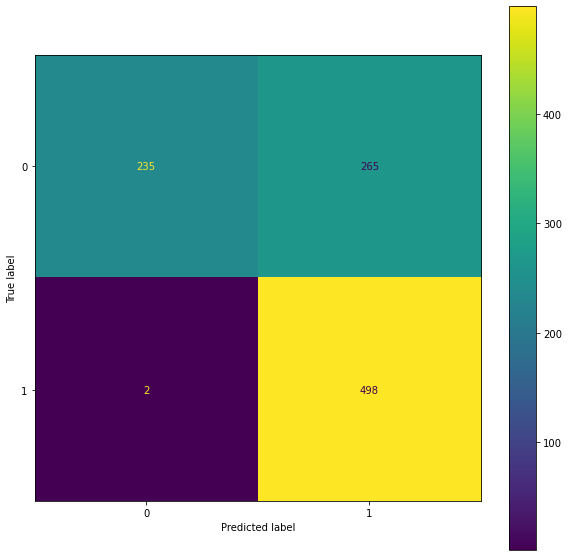

In [94]:
fig, ax = plt.subplots(figsize=(10, 10))
conf_matrix = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(conf_matrix).plot(ax=ax)
print(classification_report(y_true, y_pred))

### Evaluate Adversarial Trained Model

In [95]:
model_predictions_AT = batch_predict(model_wrapper_AT, test_text_list, batch_size=64)

100%|██████████| 16/16 [00:03<00:00,  4.53it/s]


              precision    recall  f1-score   support

           0       1.00      0.40      0.57       500
           1       0.62      1.00      0.77       500

    accuracy                           0.70      1000
   macro avg       0.81      0.70      0.67      1000
weighted avg       0.81      0.70      0.67      1000



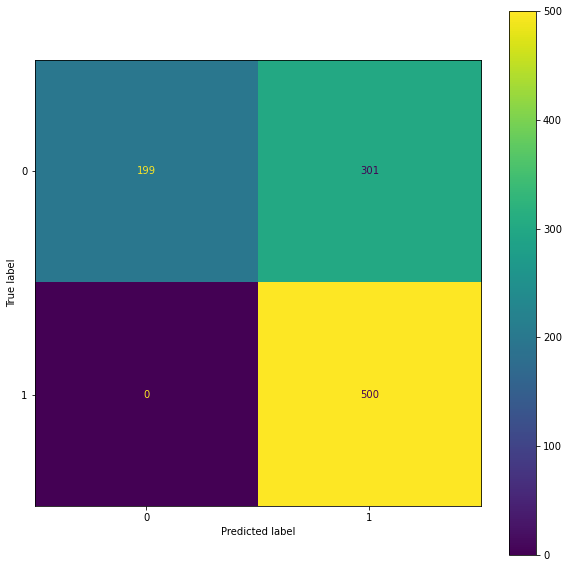

In [96]:
y_pred_prob_AT = model_predictions_AT.flatten()
y_pred_AT = [0 if x < threshold else 1 for x in y_pred_prob_AT]

fig, ax = plt.subplots(figsize=(10, 10))
conf_matrix = confusion_matrix(y_true, y_pred_AT)
ConfusionMatrixDisplay(conf_matrix).plot(ax=ax)
print(classification_report(y_true, y_pred_AT))